# Market Cycle Labeling for 5-Minute K-Line Data

## Based on Al Brooks Price Action Theory

**Labels:**
- `-1`: 下跌趋势 (Downtrend)
- `0`: 震荡/交易区间 (Trading Range / Breakout Mode)
- `+1`: 上涨趋势 (Uptrend)

**Core Principles:**
1. 只关心本周期局部结构，利用少量未来信息（triple barrier + 未来窗口）来标注
2. 充分利用 KAMA（含ER效率因子）来测"趋势 vs 震荡"
3. 结合 Al Brooks 的20根bar交易区间中性化规则
4. 用 triple barrier 做"方向确认"

**Pipeline Layers:**
1. 数据预处理层
2. 辅助特征层 (KAMA, ER, 线性回归, 震荡度)
3. Triple Barrier 层
4. 市场周期标签层 + 平滑


In [1]:
# ========== Cell 1: 环境配置 & 中文字体设置（mac 专用 + 显式 FontProperties） ==========

import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import numpy as np
import pandas as pd

# ========== Matplotlib & 字体 ==========
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sns
import os

# 全局变量：显式中文字体属性（后面画图时直接用）
CHINESE_FONT_PROP = None

def setup_chinese_font_mac():
    """
    在 macOS 上设置一个可用的中文字体：
    1）优先从常见路径加载 .ttc 文件，生成 FontProperties
    2）其次从系统字体名字中选择
    最后把 FontProperties 存到 CHINESE_FONT_PROP，方便后面显式使用
    """
    global CHINESE_FONT_PROP

    # 1) 优先尝试具体字体文件路径
    candidate_paths = [
        "/System/Library/Fonts/PingFang.ttc",
        "/System/Library/Fonts/STHeiti Light.ttc",
        "/System/Library/Fonts/STHeiti Medium.ttc",
        "/System/Library/Fonts/STSong.ttc",
    ]

    for p in candidate_paths:
        if os.path.exists(p):
            try:
                fm.fontManager.addfont(p)
                CHINESE_FONT_PROP = fm.FontProperties(fname=p)
                name = CHINESE_FONT_PROP.get_name()
                print(f"✅ 通过路径加载中文字体文件: {p}")
                print(f"   FontProperties 名称: {name}")

                # 同时把它设进 rcParams（即使不生效，后面还有 FontProperties 兜底）
                mpl.rcParams["font.family"] = "sans-serif"
                mpl.rcParams["font.sans-serif"] = [name]
                mpl.rcParams["axes.unicode_minus"] = False
                break
            except Exception as e:
                print(f"⚠️ 尝试加载字体失败: {p} -> {e}")

    # 2) 如果文件路径失败，再用字体名匹配
    if CHINESE_FONT_PROP is None:
        available = {f.name for f in fm.fontManager.ttflist}
        candidate_names = [
            "PingFang SC",
            "Hiragino Sans GB",
            "Songti SC",
            "STSong",
            "STHeiti",
            "Heiti TC",
        ]
        chosen = None
        for name in candidate_names:
            if name in available:
                chosen = name
                break

        if chosen is not None:
            CHINESE_FONT_PROP = fm.FontProperties(family=chosen)
            mpl.rcParams["font.family"] = "sans-serif"
            mpl.rcParams["font.sans-serif"] = [chosen]
            mpl.rcParams["axes.unicode_minus"] = False
            print(f"✅ 在系统字体中找到中文字体: {chosen}")
        else:
            print("⚠️ 未找到中文字体候选，可能仍然出现乱码")

    print("\n当前 Matplotlib 字体配置：")
    print("  font.family     :", mpl.rcParams["font.family"])
    print("  font.sans-serif :", mpl.rcParams["font.sans-serif"])
    print("  axes.unicode_minus:", mpl.rcParams["axes.unicode_minus"])

    if CHINESE_FONT_PROP is None:
        print("⚠️ CHINESE_FONT_PROP 为空，后续画图可能无法正常显示中文")
    else:
        print("✅ CHINESE_FONT_PROP 已就绪，可用于 title/xlabel/ylabel 的 fontproperties 参数")

    return CHINESE_FONT_PROP

CHINESE_FONT_PROP = setup_chinese_font_mac()

# 画图风格
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

# ========== Bokeh 配置 ==========
from bokeh.plotting import figure, show, output_notebook, output_file
from bokeh.models import ColumnDataSource, BoxAnnotation, HoverTool, Range1d, Span, Label
from bokeh.layouts import column
from bokeh.io import save

output_notebook()

# ========== 路径配置 ==========
DATA_DIR_FUTURE = Path("data/Future/rth")

# ========== 输出目录配置 ==========
OUTPUT_DIR = Path("market_cycle")
OUTPUT_DIR_DATA = OUTPUT_DIR / "data"       # 标注数据、训练数据
OUTPUT_DIR_CHARTS = OUTPUT_DIR / "charts"   # Bokeh 图表
OUTPUT_DIR_FEATURES = OUTPUT_DIR / "features"  # 特征矩阵

for d in [OUTPUT_DIR_DATA, OUTPUT_DIR_CHARTS, OUTPUT_DIR_FEATURES]:
    d.mkdir(parents=True, exist_ok=True)

print(f"\nDATA_DIR_FUTURE: {DATA_DIR_FUTURE.resolve()}")
print(f"K线数据目录存在: {DATA_DIR_FUTURE.exists()}")
print("\n输出目录:")
print(f"  数据 : {OUTPUT_DIR_DATA.resolve()}")
print(f"  图表 : {OUTPUT_DIR_CHARTS.resolve()}")
print(f"  特征 : {OUTPUT_DIR_FEATURES.resolve()}")

print("\nCell 1 完成: 库导入 & 中文字体配置（含 FontProperties）✅")


✅ 通过路径加载中文字体文件: /System/Library/Fonts/STHeiti Light.ttc
   FontProperties 名称: Heiti TC

当前 Matplotlib 字体配置：
  font.family     : ['sans-serif']
  font.sans-serif : ['Heiti TC']
  axes.unicode_minus: False
✅ CHINESE_FONT_PROP 已就绪，可用于 title/xlabel/ylabel 的 fontproperties 参数


Loading BokehJS ...


DATA_DIR_FUTURE: /Users/duchengtai/Library/Mobile Documents/com~apple~CloudDocs/实习/MinsyAI/Market_Cycle_Research/data/Future/rth
K线数据目录存在: True

输出目录:
  数据 : /Users/duchengtai/Library/Mobile Documents/com~apple~CloudDocs/实习/MinsyAI/Market_Cycle_Research/market_cycle/data
  图表 : /Users/duchengtai/Library/Mobile Documents/com~apple~CloudDocs/实习/MinsyAI/Market_Cycle_Research/market_cycle/charts
  特征 : /Users/duchengtai/Library/Mobile Documents/com~apple~CloudDocs/实习/MinsyAI/Market_Cycle_Research/market_cycle/features

Cell 1 完成: 库导入 & 中文字体配置（含 FontProperties）✅


当前 Matplotlib 字体相关配置：
  font.family     : ['sans-serif']
  font.sans-serif : ['Arial', 'Liberation Sans', 'DejaVu Sans', 'Bitstream Vera Sans', 'sans-serif']
  axes.unicode_minus: False

CHINESE_FONT_PROP = sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:file=/System/Library/Fonts/STHeiti Light.ttc:size=10.0


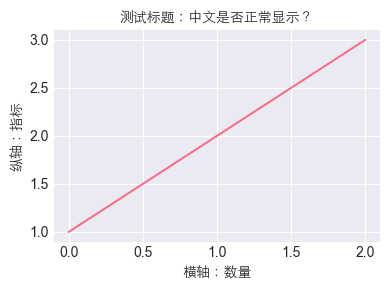


Cell 2 完成：中文字体测试 ✅


In [2]:
# ========== Cell 2: 测试中文绘图（显式 FontProperties） ==========

import matplotlib.pyplot as plt
import matplotlib as mpl

print("当前 Matplotlib 字体相关配置：")
print("  font.family     :", mpl.rcParams["font.family"])
print("  font.sans-serif :", mpl.rcParams["font.sans-serif"])
print("  axes.unicode_minus:", mpl.rcParams["axes.unicode_minus"])

from matplotlib import font_manager as fm

print("\nCHINESE_FONT_PROP =", CHINESE_FONT_PROP)

plt.figure(figsize=(4, 3))
plt.title("测试标题：中文是否正常显示？", fontproperties=CHINESE_FONT_PROP)
plt.xlabel("横轴：数量", fontproperties=CHINESE_FONT_PROP)
plt.ylabel("纵轴：指标", fontproperties=CHINESE_FONT_PROP)
plt.plot([1, 2, 3])
plt.tight_layout()
plt.show()

print("\nCell 2 完成：中文字体测试 ✅")


In [3]:
# ========== Cell 2: 全局超参数配置 ==========
"""
📌 参数调优指南:
   - 想要检测到更多趋势 → 降低 THR_ER_LOW, THR_CHOP_HIGH, 提高 THR_ER_HIGH
   - 想要更严格的趋势判定 → 提高 THR_ER_HIGH, 降低 THR_CHOP_LOW
   - Al Brooks 80/20 规则: 约80%时间在震荡区间，20%时间在趋势中
   
⚡ 快速调参: 只修改这个 Cell，然后重新运行后续所有 Cell 即可
"""

# ═══════════════════════════════════════════════════════════════════════════════
# 📊 基础计算参数
# ═══════════════════════════════════════════════════════════════════════════════
N_ATR = 20          # ATR 计算周期 (5min K线, 20根≈100分钟)
                    #   ↓ 减小: ATR 更敏感，波动估计更及时但更noisy
                    #   ↑ 增大: ATR 更稳定，但对突发波动反应慢

N_ER = 20           # ER 效率因子窗口 (与 Brooks 20-bar 规则一致)
                    #   ↓ 减小: 更快检测到趋势开始，但可能产生更多假信号
                    #   ↑ 增大: 趋势判断更可靠，但会错过趋势初期

L_BACK = 20         # 回看窗口 (用于线性回归、震荡度等)

# ═══════════════════════════════════════════════════════════════════════════════
# 📈 KAMA (Kaufman Adaptive Moving Average) 参数
# ═══════════════════════════════════════════════════════════════════════════════
KAMA_N_ER = 10      # KAMA 内部的 ER 计算窗口
                    #   ↓ 减小: KAMA 对趋势变化更敏感
                    #   ↑ 增大: KAMA 更平滑

KAMA_FAST = 2       # 快速 EMA 周期 (趋势强时使用)
KAMA_SLOW = 30      # 慢速 EMA 周期 (震荡时使用)
KAMA_SLOPE_LAG = 5  # KAMA 斜率计算滞后 (用几根bar计算斜率)

# ═══════════════════════════════════════════════════════════════════════════════
# 🎯 Triple Barrier 参数 (方向确认) 未来信息特征标签机制
# ═══════════════════════════════════════════════════════════════════════════════
T_VERT = 12         # 垂直时间障碍 (12根5min≈1小时)
                    #   ↓ 减小: 只看短期方向，更适合短线
                    #   ↑ 增大: 看更长期方向，趋势判断更稳健

PT_MULT = 1.5       # 止盈倍数 (相对ATR)
                    #   ↓ 减小: 更容易触发方向标签，检测到更多趋势
                    #   ↑ 增大: 只有强势行情才给方向标签

SL_MULT = 1.5       # 止损倍数 (相对ATR)，通常与 PT_MULT 相同

# ═══════════════════════════════════════════════════════════════════════════════
# 🔴 震荡区间判定参数 (严格条件，需同时满足多个)
# ═══════════════════════════════════════════════════════════════════════════════
L_RANGE = 10        # 区间窗口 (前后各多少根bar)
L_RANGE_FWD = 10    # 未来窗口 (用于判断是否仍在区间) 未来信息

THR_ER_LOW = 0.25   # 【关键】ER < 此值视为震荡 低ER视为震荡
                    #   ↓ 减小(如0.2): 更严格，只有极度震荡才标为区间 → 趋势比例↑
                    #   ↑ 增大(如0.4): 更宽松，更多bar标为震荡区间 → 震荡比例↑

THR_CHOP_HIGH = 0.5  # 【关键】chop > 此值视为震荡 高chop视为震荡
                    

THR_RANGE_ATR = 3.5 # range/ATR < 此值视为窄区间
                    #   ↓ 减小: 需要更窄的区间才算震荡
                    #   ↑ 增大: 更宽的区间也可以算震荡

THR_R2_LOW = 0.25   # R² < 此值视为无明显线性趋势 线型回归拟合度低
                    #   ↓ 减小: 更宽松，允许稍有趋势性的区间
                    #   ↑ 增大: 更严格

THR_FUTURE_MOVE = 1.2  # 未来移动 < 此值*ATR 视为仍在区间 未来信息
                    #   ↓ 减小: 更严格，需要价格几乎不动
                    #   ↑ 增大: 允许更大的未来移动仍算区间

# ═══════════════════════════════════════════════════════════════════════════════
# 🟢 趋势判定参数 (对非震荡区间的bar进行趋势判定)
# ═══════════════════════════════════════════════════════════════════════════════
THR_ER_HIGH = 0.35  # 【关键】ER > 此值开始考虑趋势
                    #   ↓ 减小(如0.3): 更容易被判定为趋势 → 趋势比例↑
                    #   ↑ 增大(如0.5): 需要更强的效率才给趋势标签 → 趋势比例↓

THR_CHOP_LOW = 0.33 # 【关键】chop < 此值开始考虑趋势
              

THR_SLOPE_NORM = 0.015  # KAMA斜率标准化阈值 (每bar移动多少ATR)
                    #   ↓ 减小: 更容易满足斜率条件 → 趋势比例↑
                    #   ↑ 增大: 需要更陡的斜率才算趋势

THR_DIST_NORM = 0.4 # 价格偏离KAMA的标准化阈值
                    #   ↓ 减小: 更容易满足偏离条件 → 趋势比例↑
                    #   ↑ 增大: 需要更大的偏离才算趋势

L_FWD = 12          # 趋势确认的未来窗口 (约1小时)
                    #   用于验证当前斜率方向与未来走势是否一致

# ═══════════════════════════════════════════════════════════════════════════════
# 🔧 标签平滑参数
# ═══════════════════════════════════════════════════════════════════════════════
MIN_TREND_LEN = 4   # 最小趋势段长度 (太短的趋势段标为0)
                    #   ↓ 减小: 保留更短的趋势段 → 趋势比例↑
                    #   ↑ 增大: 过滤掉短趋势 → 震荡比例↑

MIN_RANGE_LEN = 15  # 最小震荡区间长度 (Brooks原始为20)
                    #   ↓ 减小: 更短的震荡也保留 → 震荡比例↑
                    #   ↑ 增大: 只保留长震荡 → 趋势比例↑

SMOOTH_WINDOW = 5   # 平滑窗口 (多数投票)

# ═══════════════════════════════════════════════════════════════════════════════
# 🌊 微通道 & 市场状态增强参数（10+2 抽象相关）
# ═══════════════════════════════════════════════════════════════════════════════

# —— 单个微通道结构参数 ——
MICRO_WIN = 3          # 微通道长度（3根K线）
MICRO_TICK_SIZE = 0.25 # 合约最小跳动单位，用于判断缺口/入场价

# —— 微通道质量 / 未来可交易性相关 ——
MC_QUALITY_MIN = 0.7   # 认为是“高质量微通道”的质量阈值(0~1)
MC_LOOKAHEAD = 10      # 用于 market-state 打标签时，向前看多少根内是否出现高质量微通道
MC_TRADE_HORIZON = 10  # 最朴素回测中，进场后最多观察多少根bar决定盈亏
MC_R_MULT = 1.0        # 微通道最朴素止盈R倍数（1R=入场到止损的距离）

# —— 过去窗口的市场状态统计（阴阳比例、run-length、dom-score 等） ——
STATE_WIN_SHORT = 5    # 短窗口（近期 5 根）
STATE_WIN_LONG = 10    # 长窗口（近期 10 根）

# —— 波动压缩 / Hurst 指标窗口 ——
VOL_SHORT_WIN = 5      # 短期 realized vol / ATR 计算窗口
VOL_LONG_WIN = 20      # 长期 realized vol / ATR 计算窗口
HURST_WINDOW = 50      # Hurst 指数滚动窗口（近 50 根 5min）

# ═══════════════════════════════════════════════════════════════════════════════
# 📋 打印当前配置
# ═══════════════════════════════════════════════════════════════════════════════
print("=" * 70)
print("📊 当前参数配置")
print("=" * 70)
print(f"\n【基础参数】")
print(f"  ATR周期: {N_ATR}, ER窗口: {N_ER}, 回看窗口: {L_BACK}")
print(f"\n【KAMA参数】")
print(f"  n_er={KAMA_N_ER}, fast={KAMA_FAST}, slow={KAMA_SLOW}, slope_lag={KAMA_SLOPE_LAG}")
print(f"\n【Triple Barrier】")
print(f"  T_vert={T_VERT} (~{T_VERT*5}分钟), pt_mult={PT_MULT}, sl_mult={SL_MULT}")
print(f"\n【震荡区间判定】 (需同时满足)")
print(f"  ER < {THR_ER_LOW}, chop > {THR_CHOP_HIGH}, range_atr < {THR_RANGE_ATR}")
print(f"  R² < {THR_R2_LOW}, future_move < {THR_FUTURE_MOVE}*ATR")
print(f"\n【趋势判定】 (满足部分条件)")
print(f"  ER > {THR_ER_HIGH} 或 chop < {THR_CHOP_LOW}")
print(f"  slope_norm > {THR_SLOPE_NORM}, dist_norm > {THR_DIST_NORM}")
print(f"\n【标签平滑】")
print(f"  最小趋势长度: {MIN_TREND_LEN}, 最小震荡长度: {MIN_RANGE_LEN}, 平滑窗口: {SMOOTH_WINDOW}")

print(f"\n【微通道结构】")
print(f"  MICRO_WIN={MICRO_WIN}, tick_size={MICRO_TICK_SIZE}")
print(f"\n【微通道质量 & 未来可交易性】")
print(f"  质量阈值: MC_QUALITY_MIN={MC_QUALITY_MIN}")
print(f"  未来查找窗口: MC_LOOKAHEAD={MC_LOOKAHEAD} 根K线")
print(f"  交易回测窗口: MC_TRADE_HORIZON={MC_TRADE_HORIZON} 根K线, R倍数: MC_R_MULT={MC_R_MULT}")
print(f"\n【过去窗口市场状态统计】")
print(f"  STATE_WIN_SHORT={STATE_WIN_SHORT}, STATE_WIN_LONG={STATE_WIN_LONG}")
print(f"\n【波动压缩 / Hurst】")
print(f"  VOL_SHORT_WIN={VOL_SHORT_WIN}, VOL_LONG_WIN={VOL_LONG_WIN}, HURST_WINDOW={HURST_WINDOW}")

print("=" * 70)

print("\n✅ Cell 2 完成: 参数配置 (修改后重新运行后续Cell即可)")


📊 当前参数配置

【基础参数】
  ATR周期: 20, ER窗口: 20, 回看窗口: 20

【KAMA参数】
  n_er=10, fast=2, slow=30, slope_lag=5

【Triple Barrier】
  T_vert=12 (~60分钟), pt_mult=1.5, sl_mult=1.5

【震荡区间判定】 (需同时满足)
  ER < 0.25, chop > 0.5, range_atr < 3.5
  R² < 0.25, future_move < 1.2*ATR

【趋势判定】 (满足部分条件)
  ER > 0.35 或 chop < 0.33
  slope_norm > 0.015, dist_norm > 0.4

【标签平滑】
  最小趋势长度: 4, 最小震荡长度: 15, 平滑窗口: 5

【微通道结构】
  MICRO_WIN=3, tick_size=0.25

【微通道质量 & 未来可交易性】
  质量阈值: MC_QUALITY_MIN=0.7
  未来查找窗口: MC_LOOKAHEAD=10 根K线
  交易回测窗口: MC_TRADE_HORIZON=10 根K线, R倍数: MC_R_MULT=1.0

【过去窗口市场状态统计】
  STATE_WIN_SHORT=5, STATE_WIN_LONG=10

【波动压缩 / Hurst】
  VOL_SHORT_WIN=5, VOL_LONG_WIN=20, HURST_WINDOW=50

✅ Cell 2 完成: 参数配置 (修改后重新运行后续Cell即可)


In [4]:
# ========== Cell 3: 加载并合并 5min K线数据 ==========

# 获取所有 ES 5min K线文件
five_min_files = sorted(DATA_DIR_FUTURE.glob("ES_5min_rth_*.csv"))
print(f"找到的 5min K线文件数量: {len(five_min_files)}")

if not five_min_files:
    raise FileNotFoundError(f"在目录 {DATA_DIR_FUTURE} 下未找到 ES_5min_rth_*.csv 文件")

dfs = []
for f in five_min_files:
    print(f"读取: {f.name}")
    df_year = pd.read_csv(f)
    
    # 检查必要列
    required_cols = {"timestamp", "open", "high", "low", "close", "volume"}
    missing_cols = required_cols - set(df_year.columns)
    if missing_cols:
        raise ValueError(f"文件 {f.name} 缺少必要列: {missing_cols}")
    
    # 转换时间戳
    df_year["timestamp"] = pd.to_datetime(df_year["timestamp"], errors="coerce")
    df_year = df_year.sort_values("timestamp")
    dfs.append(df_year)

# 合并所有年份
df = pd.concat(dfs, ignore_index=True)
df = df.sort_values("timestamp").reset_index(drop=True)
df = df.set_index("timestamp")

# 确保数值列类型正确
for col in ["open", "high", "low", "close", "volume"]:
    df[col] = df[col].astype(float)

print(f"\n=== df 基本信息 ===")
print(f"Shape: {df.shape}")
print(f"时间范围: {df.index.min()} ~ {df.index.max()}")
print(f"重复时间戳数量: {df.index.duplicated().sum()}")

# 检查缺失值
missing = df.isnull().sum()
if missing.sum() > 0:
    print(f"\n存在缺失值:\n{missing[missing > 0]}")
else:
    print("\n无缺失值")

display(df.head())
print("\nCell 3 完成: 数据加载完毕 ✅")


找到的 5min K线文件数量: 16
读取: ES_5min_rth_2010.csv
读取: ES_5min_rth_2011.csv
读取: ES_5min_rth_2012.csv
读取: ES_5min_rth_2013.csv
读取: ES_5min_rth_2014.csv
读取: ES_5min_rth_2015.csv
读取: ES_5min_rth_2016.csv
读取: ES_5min_rth_2017.csv
读取: ES_5min_rth_2018.csv
读取: ES_5min_rth_2019.csv
读取: ES_5min_rth_2020.csv
读取: ES_5min_rth_2021.csv
读取: ES_5min_rth_2022.csv
读取: ES_5min_rth_2023.csv
读取: ES_5min_rth_2024.csv
读取: ES_5min_rth_2025.csv

=== df 基本信息 ===
Shape: (309412, 5)
时间范围: 2010-06-07 09:30:00-04:00 ~ 2025-11-26 16:00:00-05:00
重复时间戳数量: 0

无缺失值


,open,high,low,close,volume
timestamp,,,,,
2010-06-07 09:30:00-04:00,1066.75,1068.25,1065.00,1065.25,45516.0
2010-06-07 09:35:00-04:00,1065.25,1066.50,1063.50,1064.25,46783.0
2010-06-07 09:40:00-04:00,1064.25,1064.50,1061.50,1061.50,55016.0
2010-06-07 09:45:00-04:00,1061.50,1065.00,1060.50,1064.50,46708.0
2010-06-07 09:50:00-04:00,1064.75,1067.50,1063.75,1067.50,43551.0



Cell 3 完成: 数据加载完毕 ✅


In [5]:
# ========== Cell 4: 数据预处理 - 基础序列计算 ==========

df = df.copy()

# 1. 对数收益 (log return)
# r_t = ln(C_t) - ln(C_{t-1})
df["log_close"] = np.log(df["close"])
df["log_return"] = df["log_close"].diff()

# 2. 真实波动范围 (True Range) 和 ATR
# TR_t = max(H_t - L_t, |H_t - C_{t-1}|, |L_t - C_{t-1}|)
prev_close = df["close"].shift(1)
tr1 = df["high"] - df["low"]
tr2 = np.abs(df["high"] - prev_close)
tr3 = np.abs(df["low"] - prev_close)
df["tr"] = np.maximum(np.maximum(tr1, tr2), tr3)

# ATR 使用 EMA
df["atr"] = df["tr"].ewm(span=N_ATR, adjust=False).mean()

# 3. 滚动高低价区间
df["roll_max"] = df["close"].rolling(window=L_BACK).max()
df["roll_min"] = df["close"].rolling(window=L_BACK).min()
df["roll_range"] = df["roll_max"] - df["roll_min"] # 高价减低价

# 4. 相对区间 (range / ATR)
df["range_atr"] = df["roll_range"] / df["atr"].replace(0, np.nan)

print("=== 基础序列计算完成 ===")
print(f"log_return: mean={df['log_return'].mean():.6f}, std={df['log_return'].std():.6f}")
print(f"ATR: mean={df['atr'].mean():.4f}, std={df['atr'].std():.4f}")
print(f"range_atr: mean={df['range_atr'].mean():.4f}, std={df['range_atr'].std():.4f}")

display(df[["open", "high", "low", "close", "log_return", "tr", "atr", "range_atr"]].tail(10))
print("\nCell 4 完成 ✅")

=== 基础序列计算完成 ===
log_return: mean=0.000006, std=0.001216
ATR: mean=3.6985, std=3.3360
range_atr: mean=3.7565, std=1.5626


,open,high,low,close,log_return,tr,atr,range_atr
timestamp,,,,,,,,
2025-11-26 15:15:00-05:00,6843.50,6845.25,6840.75,6840.75,-0.000365,4.50,5.186093,3.181586
2025-11-26 15:20:00-05:00,6841.00,6844.00,6841.00,6842.00,0.000183,3.25,5.001703,2.299217
2025-11-26 15:25:00-05:00,6842.25,6843.00,6840.50,6841.00,-0.000146,2.50,4.763445,2.414219
2025-11-26 15:30:00-05:00,6841.25,6842.75,6838.00,6841.00,0.000000,4.75,4.762165,2.152382
2025-11-26 15:35:00-05:00,6841.00,6841.50,6838.75,6840.25,-0.000110,2.75,4.570530,2.187930
2025-11-26 15:40:00-05:00,6840.25,6843.00,6838.75,6840.50,0.000037,4.25,4.540003,2.202642
2025-11-26 15:45:00-05:00,6840.75,6842.75,6835.25,6835.50,-0.000731,7.50,4.821908,1.710941
2025-11-26 15:50:00-05:00,6835.50,6839.25,6831.00,6832.00,-0.000512,8.25,5.148393,2.185148
2025-11-26 15:55:00-05:00,6831.75,6834.00,6825.25,6825.25,-0.000988,8.75,5.491403,3.277851



Cell 4 完成 ✅


CHINESE_FONT_PROP.get_name() = Heiti TC

✅ 已重置 Matplotlib 全局字体配置:
  font.family     : ['sans-serif']
  font.sans-serif : ['Heiti TC', 'Arial', 'DejaVu Sans', 'sans-serif']
  axes.unicode_minus: False


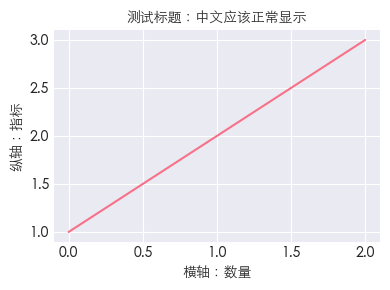


Cell 1.5 完成 ✅


In [6]:
# ========== Cell 1.5: 覆盖掉所有可能残留的 Windows 字体设置 ==========

import matplotlib as mpl
import matplotlib.pyplot as plt

# 使用在 Cell 1 中已经准备好的 CHINESE_FONT_PROP
# 它对应的字体名应该是 "Heiti TC"（从你刚才的输出看）
font_name = CHINESE_FONT_PROP.get_name()
print(f"CHINESE_FONT_PROP.get_name() = {font_name}")

# 彻底覆盖全局字体配置（把之前可能的 Microsoft YaHei 顶掉）
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = [font_name, "Arial", "DejaVu Sans", "sans-serif"]
mpl.rcParams["axes.unicode_minus"] = False

print("\n✅ 已重置 Matplotlib 全局字体配置:")
print("  font.family     :", mpl.rcParams["font.family"])
print("  font.sans-serif :", mpl.rcParams["font.sans-serif"])
print("  axes.unicode_minus:", mpl.rcParams["axes.unicode_minus"])

# 做一个简单测试图
plt.figure(figsize=(4, 3))
plt.title("测试标题：中文应该正常显示", fontproperties=CHINESE_FONT_PROP)
plt.xlabel("横轴：数量", fontproperties=CHINESE_FONT_PROP)
plt.ylabel("纵轴：指标", fontproperties=CHINESE_FONT_PROP)
plt.plot([1, 2, 3])
plt.tight_layout()
plt.show()

print("\nCell 1.5 完成 ✅")


=== KAMA & ER 计算完成 ===
ER: mean=0.2388, median=0.2069
KAMA斜率标准化: mean=0.0147, std=0.1854
价格偏离度: mean=0.0971, std=1.1013


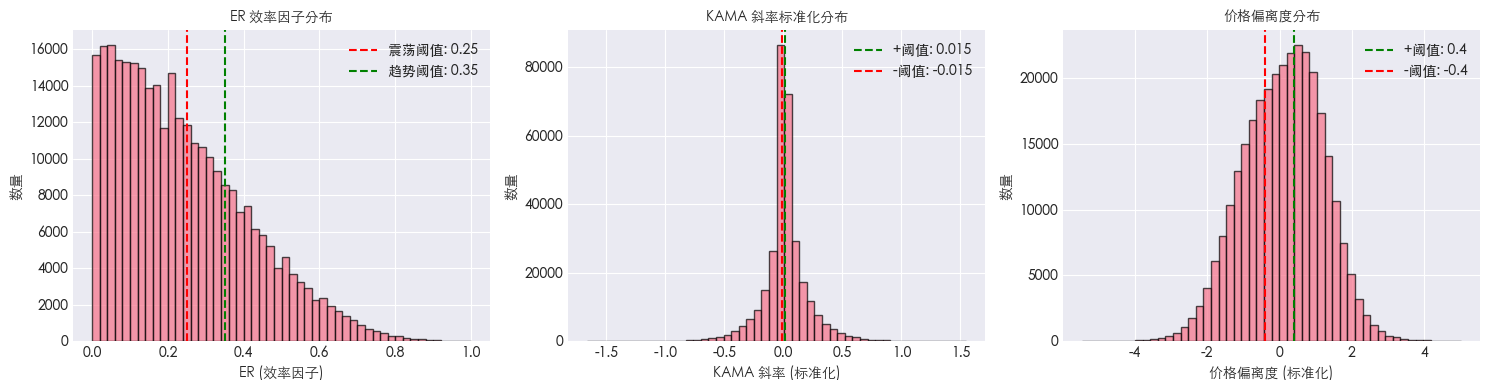


Cell 5 完成 ✅


In [7]:
# ========== Cell 5: KAMA 与 ER (效率因子) 计算 ==========

def calc_efficiency_ratio(close: pd.Series, n: int) -> pd.Series:
    """
    计算效率因子 ER (Efficiency Ratio)
    
    ER_t = |C_t - C_{t-n}| / sum(|C_i - C_{i-1}|, i=t-n+1 to t)
    
    ER → 1: 价格几乎"走直线"，趋势干净
    ER → 0: 大量来回震荡，典型交易区间
    """
    change = (close - close.shift(n)).abs()
    volatility = close.diff().abs().rolling(window=n).sum()
    er = change / volatility.replace(0, np.nan)
    return er.clip(0, 1)
# 给后面 KAMA 一个“当前是趋势还是震荡”的量

def calc_kama(close: pd.Series, n_er: int, fast: int, slow: int) -> pd.Series:
    """
    计算 KAMA (Kaufman Adaptive Moving Average)
    
    SC (Smoothing Constant) = [ER * (fast_sc - slow_sc) + slow_sc]^2
    KAMA_t = KAMA_{t-1} + SC * (Close_t - KAMA_{t-1})
    """
    # 计算 ER
    er = calc_efficiency_ratio(close, n_er)
    
    # 平滑常数
    fast_sc = 2 / (fast + 1)
    slow_sc = 2 / (slow + 1)
    sc = (er * (fast_sc - slow_sc) + slow_sc) ** 2
    '''
    趋势干净（ER≈1）→ SC 接近 fast_sc²（跟得很快）
    震荡严重（ER≈0）→ SC 接近 slow_sc²（走得很慢，很钝）
    '''
    
    # 初始化 KAMA
    kama = np.zeros(len(close))
    kama[:] = np.nan # 先全设为 NaN
    
    # 找第一个非 NaN 的 SC 位置
    first_valid = sc.first_valid_index()
    if first_valid is None:
        return pd.Series(kama, index=close.index)
    
    first_idx = close.index.get_loc(first_valid)
    
    # 用 SMA 初始化
    kama[first_idx] = close.iloc[:first_idx + 1].mean()
    
    # 递归计算
    close_arr = close.values
    sc_arr = sc.values
    for i in range(first_idx + 1, len(close)):
        if np.isnan(sc_arr[i]):
            kama[i] = kama[i - 1]
        else:
            kama[i] = kama[i - 1] + sc_arr[i] * (close_arr[i] - kama[i - 1]) # 只看当前时刻和前一时刻
    
    return pd.Series(kama, index=close.index)


# 计算 ER (使用全局 N_ER 参数)
df["er"] = calc_efficiency_ratio(df["close"], N_ER)

# 计算 KAMA
df["kama"] = calc_kama(df["close"], KAMA_N_ER, KAMA_FAST, KAMA_SLOW) # kama是一条均线

# 计算 KAMA 斜率 (使用 KAMA_SLOPE_LAG)
df["kama_slope"] = (df["kama"] - df["kama"].shift(KAMA_SLOPE_LAG)) / KAMA_SLOPE_LAG

# 斜率标准化 (相对 ATR)
# slope_norm_t = slope_t / ATR_t
df["slope_norm"] = df["kama_slope"] / df["atr"].replace(0, np.nan)

# 价格偏离度 (相对 ATR)
# dist_norm_t = (C_t - KAMA_t) / ATR_t
df["dist_norm"] = (df["close"] - df["kama"]) / df["atr"].replace(0, np.nan) # 价格偏离均线的距离

print("=== KAMA & ER 计算完成 ===")
print(f"ER: mean={df['er'].mean():.4f}, median={df['er'].median():.4f}")
print(f"KAMA斜率标准化: mean={df['slope_norm'].mean():.4f}, std={df['slope_norm'].std():.4f}")
print(f"价格偏离度: mean={df['dist_norm'].mean():.4f}, std={df['dist_norm'].std():.4f}")


# ER 分布直方图
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(df["er"].dropna(), bins=50, edgecolor="black", alpha=0.7)
axes[0].axvline(x=THR_ER_LOW, color="red", linestyle="--", label=f"震荡阈值: {THR_ER_LOW}")
axes[0].axvline(x=THR_ER_HIGH, color="green", linestyle="--", label=f"趋势阈值: {THR_ER_HIGH}")
axes[0].set_xlabel("ER (效率因子)", fontproperties=CHINESE_FONT_PROP)
axes[0].set_ylabel("数量", fontproperties=CHINESE_FONT_PROP)
axes[0].set_title("ER 效率因子分布", fontproperties=CHINESE_FONT_PROP)
axes[0].legend()

axes[1].hist(df["slope_norm"].dropna(), bins=50, edgecolor="black", alpha=0.7)
axes[1].axvline(x=THR_SLOPE_NORM, color="green", linestyle="--", label=f"+阈值: {THR_SLOPE_NORM}")
axes[1].axvline(x=-THR_SLOPE_NORM, color="red", linestyle="--", label=f"-阈值: -{THR_SLOPE_NORM}")
axes[1].set_xlabel("KAMA 斜率 (标准化)", fontproperties=CHINESE_FONT_PROP)
axes[1].set_ylabel("数量", fontproperties=CHINESE_FONT_PROP)
axes[1].set_title("KAMA 斜率标准化分布", fontproperties=CHINESE_FONT_PROP)
axes[1].legend()

axes[2].hist(df["dist_norm"].dropna(), bins=50, edgecolor="black", alpha=0.7)
axes[2].axvline(x=THR_DIST_NORM, color="green", linestyle="--", label=f"+阈值: {THR_DIST_NORM}")
axes[2].axvline(x=-THR_DIST_NORM, color="red", linestyle="--", label=f"-阈值: -{THR_DIST_NORM}")
axes[2].set_xlabel("价格偏离度 (标准化)", fontproperties=CHINESE_FONT_PROP)
axes[2].set_ylabel("数量", fontproperties=CHINESE_FONT_PROP)
axes[2].set_title("价格偏离度分布", fontproperties=CHINESE_FONT_PROP)
axes[2].legend()

plt.tight_layout()
plt.show()


print("\nCell 5 完成 ✅")


计算滚动线性回归...
计算震荡度 (Choppiness Index)...

=== 本地结构特征计算完成 ===
Beta (斜率): mean=0.000006, std=0.000281
R² (拟合度): mean=0.4350, median=0.4468
Chop (Choppiness Index): mean=0.5057, median=0.5133
Overlap Ratio (重叠度): mean=0.6000, median=0.6008


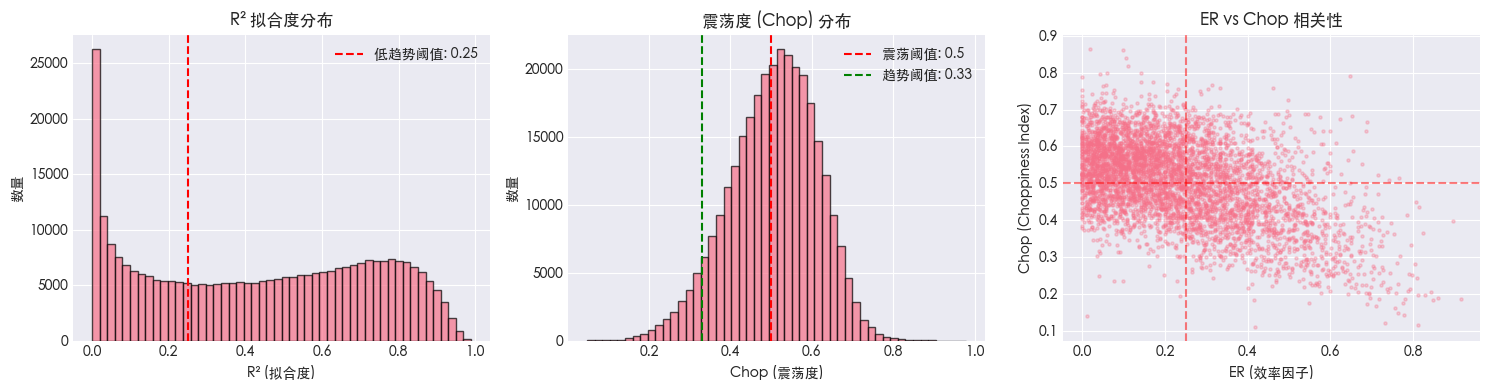


ER vs Chop 相关系数: -0.4787 (应该不再是 -1.0)
ER vs Overlap Ratio 相关系数: -0.1677

Cell 6 完成 ✅


In [8]:
# ========== Cell 6: 本地结构/震荡度特征 ==========

def rolling_linreg(y: np.ndarray, window: int) -> tuple:
    """
    对 y 序列做滚动线性回归，返回 (斜率, R²)
    使用简单的最小二乘法: y = beta * x + alpha
    x = [0, 1, 2, ..., window-1]
    """
    n = len(y)
    beta = np.full(n, np.nan)
    r2 = np.full(n, np.nan)
    
    x = np.arange(window)
    x_mean = x.mean()
    ss_x = ((x - x_mean) ** 2).sum()
    
    for i in range(window - 1, n):
        y_win = y[i - window + 1:i + 1]
        if np.any(np.isnan(y_win)):
            continue
        
        y_mean = y_win.mean()
        
        # 斜率
        ss_xy = ((x - x_mean) * (y_win - y_mean)).sum()
        b = ss_xy / ss_x if ss_x > 0 else 0
        
        # R²
        y_pred = b * (x - x_mean) + y_mean
        ss_res = ((y_win - y_pred) ** 2).sum()
        ss_tot = ((y_win - y_mean) ** 2).sum()
        r2_val = 1 - ss_res / ss_tot if ss_tot > 0 else 0
        
        beta[i] = b
        r2[i] = max(0, min(1, r2_val))  # clip to [0, 1]
    
    return beta, r2
# 返回线性回归的斜率和 R²（拟合度）
'''
- R² → 1：价格变化几乎完美线性，强趋势
- R² → 0：价格变化与线性模型偏差大，无明确方向
'''

# 1. 滚动线性回归 (对 log_close)
print("计算滚动线性回归...")
log_close_arr = df["log_close"].values # 对收盘价取对数
beta_arr, r2_arr = rolling_linreg(log_close_arr, L_BACK) # 计算收盘价的滚动线性回归

df["beta"] = beta_arr           # 斜率
df["r2"] = r2_arr               # R² (拟合程度)
'''
每一根 bar 都有一个：

beta：这段时间整体是往上还是往下、斜得多
r2：这段时间有多“顺直”
'''

# 2. 震荡度 (Choppiness Index - 基于ATR的标准定义)
# Choppiness Index = 100 * log10(sum(ATR_n) / (highest - lowest)) / log10(n)
# 这个定义与 ER 在数学上不完全等价，因为它使用 ATR 而非收盘价变动
print("计算震荡度 (Choppiness Index)...")

# 使用不同的窗口来避免与 ER 完美相关
CHOP_WINDOW = 14  # 标准 Choppiness Index 使用 14 周期

# 计算 ATR 的滚动和
atr_sum = df["tr"].rolling(window=CHOP_WINDOW).sum() # 窗口内真实波幅 TR 的总和（所有来回的波动都算进去）

# 计算窗口内的高低点差
high_max = df["high"].rolling(window=CHOP_WINDOW).max()
low_min = df["low"].rolling(window=CHOP_WINDOW).min()
hl_range = high_max - low_min

'''
如果 atr_sum >> hl_range：说明价格来回走来回走，动得很多但没走远 → 极度震荡
如果 atr_sum ≈ hl_range：说明基本就是走一条路，几乎没回头 → 趋势很干净
'''

# Choppiness Index (标准化到 0-1)
# 原始公式: 100 * log10(atr_sum / hl_range) / log10(n)
# 简化: chop = log10(atr_sum / hl_range) / log10(n)
# 值越高 = 越震荡, 值越低 = 越趋势
import math
df["chop"] = np.log10(atr_sum / hl_range.replace(0, np.nan)) / math.log10(CHOP_WINDOW)
df["chop"] = df["chop"].clip(0, 1)
'''
- chop → 1：TR总和远大于实际移动距离，震荡严重
- chop → 0：TR总和接近实际移动，趋势干净
'''


# 补充: 添加一个基于 bar 重叠度的震荡指标 (与 ER 不同)
# 计算相邻 bar 的重叠程度
prev_high = df["high"].shift(1)
prev_low = df["low"].shift(1)
overlap = np.minimum(df["high"], prev_high) - np.maximum(df["low"], prev_low)
overlap = overlap.clip(lower=0)
bar_range = (df["high"] - df["low"] + prev_high - prev_low) / 2
df["overlap_ratio"] = (overlap / bar_range.replace(0, np.nan)).rolling(window=L_BACK).mean() # overlap / bar_range：两根 K 叠在一起的比例
df["overlap_ratio"] = df["overlap_ratio"].clip(0, 1)
'''
越高 = 两两 K 线经常啃在一起 = 典型窄幅震荡/箱体
越低 = 每根 bar 都往一个方向推进，不怎么回踩 → 趋势更干净
'''


# 3. 验证: ER 与 chop 的关系
# 注意: 使用标准 Choppiness Index 定义后，ER 与 chop 不再完美负相关
# 高 ER -> 低 chop (趋势)
# 低 ER -> 高 chop (震荡)

print("\n=== 本地结构特征计算完成 ===")
print(f"Beta (斜率): mean={df['beta'].mean():.6f}, std={df['beta'].std():.6f}")
print(f"R² (拟合度): mean={df['r2'].mean():.4f}, median={df['r2'].median():.4f}")
print(f"Chop (Choppiness Index): mean={df['chop'].mean():.4f}, median={df['chop'].median():.4f}")
print(f"Overlap Ratio (重叠度): mean={df['overlap_ratio'].mean():.4f}, median={df['overlap_ratio'].median():.4f}")


# ER vs Chop 散点图
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# R² 分布
axes[0].hist(df["r2"].dropna(), bins=50, edgecolor="black", alpha=0.7)
axes[0].axvline(x=THR_R2_LOW, color="red", linestyle="--", label=f"低趋势阈值: {THR_R2_LOW}")
axes[0].set_xlabel("R² (拟合度)")
axes[0].set_ylabel("数量")
axes[0].set_title("R² 拟合度分布")
axes[0].legend()

# Chop 分布
axes[1].hist(df["chop"].dropna(), bins=50, edgecolor="black", alpha=0.7)
axes[1].axvline(x=THR_CHOP_HIGH, color="red", linestyle="--", label=f"震荡阈值: {THR_CHOP_HIGH}")
axes[1].axvline(x=THR_CHOP_LOW, color="green", linestyle="--", label=f"趋势阈值: {THR_CHOP_LOW}")
axes[1].set_xlabel("Chop (震荡度)")
axes[1].set_ylabel("数量")
axes[1].set_title("震荡度 (Chop) 分布")
axes[1].legend()

# ER vs Chop 散点图 (采样以加速)
sample_idx = np.random.choice(len(df.dropna()), size=min(5000, len(df.dropna())), replace=False)
df_sample = df.dropna().iloc[sample_idx]
axes[2].scatter(df_sample["er"], df_sample["chop"], alpha=0.3, s=5)
axes[2].set_xlabel("ER (效率因子)")
axes[2].set_ylabel("Chop (Choppiness Index)")
axes[2].set_title("ER vs Chop 相关性")
axes[2].axvline(x=THR_ER_LOW, color="red", linestyle="--", alpha=0.5)
axes[2].axhline(y=THR_CHOP_HIGH, color="red", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

# 计算相关系数
corr_er_chop = df[["er", "chop"]].dropna().corr().iloc[0, 1]
corr_er_overlap = df[["er", "overlap_ratio"]].dropna().corr().iloc[0, 1]
print(f"\nER vs Chop 相关系数: {corr_er_chop:.4f} (应该不再是 -1.0)")
print(f"ER vs Overlap Ratio 相关系数: {corr_er_overlap:.4f}")


print("\nCell 6 完成 ✅")


计算 Triple Barrier 方向标签...
参数: T_vert=12, pt_mult=1.5, sl_mult=1.5

=== Triple Barrier 标签分布 ===
  DOWN (-1): 143694 (46.44%)
  NEUTRAL (0): 4898 (1.58%)
  UP (1): 160820 (51.98%)


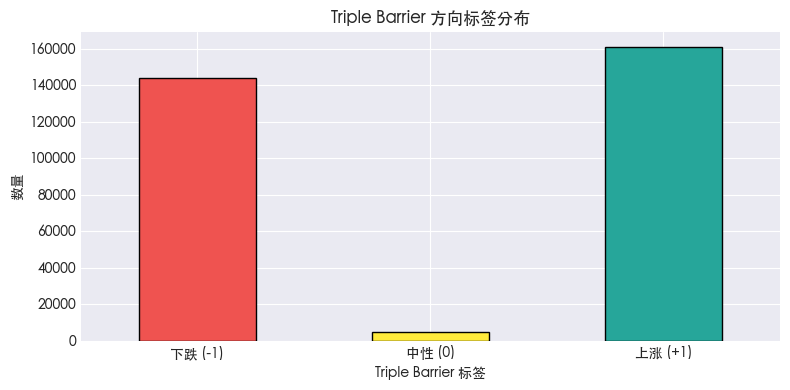


Cell 7 完成 ✅


In [9]:
# ========== Cell 7: Triple Barrier 方向标签 ==========

def triple_barrier_labels(close: np.ndarray, atr: np.ndarray, 
                          t_vert: int, pt_mult: float, sl_mult: float) -> np.ndarray:
    """
    为每个 bar 计算 triple barrier 标签
    
    参数:
        close: 收盘价数组
        atr: ATR 数组
        t_vert: 垂直时间障碍 (最大持有时间)
        pt_mult: 止盈倍数 (相对 ATR)
        sl_mult: 止损倍数 (相对 ATR)
    
    返回:
        d: 方向标签数组 (-1, 0, 1)
           +1: 先触及上轨 (止盈)
           -1: 先触及下轨 (止损)
            0: 未触及任何轨道 (时间截止)
    """
    n = len(close)
    d = np.zeros(n, dtype=np.int32)
    
    for t in range(n):
        if np.isnan(atr[t]) or atr[t] <= 0:
            d[t] = 0
            continue
        
        c_t = close[t]
        upper = c_t + pt_mult * atr[t]  # 止盈上轨
        lower = c_t - sl_mult * atr[t]  # 止损下轨
        
        # 遍历未来路径
        hit_up = False
        hit_down = False
        first_hit_up = n + 1
        first_hit_down = n + 1
        
        for j in range(1, min(t_vert + 1, n - t)): # 向未来看 t_vert 根
            future_close = close[t + j]
            
            if future_close >= upper and not hit_up:
                hit_up = True
                first_hit_up = j
            
            if future_close <= lower and not hit_down:
                hit_down = True
                first_hit_down = j
            
            if hit_up and hit_down:
                break
        
        # 判断哪个先触及
        if hit_up and hit_down:
            if first_hit_up < first_hit_down:
                d[t] = 1
            elif first_hit_down < first_hit_up:
                d[t] = -1
            else:
                d[t] = 0  # 同时触及，标为中性
        elif hit_up:
            d[t] = 1
        elif hit_down:
            d[t] = -1
        else:
            # 未触及任何轨道，用最终方向
            end_idx = min(t + t_vert, n - 1)
            if end_idx > t:
                final_move = close[end_idx] - c_t
                if final_move > 0:
                    d[t] = 1
                elif final_move < 0:
                    d[t] = -1
                else:
                    d[t] = 0
            else:
                d[t] = 0
    
    return d


# 计算 Triple Barrier 标签
print("计算 Triple Barrier 方向标签...")
print(f"参数: T_vert={T_VERT}, pt_mult={PT_MULT}, sl_mult={SL_MULT}")

close_arr = df["close"].values.astype(np.float64)
atr_arr = df["atr"].values.astype(np.float64)

df["d_barrier"] = triple_barrier_labels(close_arr, atr_arr, T_VERT, PT_MULT, SL_MULT)

# 统计分布
barrier_counts = df["d_barrier"].value_counts().sort_index()
print("\n=== Triple Barrier 标签分布 ===")
for k, v in barrier_counts.items():
    label_name = {-1: "DOWN", 0: "NEUTRAL", 1: "UP"}.get(k, str(k))
    print(f"  {label_name} ({k}): {v} ({v / len(df):.2%})")


# 可视化
fig, ax = plt.subplots(figsize=(8, 4))
barrier_counts.plot(kind="bar", ax=ax, color=["#ef5350", "#ffeb3b", "#26a69a"], edgecolor="black")
ax.set_xlabel("Triple Barrier 标签")
ax.set_ylabel("数量")
ax.set_title("Triple Barrier 方向标签分布")
ax.set_xticklabels(["下跌 (-1)", "中性 (0)", "上涨 (+1)"], rotation=0)
plt.tight_layout()
plt.show()


print("\nCell 7 完成 ✅")


In [10]:
# ========== Cell 8: 市场周期标签 - Step 1: 识别震荡区间 ==========

def identify_trading_range(df: pd.DataFrame, 
                           thr_er_low: float,
                           thr_chop_high: float,
                           thr_range_atr: float,
                           thr_r2_low: float,
                           thr_future_move: float,
                           l_range_fwd: int) -> np.ndarray:
    """
    识别震荡/交易区间
    
    判定条件 (满足所有条件):
    1. ER < thr_er_low (效率低, 来回震荡)
    2. chop > thr_chop_high (震荡度高)
    3. range_atr < thr_range_atr (区间相对窄)
    4. R² < thr_r2_low (无明显线性趋势)
    5. 未来移动 < thr_future_move * ATR (仍在区间内)
    
    返回:
        is_range: bool 数组, True 表示该 bar 处于交易区间
    """
    n = len(df)
    is_range = np.zeros(n, dtype=bool)
    
    er = df["er"].values
    chop = df["chop"].values
    range_atr = df["range_atr"].values
    r2 = df["r2"].values
    close = df["close"].values
    atr = df["atr"].values
    
    # 对每个时间点 t 做一套规则判断
    for t in range(n):
        # 检查基本条件
        if np.isnan(er[t]) or np.isnan(chop[t]) or np.isnan(range_atr[t]) or np.isnan(r2[t]):
            continue
        if np.isnan(atr[t]) or atr[t] <= 0:
            continue
        
        cond_er = er[t] < thr_er_low
        cond_chop = chop[t] > thr_chop_high
        cond_range = range_atr[t] < thr_range_atr
        cond_r2 = r2[t] < thr_r2_low
        
        # 检查未来移动 (利用少量未来信息)
        future_idx = min(t + l_range_fwd, n - 1)
        if future_idx > t:
            future_move = abs(close[future_idx] - close[t])
            cond_future = future_move < thr_future_move * atr[t]
        else:
            cond_future = True
        
        # 震荡区间判定: 满足 ER + chop 条件 AND (range 或 R² 或 future move)
        if cond_er and cond_chop and (cond_range or cond_r2 or cond_future):
            is_range[t] = True
    
    return is_range


# 计算初步的震荡区间标记
print("识别震荡/交易区间...")
is_range = identify_trading_range(
    df, 
    thr_er_low=THR_ER_LOW,
    thr_chop_high=THR_CHOP_HIGH,
    thr_range_atr=THR_RANGE_ATR,
    thr_r2_low=THR_R2_LOW,
    thr_future_move=THR_FUTURE_MOVE,
    l_range_fwd=L_RANGE_FWD
)

df["is_range_raw"] = is_range # 初步震荡区间标记

# 统计
range_count = is_range.sum()
print(f"\n初步震荡区间 bar 数量: {range_count} ({range_count / len(df):.2%})")

# 应用最小长度约束 (Brooks 20-bar rule)
# 只有连续 >= MIN_RANGE_LEN 个 bar 都是震荡区间，才确认为震荡
def apply_min_length_constraint(arr: np.ndarray, min_len: int, value: bool) -> np.ndarray:
    """
    对连续段应用最小长度约束
    """
    result = arr.copy()
    n = len(arr)
    i = 0
    
    while i < n:
        if arr[i] == value:
            # 找连续段的结束
            j = i + 1
            while j < n and arr[j] == value:
                j += 1
            
            seg_len = j - i
            if seg_len < min_len:
                # 太短，取消标记
                result[i:j] = not value
            
            i = j
        else:
            i += 1
    
    return result
# 只有连续 True 段长度 ≥ MIN_RANGE_LEN（默认15）才保留为 range

# 应用最小长度约束
is_range_filtered = apply_min_length_constraint(is_range, MIN_RANGE_LEN, True)
df["is_range"] = is_range_filtered

range_count_filtered = is_range_filtered.sum()
print(f"过滤后震荡区间 bar 数量 (min_len={MIN_RANGE_LEN}): {range_count_filtered} ({range_count_filtered / len(df):.2%})")

'''
# 扩展边缘 (前后各 2-3 bar)
EDGE_EXTEND = 2

def extend_range_edges(arr: np.ndarray, extend: int) -> np.ndarray:
    """
    对震荡区间的边缘进行扩展
    """
    result = arr.copy()
    n = len(arr)
    
    for i in range(n):
        if arr[i]:
            # 向前扩展
            for k in range(1, extend + 1):
                if i - k >= 0:
                    result[i - k] = True
            # 向后扩展
            for k in range(1, extend + 1):
                if i + k < n:
                    result[i + k] = True
    
    return result


is_range_extended = extend_range_edges(is_range_filtered, EDGE_EXTEND)
df["is_range_extended"] = is_range_extended

range_count_extended = is_range_extended.sum()
print(f"扩展边缘后震荡区间 bar 数量 (extend={EDGE_EXTEND}): {range_count_extended} ({range_count_extended / len(df):.2%})")
'''

# =========================
# ✅ 用“边缘内缩”替代“边缘扩展”
# =========================

EDGE_SHRINK = 2  # 边缘内缩数量

def shrink_range_edges(arr: np.ndarray, shrink: int) -> np.ndarray:
    """
    对每段连续 True 的震荡区间，段首/段尾各缩进去 shrink 根
    - 如果某段长度 <= 2*shrink：缩完就没了，整段置 False
    """
    result = arr.copy()
    n = len(arr)
    i = 0

    while i < n:
        if result[i]:
            # 找到连续 True 段 [i, j)
            j = i + 1
            while j < n and result[j]:
                j += 1

            seg_len = j - i
            if seg_len <= 2 * shrink:
                # 缩完不存在了
                result[i:j] = False
            else:
                # 段首 shrink 根置 False
                result[i:i+shrink] = False
                # 段尾 shrink 根置 False
                result[j-shrink:j] = False

            i = j
        else:
            i += 1

    return result

# 先最小长度过滤（你原本就是这么做的）
is_range_filtered = apply_min_length_constraint(is_range, MIN_RANGE_LEN, True)
df["is_range"] = is_range_filtered

# 再做边缘内缩
is_range_shrunk = shrink_range_edges(is_range_filtered, EDGE_SHRINK)

# 可选（推荐）：缩完后再做一次最小长度过滤，防止段被缩得太碎
is_range_shrunk = apply_min_length_constraint(is_range_shrunk, MIN_RANGE_LEN, True)

df["is_range_shrunk"] = is_range_shrunk

# 统计
range_count_shrunk = is_range_shrunk.sum()
print(f"边缘内缩后震荡区间 bar 数量 (shrink={EDGE_SHRINK}): "
      f"{range_count_shrunk} ({range_count_shrunk / len(df):.2%})")


print("\nCell 8 完成 ✅")


识别震荡/交易区间...

初步震荡区间 bar 数量: 117769 (38.06%)
过滤后震荡区间 bar 数量 (min_len=15): 44927 (14.52%)
边缘内缩后震荡区间 bar 数量 (shrink=2): 25969 (8.39%)

Cell 8 完成 ✅


In [13]:
# ========== Cell 9: 市场周期标签 - Step 2: 识别趋势 ==========

def identify_trend(df: pd.DataFrame,
                   is_range: np.ndarray,
                   thr_er_high: float,
                   thr_chop_low: float,
                   thr_slope_norm: float,
                   thr_dist_norm: float,
                   l_fwd: int) -> np.ndarray:
    """
    识别趋势 (对非震荡区间的 bar)
    
    趋势判定条件:
    1. 方向一致性: sign(slope_norm) == sign(未来收益)
    2. 斜率强度: |slope_norm| > thr_slope_norm
    3. 效率/趋势性: ER > thr_er_high 或 chop < thr_chop_low
    4. 价格偏离: |dist_norm| > thr_dist_norm (可选)
    5. Triple barrier 方向确认
    
    返回:
        regime: 标签数组 (-1, 0, 1)
    """
    n = len(df)
    regime = np.zeros(n, dtype=np.int32)
    
    close = df["close"].values
    er = df["er"].values
    chop = df["chop"].values
    slope_norm = df["slope_norm"].values
    dist_norm = df["dist_norm"].values
    d_barrier = df["d_barrier"].values
    
    for t in range(n):
        # 如果已被标记为震荡区间，直接设为 0
        if is_range[t]:
            regime[t] = 0
            continue
        
        # 检查特征是否有效
        if (np.isnan(er[t]) or np.isnan(chop[t]) or 
            np.isnan(slope_norm[t]) or np.isnan(dist_norm[t])):
            regime[t] = 0
            continue
        
        # 检查未来收益方向
        future_idx = min(t + l_fwd, n - 1)
        if future_idx > t:
            future_return = close[future_idx] - close[t]
            future_direction = np.sign(future_return)
        else:
            future_direction = 0
        
        # 趋势候选条件
        slope_direction = np.sign(slope_norm[t])
        
        # 条件1: 方向一致性
        direction_consistent = (slope_direction == future_direction) and (slope_direction != 0)
        
        # 条件2: 斜率强度
        slope_strong = abs(slope_norm[t]) > thr_slope_norm
        
        # 条件3: 效率/趋势性 (满足其一即可)
        trend_quality = (er[t] > thr_er_high) or (chop[t] < thr_chop_low)
        
        # 条件4: 价格偏离 (可选加强条件)
        price_deviated = abs(dist_norm[t]) > thr_dist_norm
        
        # 综合判定
        # 必须满足: 方向一致 + 斜率强度 + (趋势质量 或 价格偏离)
        is_trend = direction_consistent and slope_strong and (trend_quality or price_deviated)
        
        if is_trend:
            # 再用 triple barrier 确认方向
            if d_barrier[t] == slope_direction:
                regime[t] = int(slope_direction)
            elif d_barrier[t] == 0:
                # barrier 无方向，但结构显示趋势，仍给趋势标签
                regime[t] = int(slope_direction)
            else:
                # barrier 方向与结构不一致，标为模糊 (0)
                regime[t] = 0
        else:
            regime[t] = 0
    
    return regime


# 识别趋势
print("识别趋势...")
regime_raw = identify_trend(
    df,
    is_range=df["is_range_shrunk"].values,
    thr_er_high=THR_ER_HIGH,
    thr_chop_low=THR_CHOP_LOW,
    thr_slope_norm=THR_SLOPE_NORM,
    thr_dist_norm=THR_DIST_NORM,
    l_fwd=L_FWD
)

df["regime_raw"] = regime_raw

# 统计
regime_counts_raw = pd.Series(regime_raw).value_counts().sort_index()
print("\n=== 原始 Regime 标签分布 ===")
for k, v in regime_counts_raw.items():
    label_name = {-1: "DOWN (-1)", 0: "RANGE (0)", 1: "UP (+1)"}.get(k, str(k))
    print(f"  {label_name}: {v} ({v / len(df):.2%})")

print("\nCell 9 完成 ✅")


识别趋势...

=== 原始 Regime 标签分布 ===
  DOWN (-1): 36178 (11.69%)
  RANGE (0): 219494 (70.94%)
  UP (+1): 53740 (17.37%)

Cell 9 完成 ✅


当前字体配置: ['Heiti TC']
标签平滑 (min_trend_len=4, smooth_window=5)...

=== 最终 Market Cycle 标签分布 ===
  DOWN (-1): 25,109 (8.12%)
  RANGE (0): 244,054 (78.88%)
  UP (+1): 40,249 (13.01%)

震荡区间比例: 78.88% (Al Brooks: ~80%)
趋势区间比例: 21.12% (Al Brooks: ~20%)


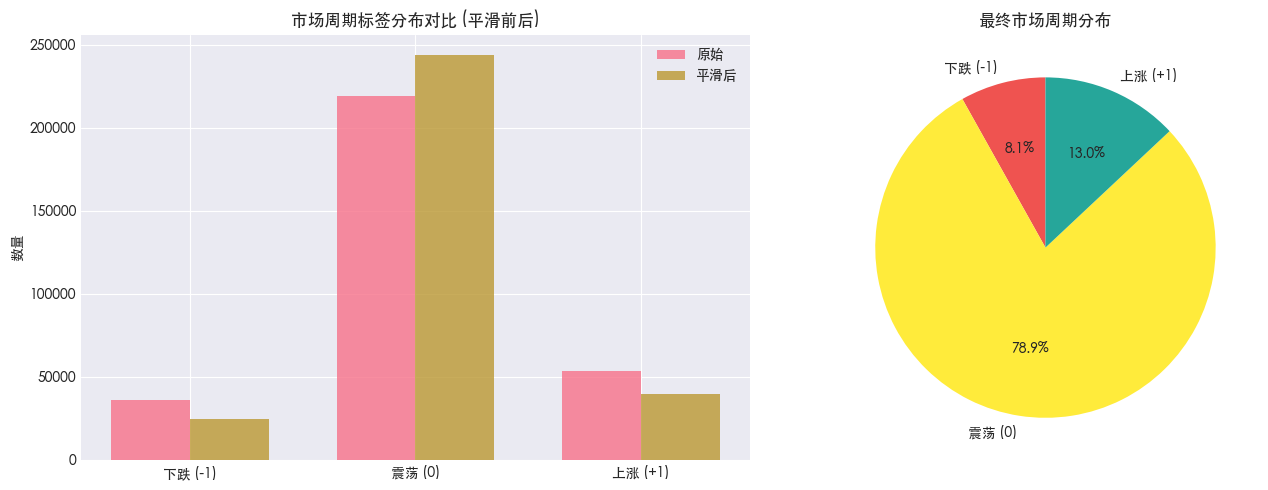


Cell 10 完成 ✅


In [16]:
# ========== Cell 10: 市场周期标签 - Step 3: 标签平滑 ==========

# 强制用我们在 Cell 1 里发现的 Mac 中文字体
mpl.rcParams['font.family'] = 'sans-serif' 
mpl.rcParams['font.sans-serif'] = ['Heiti TC'] # 和 Cell 1 打印出来的名字一致 
mpl.rcParams['axes.unicode_minus'] = False 
print("当前字体配置:", mpl.rcParams['font.sans-serif'])

def smooth_regime_labels(regime: np.ndarray, 
                         min_trend_len: int,
                         smooth_window: int) -> np.ndarray:
    """
    对标签序列进行平滑处理
    
    步骤:
    1. 删除太短的趋势段 (长度 < min_trend_len 的 ±1 段改为 0)
    2. 多数投票平滑
    
    参数:
        regime: 原始标签数组 (-1, 0, 1)
        min_trend_len: 最小趋势段长度
        smooth_window: 平滑窗口大小
    
    返回:
        smoothed: 平滑后的标签数组
    """
    n = len(regime)
    result = regime.copy()
    
    # Step 1: 删除太短的趋势段
    i = 0
    while i < n:
        if result[i] != 0:  # 趋势段
            # 找连续段的结束
            j = i + 1
            while j < n and result[j] == result[i]:
                j += 1
            
            seg_len = j - i
            if seg_len < min_trend_len:
                # 太短，改为 0 (震荡)
                result[i:j] = 0
            
            i = j
        else:
            i += 1
    
    # Step 2: 多数投票平滑 (中值滤波的变体)
    half_win = smooth_window // 2
    smoothed = result.copy()
    
    for i in range(n):
        start = max(0, i - half_win)
        end = min(n, i + half_win + 1)
        window = result[start:end]
        
        # 统计每个标签的出现次数
        counts = {-1: 0, 0: 0, 1: 0}
        for v in window:
            counts[v] = counts.get(v, 0) + 1
        
        # 找出最多的标签
        max_count = max(counts.values())
        candidates = [k for k, v in counts.items() if v == max_count]
        
        # 如果有多个候选，优先保持原值或取 0
        if len(candidates) == 1:
            smoothed[i] = candidates[0]
        elif result[i] in candidates:
            smoothed[i] = result[i]
        else:
            smoothed[i] = 0
    
    return smoothed


# 应用平滑
print(f"标签平滑 (min_trend_len={MIN_TREND_LEN}, smooth_window={SMOOTH_WINDOW})...")
regime_smoothed = smooth_regime_labels(
    df["regime_raw"].values,
    min_trend_len=MIN_TREND_LEN,
    smooth_window=SMOOTH_WINDOW
)

df["regime"] = regime_smoothed

# 最终统计
regime_counts_final = pd.Series(regime_smoothed).value_counts().sort_index()
print("\n=== 最终 Market Cycle 标签分布 ===")
total = len(df)
for k, v in regime_counts_final.items():
    label_name = {-1: "DOWN (-1)", 0: "RANGE (0)", 1: "UP (+1)"}.get(k, str(k))
    print(f"  {label_name}: {v:,} ({v / total:.2%})")

# 与 Al Brooks 80/20 规则对比
range_pct = regime_counts_final.get(0, 0) / total
trend_pct = (regime_counts_final.get(-1, 0) + regime_counts_final.get(1, 0)) / total
print(f"\n震荡区间比例: {range_pct:.2%} (Al Brooks: ~80%)")
print(f"趋势区间比例: {trend_pct:.2%} (Al Brooks: ~20%)")

# 可视化对比
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 原始 vs 平滑后的分布
regime_counts_raw_series = pd.Series(df["regime_raw"].values).value_counts().sort_index()

width = 0.35
x = np.arange(3)
labels = ["下跌 (-1)", "震荡 (0)", "上涨 (+1)"]


axes[0].bar(x - width/2, [regime_counts_raw_series.get(k, 0) for k in [-1, 0, 1]], 
            width, label="原始", alpha=0.8)
axes[0].bar(x + width/2, [regime_counts_final.get(k, 0) for k in [-1, 0, 1]], 
            width, label="平滑后", alpha=0.8)
axes[0].set_xticks(x)
axes[0].set_xticklabels(labels)
axes[0].set_ylabel("数量")
axes[0].set_title("市场周期标签分布对比 (平滑前后)")
axes[0].legend()

# 饼图
colors = ["#ef5350", "#ffeb3b", "#26a69a"]
sizes = [regime_counts_final.get(k, 0) for k in [-1, 0, 1]]
axes[1].pie(sizes, labels=labels, colors=colors, autopct="%1.1f%%", startangle=90)
axes[1].set_title("最终市场周期分布")

plt.tight_layout()
plt.show()

print("\nCell 10 完成 ✅")


In [17]:
# ========== Cell 11: Bokeh K线图可视化函数定义 ==========

def plot_kline_with_regime(df_day: pd.DataFrame, title: str = "K-line with Market Regime") -> figure:
    """
    绘制单日 K 线图，并在背景上填充 market regime 颜色
    
    颜色映射:
    - DOWN (-1): 浅红色
    - RANGE (0): 浅黄色  
    - UP (+1): 浅绿色
    
    Args:
        df_day: 单日的 K 线数据 DataFrame，需包含:
                timestamp_dt, open, high, low, close, regime
        title: 图表标题
    
    Returns:
        Bokeh figure 对象
    """
    df_day = df_day.copy().reset_index(drop=True)
    
    # 计算 K 线的涨跌颜色
    df_day["color"] = df_day.apply(
        lambda row: "#26a69a" if row["close"] >= row["open"] else "#ef5350",
        axis=1
    )
    
    # K 线宽度（毫秒，5 分钟 K 线用 4 分钟宽度）
    w = 4 * 60 * 1000  # 4 minutes in milliseconds
    
    # 创建 ColumnDataSource
    source = ColumnDataSource(data={
        "timestamp": df_day["timestamp_dt"],
        "open": df_day["open"],
        "high": df_day["high"],
        "low": df_day["low"],
        "close": df_day["close"],
        "color": df_day["color"],
        "regime": df_day["regime"].fillna(0).astype(int),
    })
    
    # 计算 Y 轴范围
    y_min = df_day["low"].min() * 0.9995
    y_max = df_day["high"].max() * 1.0005
    
    # 创建 figure
    p = figure(
        title=title,
        x_axis_type="datetime",
        width=1200,
        height=500,
        y_range=Range1d(y_min, y_max),
        tools="pan,wheel_zoom,box_zoom,reset,save",
        background_fill_color="#fafafa",
    )
    
    # ---- 添加 regime 背景色块 ----
    regime_colors = {
        -1: "#ffcccc",  # DOWN - 浅红色
        0: "#ffffcc",   # RANGE - 浅黄色
        1: "#ccffcc",   # UP - 浅绿色
    }
    
    # 找出连续相同 regime 的区间
    df_day["regime_filled"] = df_day["regime"].fillna(0).astype(int)
    df_day["regime_change"] = (df_day["regime_filled"] != df_day["regime_filled"].shift()).cumsum()
    
    regime_groups = df_day.groupby("regime_change").agg({
        "timestamp_dt": ["first", "last"],
        "regime_filled": "first"
    })
    regime_groups.columns = ["start_time", "end_time", "regime"]
    
    # 为每个 regime 区间添加背景
    for _, row in regime_groups.iterrows():
        regime = int(row["regime"])
        if regime in regime_colors:
            start = row["start_time"]
            end = row["end_time"] + pd.Timedelta(minutes=5)
            
            box = BoxAnnotation(
                left=start,
                right=end,
                fill_color=regime_colors[regime],
                fill_alpha=0.4,
                level="underlay",
            )
            p.add_layout(box)
    
    # ---- 绘制 K 线 ----
    # 影线
    p.segment(
        x0="timestamp", y0="high",
        x1="timestamp", y1="low",
        source=source,
        color="black",
        line_width=1,
    )
    
    # K 线实体
    p.vbar(
        x="timestamp",
        width=w,
        top="open",
        bottom="close",
        source=source,
        fill_color="color",
        line_color="black",
        line_width=0.5,
    )
    
    # ---- 添加 HoverTool ----
    hover = HoverTool(
        tooltips=[
            ("时间", "@timestamp{%Y-%m-%d %H:%M}"),
            ("开", "@open{0.2f}"),
            ("高", "@high{0.2f}"),
            ("低", "@low{0.2f}"),
            ("收", "@close{0.2f}"),
            ("Regime", "@regime (-1=DOWN, 0=RANGE, 1=UP)"),
        ],
        formatters={"@timestamp": "datetime"},
        mode="vline",
    )
    p.add_tools(hover)
    
    # 设置轴标签
    p.xaxis.axis_label = "Time"
    p.yaxis.axis_label = "Price"
    p.xaxis.major_label_orientation = 0.8
    
    return p


def plot_multiday_kline(df_multi: pd.DataFrame, title: str = "Multi-Day K-line", 
                        width: int = 2400, height: int = 600) -> figure:
    """
    绘制连续多日 K 线图，移除休盘时间的空隙
    使用 index-based x 轴
    """
    df = df_multi.copy().reset_index(drop=True)
    df["idx"] = df.index
    
    # K 线涨跌颜色
    df["color"] = df.apply(
        lambda row: "#26a69a" if row["close"] >= row["open"] else "#ef5350",
        axis=1
    )
    
    # 格式化时间标签
    df["time_label"] = df["timestamp_dt"].dt.strftime("%m-%d %H:%M")
    df["date_str"] = df["date"].astype(str)
    
    bar_width = 0.6
    
    # ColumnDataSource
    source = ColumnDataSource(data={
        "idx": df["idx"],
        "timestamp": df["timestamp_dt"],
        "open": df["open"],
        "high": df["high"],
        "low": df["low"],
        "close": df["close"],
        "color": df["color"],
        "regime": df["regime"].fillna(0).astype(int),
        "date_str": df["date_str"],
        "time_label": df["time_label"],
    })
    
    # Y 轴范围
    y_min = df["low"].min() * 0.998
    y_max = df["high"].max() * 1.002
    
    # 创建 figure
    p = figure(
        title=title,
        width=width,
        height=height,
        y_range=Range1d(y_min, y_max),
        tools="pan,wheel_zoom,box_zoom,reset,save,crosshair",
        background_fill_color="#fafafa",
    )
    
    p.x_range.range_padding = 0.01
    
    # ---- 添加 regime 背景色块 ----
    regime_colors = {
        -1: "#ffcccc",  # DOWN
        0: "#ffffcc",   # RANGE
        1: "#ccffcc",   # UP
    }
    
    df["regime_filled"] = df["regime"].fillna(0).astype(int)
    df["regime_change"] = (df["regime_filled"] != df["regime_filled"].shift()).cumsum()
    
    regime_groups = df.groupby("regime_change").agg({
        "idx": ["first", "last"],
        "regime_filled": "first"
    })
    regime_groups.columns = ["start_idx", "end_idx", "regime"]
    
    for _, row in regime_groups.iterrows():
        regime = int(row["regime"])
        if regime in regime_colors:
            start = row["start_idx"] - 0.5
            end = row["end_idx"] + 0.5
            
            box = BoxAnnotation(
                left=start,
                right=end,
                fill_color=regime_colors[regime],
                fill_alpha=0.4,
                level="underlay",
            )
            p.add_layout(box)
    
    # ---- 添加日期分割线 ----
    unique_dates = df["date"].unique()
    for i, date in enumerate(unique_dates):
        if i == 0:
            continue
        
        first_bar_idx = df[df["date"] == date]["idx"].min()
        
        vline = Span(
            location=first_bar_idx - 0.5,
            dimension="height",
            line_color="gray",
            line_dash="dashed",
            line_width=1.5,
            line_alpha=0.7,
        )
        p.add_layout(vline)
        
        label = Label(
            x=first_bar_idx + 5,
            y=y_max * 0.999,
            text=str(date),
            text_font_size="10pt",
            text_color="gray",
            text_align="left",
        )
        p.add_layout(label)
    
    # ---- 绘制 K 线 ----
    p.segment(
        x0="idx", y0="high",
        x1="idx", y1="low",
        source=source,
        color="black",
        line_width=1,
    )
    
    p.vbar(
        x="idx",
        width=bar_width,
        top="open",
        bottom="close",
        source=source,
        fill_color="color",
        line_color="black",
        line_width=0.5,
    )
    
    # ---- X 轴标签 ----
    tick_interval = 12  # 约 1 小时
    tick_indices = list(range(0, len(df), tick_interval))
    
    p.xaxis.ticker = tick_indices
    p.xaxis.major_label_overrides = {
        i: df.loc[i, "time_label"] for i in tick_indices if i < len(df)
    }
    p.xaxis.major_label_orientation = 0.8
    
    # ---- HoverTool ----
    hover = HoverTool(
        tooltips=[
            ("日期", "@date_str"),
            ("时间", "@time_label"),
            ("开", "@open{0.2f}"),
            ("高", "@high{0.2f}"),
            ("低", "@low{0.2f}"),
            ("收", "@close{0.2f}"),
            ("Regime", "@regime (-1=DOWN, 0=RANGE, 1=UP)"),
        ],
        mode="vline",
    )
    p.add_tools(hover)
    
    p.xaxis.axis_label = "Time"
    p.yaxis.axis_label = "Price"
    p.title.text_font_size = "14pt"
    
    return p


print("Bokeh 绑定函数已定义:")
print("  - plot_kline_with_regime(df_day, title)")
print("  - plot_multiday_kline(df_multi, title, width, height)")
print("\nCell 11 完成 ✅")


Bokeh 绑定函数已定义:
  - plot_kline_with_regime(df_day, title)
  - plot_multiday_kline(df_multi, title, width, height)

Cell 11 完成 ✅


In [18]:
# ========== Cell 12: 随机选取单日 K线图可视化 ==========
import random

# 准备绘图数据
df_plot = df.copy().reset_index()
df_plot["timestamp_dt"] = pd.to_datetime(df_plot["timestamp"].astype(str).str.slice(0, 19))
df_plot["date"] = df_plot["timestamp_dt"].dt.date

# 获取所有有效的交易日 (有 regime 标签)
valid_dates = df_plot[df_plot["regime"].notna()]["date"].unique()
print(f"有效交易日总数: {len(valid_dates)}")

# 随机选取 10 个交易日
NUM_DAYS = 10
random.seed(42)
selected_dates = sorted(random.sample(list(valid_dates), min(NUM_DAYS, len(valid_dates))))

print(f"\n选取的 {len(selected_dates)} 个交易日:")
for d in selected_dates:
    print(f"  - {d}")


# 绘制每天的图表
plots = []
for date in selected_dates:
    df_day = df_plot[df_plot["date"] == date].copy()
    
    if len(df_day) == 0:
        print(f"  [跳过] {date}: 无数据")
        continue
    
    # 统计当天的 regime 分布
    regime_counts = df_day["regime"].value_counts()
    regime_str = ", ".join([f"{k}:{v}" for k, v in sorted(regime_counts.items())])
    
    title = f"ES 5min - {date} | Regime分布: {regime_str} | DOWN=浅红, RANGE=浅黄, UP=浅绿"
    p = plot_kline_with_regime(df_day, title=title)
    plots.append(p)
    print(f"  [完成] {date}: {len(df_day)} 根 K 线")

# 显示图表
if plots:
    layout = column(*plots)
    show(layout)
    
    # 保存 HTML 到 charts 目录
    chart_path = OUTPUT_DIR_CHARTS / "market_cycle_random_days.html"
    output_file(str(chart_path))
    save(layout, filename=str(chart_path), title="Market Cycle - Random Days")
    print(f"\n图表已保存到: {chart_path}")

print("\nCell 12 完成 ✅")


有效交易日总数: 3976

选取的 10 个交易日:
  - 2010-10-27
  - 2012-01-19
  - 2012-03-12
  - 2012-08-21
  - 2014-01-02
  - 2014-05-12
  - 2014-11-06
  - 2020-08-25
  - 2022-03-09
  - 2022-04-07
  [完成] 2010-10-27: 79 根 K 线
  [完成] 2012-01-19: 79 根 K 线
  [完成] 2012-03-12: 79 根 K 线
  [完成] 2012-08-21: 79 根 K 线
  [完成] 2014-01-02: 79 根 K 线
  [完成] 2014-05-12: 79 根 K 线
  [完成] 2014-11-06: 79 根 K 线
  [完成] 2020-08-25: 79 根 K 线
  [完成] 2022-03-09: 79 根 K 线
  [完成] 2022-04-07: 79 根 K 线



图表已保存到: market_cycle/charts/market_cycle_random_days.html

Cell 12 完成 ✅


In [43]:
# ========== Cell 13: 连续多日 K线图可视化 ==========

# 配置
NUM_CONSECUTIVE_DAYS = 10
CHART_WIDTH = 2400
CHART_HEIGHT = 600

# 可以指定起始日期，或随机选择
START_MODE = "random"  # "random" 或 "specific"
SPECIFIC_START_DATE = "2023-10-01"

# 获取有效交易日列表
valid_dates_sorted = sorted(df_plot[df_plot["regime"].notna()]["date"].unique())
print(f"有效交易日总数: {len(valid_dates_sorted)}")

# 选择连续的交易日
if START_MODE == "specific":
    from datetime import datetime
    target_start = datetime.strptime(SPECIFIC_START_DATE, "%Y-%m-%d").date()
    if target_start in valid_dates_sorted:
        start_idx = valid_dates_sorted.index(target_start)
    else:
        later_dates = [d for d in valid_dates_sorted if d >= target_start]
        start_idx = valid_dates_sorted.index(later_dates[0]) if later_dates else 0
    print(f"指定起始日期: {SPECIFIC_START_DATE}")
else:
    random.seed(123)
    max_start_idx = len(valid_dates_sorted) - NUM_CONSECUTIVE_DAYS
    start_idx = random.randint(0, max(0, max_start_idx))
    print(f"随机选择起始索引: {start_idx}")

end_idx = min(start_idx + NUM_CONSECUTIVE_DAYS, len(valid_dates_sorted))
consecutive_dates = valid_dates_sorted[start_idx:end_idx]

print(f"\n选取的 {len(consecutive_dates)} 个连续交易日:")
print(f"  起始: {consecutive_dates[0]}")
print(f"  结束: {consecutive_dates[-1]}")

# 筛选数据
df_multi = df_plot[df_plot["date"].isin(consecutive_dates)].copy()
df_multi = df_multi.sort_values("timestamp_dt").reset_index(drop=True)
print(f"\n总 K 线数: {len(df_multi)}")

# 统计 regime 分布
regime_multi_counts = df_multi["regime"].value_counts().sort_index()
print("\n连续多日 Regime 分布:")
for k, v in regime_multi_counts.items():
    label_name = {-1: "DOWN (-1)", 0: "RANGE (0)", 1: "UP (+1)"}.get(k, str(k))
    print(f"  {label_name}: {v} ({v / len(df_multi):.2%})")

# 绘制多日连续图
title = f"ES 5min ({consecutive_dates[0]} ~ {consecutive_dates[-1]}) | DOWN=浅红, RANGE=浅黄, UP=浅绿"
p_multi = plot_multiday_kline(df_multi, title=title, width=CHART_WIDTH, height=CHART_HEIGHT)

show(p_multi)

# 保存 HTML 到 charts 目录
chart_path = OUTPUT_DIR_CHARTS / "market_cycle_multiday.html"
output_file(str(chart_path))
save(p_multi, filename=str(chart_path), title="Market Cycle - Multi-Day")
print(f"\n连续多日图表已保存到: {chart_path}")

print("\nCell 13 完成 ✅")



有效交易日总数: 3976
随机选择起始索引: 214

选取的 10 个连续交易日:
  起始: 2011-04-04
  结束: 2011-04-15

总 K 线数: 790

连续多日 Regime 分布:
  DOWN (-1): 59 (7.47%)
  RANGE (0): 665 (84.18%)
  UP (+1): 66 (8.35%)


0:169: execution error: 找不到文件“某个对象”。 (-43)



连续多日图表已保存到: market_cycle/charts/market_cycle_multiday.html

Cell 13 完成 ✅


In [47]:
# ========== Cell 14: 自定义日期 K线图可视化 ==========
# 修改 custom_dates 列表来查看特定日期

from datetime import datetime

custom_dates = [
    "2023-03-29",
    "2023-07-20",
    "2024-02-19",
    "2024-03-13",
    "2025-09-29",
]

# 转换为 date 类型
custom_dates_parsed = [datetime.strptime(d, "%Y-%m-%d").date() for d in custom_dates]

# 过滤有效日期
valid_custom_dates = [d for d in custom_dates_parsed if d in set(valid_dates_sorted)]
invalid_dates = [d for d in custom_dates_parsed if d not in set(valid_dates_sorted)]

if invalid_dates:
    print(f"[警告] 以下日期无有效数据，将被跳过: {invalid_dates}")

if not valid_custom_dates:
    print("[错误] 没有有效的自定义日期可绘制。")
else:
    print(f"将绘制以下 {len(valid_custom_dates)} 个自定义日期:")
    for d in valid_custom_dates:
        print(f"  - {d}")
    
    # 绘制图表
    custom_plots = []
    for date in valid_custom_dates:
        df_day = df_plot[df_plot["date"] == date].copy()
        
        if len(df_day) == 0:
            print(f"  [跳过] {date}: 无数据")
            continue
        
        # 统计当天的 regime 分布
        regime_counts = df_day["regime"].value_counts()
        regime_str = ", ".join([f"{k}:{v}" for k, v in sorted(regime_counts.items())])
        
        title = f"ES 5min - {date} | Regime分布: {regime_str} | DOWN=浅红, RANGE=浅黄, UP=浅绿"
        p = plot_kline_with_regime(df_day, title=title)
        custom_plots.append(p)
        print(f"  [完成] {date}: {len(df_day)} 根 K 线")
    
    if custom_plots:
        custom_layout = column(*custom_plots)
        show(custom_layout)
        
        # 保存 HTML 到 charts 目录
        chart_path = OUTPUT_DIR_CHARTS / "market_cycle_custom_dates.html"
        output_file(str(chart_path))
        save(custom_layout, filename=str(chart_path), title="Market Cycle - Custom Dates")
        print(f"\n自定义日期图表已保存到: {chart_path}")

print("\nCell 14 完成 ✅")


将绘制以下 5 个自定义日期:
  - 2023-03-29
  - 2023-07-20
  - 2024-02-19
  - 2024-03-13
  - 2025-09-29
  [完成] 2023-03-29: 79 根 K 线
  [完成] 2023-07-20: 79 根 K 线
  [完成] 2024-02-19: 42 根 K 线
  [完成] 2024-03-13: 79 根 K 线
  [完成] 2025-09-29: 79 根 K 线


0:169: execution error: 找不到文件“某个对象”。 (-43)



自定义日期图表已保存到: market_cycle/charts/market_cycle_custom_dates.html

Cell 14 完成 ✅


In [22]:
# ========== Cell 15: 导出标注数据与特征矩阵 ==========

# 选择要导出的特征列
feature_cols = [
    "log_return",       # 对数收益
    "atr",              # ATR
    "range_atr",        # 相对区间
    "er",               # 效率因子
    "kama",             # KAMA
    "slope_norm",       # KAMA 斜率标准化
    "dist_norm",        # 价格偏离度标准化
    "beta",             # 回归斜率
    "r2",               # R²
    "chop",             # Choppiness Index (基于ATR)
    "overlap_ratio",    # Bar 重叠度
    "d_barrier",        # Triple Barrier 方向标签
]

# 额外的价格和时间特征
extra_cols = [
    "open", "high", "low", "close", "volume",
]

# 标签列
label_cols = [
    "regime",           # 最终市场周期标签
    "regime_raw",       # 原始标签 (未平滑)
    "is_range",         # 是否为震荡区间 (布尔)
    "is_range_shrunk",  # 收缩后的震荡区间
]

# 构建导出 DataFrame
df_export = df[extra_cols + feature_cols + label_cols].copy()
df_export = df_export.reset_index()

# 添加年份和日期列
df_export["timestamp_dt"] = pd.to_datetime(df_export["timestamp"].astype(str).str.slice(0, 19))
df_export["year"] = df_export["timestamp_dt"].dt.year
df_export["date"] = df_export["timestamp_dt"].dt.date

# 过滤掉 NaN 样本 (warm-up 期)
df_valid = df_export.dropna(subset=["regime"])
print(f"有效样本数: {len(df_valid)} / {len(df_export)} ({len(df_valid) / len(df_export):.2%})")

# 统计最终标签分布
final_counts = df_valid["regime"].value_counts().sort_index()
print("\n=== 最终导出数据的 Regime 分布 ===")
for k, v in final_counts.items():
    label_name = {-1: "DOWN (-1)", 0: "RANGE (0)", 1: "UP (+1)"}.get(k, str(k))
    print(f"  {label_name}: {v:,} ({v / len(df_valid):.2%})")

# 按年份统计
print("\n=== 按年份统计 ===")
year_stats = df_valid.groupby("year")["regime"].value_counts().unstack(fill_value=0)
year_stats["total"] = year_stats.sum(axis=1)
display(year_stats)

# 保存为 CSV 和 Parquet 到 data 目录
OUTPUT_CSV = OUTPUT_DIR_DATA / "market_cycle_labeled_data.csv"
OUTPUT_PARQUET = OUTPUT_DIR_DATA / "market_cycle_labeled_data.parquet"

df_valid.to_csv(OUTPUT_CSV, index=False)
df_valid.to_parquet(OUTPUT_PARQUET, index=False)

print(f"\n数据已导出:")
print(f"  - CSV: {OUTPUT_CSV}")
print(f"  - Parquet: {OUTPUT_PARQUET}")

# 构建用于模型训练的特征矩阵 X 和标签 y
X = df_valid[feature_cols].copy()
y = df_valid["regime"].astype(int).copy()

print(f"\n=== 模型训练数据 ===")
print(f"特征矩阵 X shape: {X.shape}")
print(f"标签 y shape: {y.shape}")
print(f"特征列: {feature_cols}")

# 检查特征的基本统计
print("\n特征统计:")
display(X.describe())

print("\nCell 15 完成 ✅")


有效样本数: 309412 / 309412 (100.00%)

=== 最终导出数据的 Regime 分布 ===
  DOWN (-1): 25,109 (8.12%)
  RANGE (0): 244,054 (78.88%)
  UP (+1): 40,249 (13.01%)

=== 按年份统计 ===


regime,-1,0,1,total
year,,,,
2010,661,9531,1380,11572
2011,1795,15838,2385,20018
2012,1699,15720,2350,19769
2013,1347,15887,2572,19806
2014,1619,15519,2363,19501
2015,1764,15894,2435,20093
2016,1616,16179,2331,20126
2017,1078,16507,2428,20013
2018,1855,15493,2633,19981



数据已导出:
  - CSV: market_cycle/data/market_cycle_labeled_data.csv
  - Parquet: market_cycle/data/market_cycle_labeled_data.parquet

=== 模型训练数据 ===
特征矩阵 X shape: (309412, 12)
标签 y shape: (309412,)
特征列: ['log_return', 'atr', 'range_atr', 'er', 'kama', 'slope_norm', 'dist_norm', 'beta', 'r2', 'chop', 'overlap_ratio', 'd_barrier']

特征统计:


,log_return,atr,range_atr,er,kama,slope_norm,dist_norm,beta,r2,chop,overlap_ratio,d_barrier
count,309411.000000,309411.000000,309393.000000,309392.000000,309402.000000,309397.000000,309402.000000,309393.000000,3.093930e+05,309398.000000,309392.000000,309412.00000
mean,0.000006,3.698546,3.756450,0.238839,2979.158538,0.014694,0.097139,0.000006,4.349979e-01,0.505683,0.599972,0.05535
std,0.001216,3.335959,1.562644,0.173331,1465.977769,0.185352,1.101335,0.000281,2.929586e-01,0.107330,0.054577,0.99051
min,-0.071205,0.346148,0.138900,0.000000,1012.234950,-1.663501,-5.453387,-0.005148,8.751888e-13,0.048165,0.303707,-1.00000
25%,-0.000368,1.604902,2.669351,0.097561,1867.066945,-0.046135,-0.678319,-0.000091,1.536626e-01,0.435240,0.564432,-1.00000
50%,0.000000,2.597806,3.426552,0.206897,2647.060430,0.005635,0.149963,0.000014,4.468311e-01,0.513269,0.600788,1.00000
75%,0.000383,4.684211,4.476464,0.348837,4112.008229,0.076469,0.884750,0.000110,6.987168e-01,0.582532,0.636578,1.00000
max,0.067505,76.226612,18.311768,1.000000,6939.605558,1.547626,5.009337,0.005267,9.892182e-01,0.979137,0.873231,1.00000



Cell 15 完成 ✅


In [27]:
# ========== Cell 16: 特征归一化 (Rolling Z-Score Normalization) ==========
'''
📌 归一化策略:
   1. 对绝对量纲特征 (atr, tr, bar_range, volume) 进行滚动 Z-score 归一化
   2. 已经是比例/有界的特征 (er, chop, body_ratio 等) 不需要额外处理
   3. 删除原始尺度特征，只保留归一化版本
   
📌 设计原则:
   - 每个 t 只使用过去 W 根 bar 的统计量，不看未来
   - σ 很小时 (< eps) 置为 0，避免数值爆炸
   - 前 W-1 根 bar 的归一化值设为 NaN，后续过滤掉
'''
print("=" * 70)
print("🔧 特征归一化处理")
print("=" * 70)

# ═══════════════════════════════════════════════════════════════════════════════
# 滚动归一化参数
# ═══════════════════════════════════════════════════════════════════════════════

NORM_WINDOW = 100  # 滚动窗口大小 (~8小时 RTH)
EPS = 1e-8         # 避免除零

# ========== 1. 定义需要归一化的特征 ==========
RAW_SCALE_FEATURES = ["atr", "tr", "bar_range", "volume"]

# ========== 2. 滚动 Z-Score 归一化函数 ==========
def rolling_zscore(series: pd.Series, window: int, eps: float = 1e-8) -> pd.Series:
    '''
    滚动 Z-Score 归一化
    z_t = (x_t - μ_t) / σ_t
    其中 μ_t, σ_t 是过去 window 根 bar 的均值和标准差
    '''
    roll_mean = series.rolling(window=window, min_periods=window).mean()
    roll_std = series.rolling(window=window, min_periods=window).std()
    roll_std = roll_std.replace(0, np.nan).clip(lower=eps)
    zscore = (series - roll_mean) / roll_std
    return zscore

# ========== 3. 对绝对量纲特征进行滚动归一化 ==========
print("\n对绝对量纲特征进行滚动 Z-Score 归一化...")

# ✅ 确保 bar_range 已定义（避免依赖 Cell 18）
if "bar_range" not in df.columns:
    df["bar_range"] = df["high"] - df["low"]


for feat in RAW_SCALE_FEATURES:
    if feat in df.columns:
        norm_col = f"{feat}_z"
        df[norm_col] = rolling_zscore(df[feat], NORM_WINDOW, EPS)
        valid_count = df[norm_col].notna().sum()
        print(f"  {feat} → {norm_col}: mean={df[norm_col].mean():.4f}, std={df[norm_col].std():.4f}, valid={valid_count:,}")

# ========== 4. KAMA 特殊处理 ==========
if "kama" in df.columns:
    df["kama_z"] = rolling_zscore(df["kama"], NORM_WINDOW, EPS)
    print(f"  kama → kama_z: mean={df['kama_z'].mean():.4f}, std={df['kama_z'].std():.4f}")

# ========== 5. Volume 特殊处理 ==========
if "volume" in df.columns:
    df["log_volume"] = np.log1p(df["volume"])
    df["log_volume_z"] = rolling_zscore(df["log_volume"], NORM_WINDOW, EPS)
    print(f"  volume → log_volume_z: mean={df['log_volume_z'].mean():.4f}, std={df['log_volume_z'].std():.4f}")

# ========== 6. 统计归一化后的特征分布 ==========
print("\n" + "=" * 70)
print("📊 归一化特征统计")
print("=" * 70)

new_norm_features = [c for c in df.columns if c.endswith("_z") and c not in ["range_z", "range_z_ma5"]]
print(f"\n新增归一化特征: {len(new_norm_features)}")
for col in new_norm_features[:10]:
    stats = df[col].describe()
    print(f"  {col}: min={stats['min']:.2f}, max={stats['max']:.2f}, mean={stats['mean']:.4f}")

# ========== 7. 定义要从训练中排除的原始尺度特征 ==========
FEATURES_TO_EXCLUDE_FROM_TRAINING = [
    "kama",       # 原始价格尺度 → 使用 dist_norm 或 kama_z
    "atr",        # 原始波动幅度 → 使用 range_atr 或 atr_z  
    "tr",         # 原始 True Range → 使用 atr_z
    "bar_range",  # 原始 bar 高低价差 → 使用 range_z
    "d_barrier",  # 泄露未来信息
    "regime_raw",
    "is_range",
    "is_range_extended", # 现在改用内缩函数了，不会再向外延伸
    "is_range_shrunk",
    "is_range_in_trend",
]

print(f"\n⚠️ 以下特征将从训练集中排除:")
for f in FEATURES_TO_EXCLUDE_FROM_TRAINING:
    print(f"  - {f}")

print("\nCell 16 完成: 特征归一化 ✅")

🔧 特征归一化处理

对绝对量纲特征进行滚动 Z-Score 归一化...
  atr → atr_z: mean=-0.0404, std=1.1655, valid=309,312
  tr → tr_z: mean=-0.0250, std=0.9968, valid=309,312
  bar_range → bar_range_z: mean=-0.0114, std=1.0393, valid=309,313
  volume → volume_z: mean=-0.0285, std=0.9665, valid=309,313
  kama → kama_z: mean=0.1654, std=1.5297
  volume → log_volume_z: mean=-0.0387, std=1.0139

📊 归一化特征统计

新增归一化特征: 6
  atr_z: min=-3.32, max=8.92, mean=-0.0404
  tr_z: min=-2.47, max=9.81, mean=-0.0250
  volume_z: min=-1.94, max=9.31, mean=-0.0285
  kama_z: min=-7.91, max=7.08, mean=0.1654
  log_volume_z: min=-7.93, max=5.53, mean=-0.0387
  bar_range_z: min=-2.54, max=9.74, mean=-0.0114

⚠️ 以下特征将从训练集中排除:
  - kama
  - atr
  - tr
  - bar_range
  - d_barrier
  - regime_raw
  - is_range
  - is_range_extended
  - is_range_shrunk
  - is_range_in_trend

Cell 16 完成: 特征归一化 ✅


计算多尺度趋势特征...

=== 多尺度趋势特征统计 ===
slope_10_norm: mean=0.0005, std=0.0104
slope_30_norm: mean=0.0007, std=0.0065
slope_60_norm: mean=0.0008, std=0.0055

trend_alignment 分布:
  -3 (强下跌): 57,428 (18.6%)
  -1 (分歧): 80,370 (26.0%)
  +1 (分歧): 89,474 (28.9%)
  +2 (弱上涨): 2 (0.0%)
  +3 (强上涨): 82,079 (26.5%)


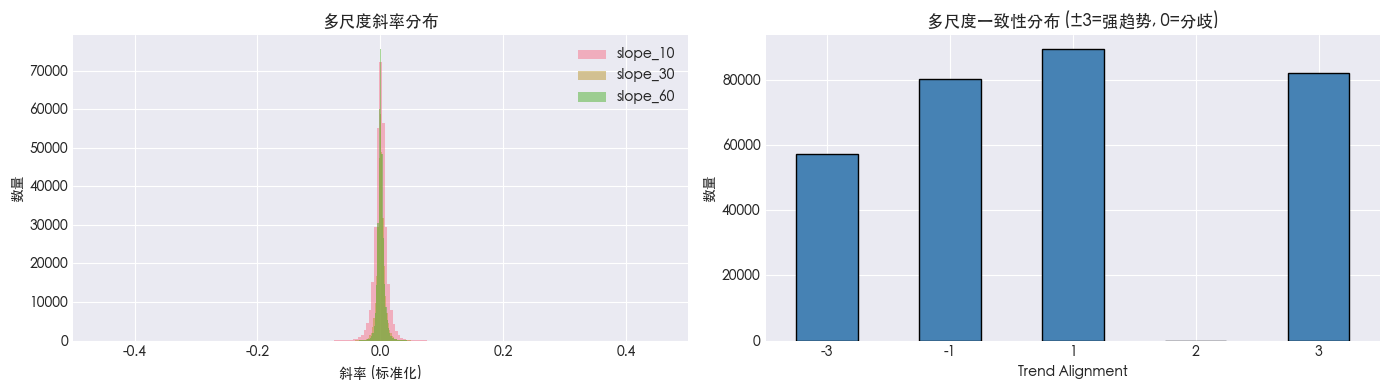


Cell 17 完成: 多尺度趋势特征 ✅


In [28]:
# ========== Cell 17: 多尺度趋势特征 (Multi-Scale Trend Features) ==========
"""
📌 1.1(a) 多尺度趋势强度 / "趋势能量"
   - 不同窗口的 log_close 斜率: slope_short (10), slope_mid (30), slope_long (60)
   - 多尺度一致性指标: trend_alignment = sign(slope_10) + sign(slope_30) + sign(slope_60)
     - 接近 +3/-3: 多尺度趋势同向
     - 接近 0: 分歧多，结构不清晰（更像 trading range 边缘）
"""
print("计算多尺度趋势特征...")

# 多尺度斜率窗口定义
SLOPE_WINDOWS = [10, 30, 60]

def calc_rolling_slope(log_close: pd.Series, window: int) -> pd.Series:
    """
    计算滚动线性回归斜率 (对 log_close)
    使用简化的最小二乘法
    """
    def linreg_slope(y):
        if len(y) < window or np.any(np.isnan(y)):
            return np.nan
        x = np.arange(len(y))
        x_mean = x.mean()
        y_mean = y.mean()
        ss_xy = ((x - x_mean) * (y - y_mean)).sum()
        ss_x = ((x - x_mean) ** 2).sum()
        return ss_xy / ss_x if ss_x > 0 else 0
    
    return log_close.rolling(window=window).apply(linreg_slope, raw=True)


# 计算不同窗口的斜率
for w in SLOPE_WINDOWS:
    col_name = f"slope_{w}"
    df[col_name] = calc_rolling_slope(df["log_close"], w)
    # 标准化 (相对 ATR)
    df[f"{col_name}_norm"] = df[col_name] / df["atr"].replace(0, np.nan) * 100  # 放大显示
# slope10>0,最近10根bar上涨趋势
# slope60<0,最近60根bar下跌趋势

# 多尺度一致性指标
df["trend_alignment"] = (
    np.sign(df["slope_10"]) + 
    np.sign(df["slope_30"]) + 
    np.sign(df["slope_60"])
)

# 统计
print("\n=== 多尺度趋势特征统计 ===")
for w in SLOPE_WINDOWS:
    col = f"slope_{w}_norm"
    print(f"slope_{w}_norm: mean={df[col].mean():.4f}, std={df[col].std():.4f}")

alignment_counts = df["trend_alignment"].value_counts().sort_index()
print(f"\ntrend_alignment 分布:")
for k, v in alignment_counts.items():
    pct = v / len(df) * 100
    label = {-3: "强下跌", -2: "弱下跌", -1: "分歧", 0: "无方向", 
             1: "分歧", 2: "弱上涨", 3: "强上涨"}.get(int(k), str(k))
    print(f"  {int(k):+d} ({label}): {v:,} ({pct:.1f}%)")


# 可视化
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# 多尺度斜率分布
for i, w in enumerate(SLOPE_WINDOWS):
    axes[0].hist(df[f"slope_{w}_norm"].dropna(), bins=50, alpha=0.5, label=f"slope_{w}")
axes[0].set_xlabel("斜率 (标准化)")
axes[0].set_ylabel("数量")
axes[0].set_title("多尺度斜率分布")
axes[0].legend()
axes[0].set_xlim(-0.5, 0.5)

# trend_alignment 分布
alignment_counts.plot(kind="bar", ax=axes[1], color="steelblue", edgecolor="black")
axes[1].set_xlabel("Trend Alignment")
axes[1].set_ylabel("数量")
axes[1].set_title("多尺度一致性分布 (±3=强趋势, 0=分歧)")
axes[1].set_xticklabels([f"{int(x)}" for x in alignment_counts.index], rotation=0)

plt.tight_layout()
plt.show()

print("\nCell 17 完成: 多尺度趋势特征 ✅")


计算方向性波动 & Range Expansion 特征...

=== 方向性波动特征统计 ===
dir_vol_ratio: mean=0.3754, median=0.3382
vol_up_ratio: mean=0.5168 (0.5=平衡, >0.5=上涨主导)

=== Range Expansion 特征统计 ===
range_z: mean=-0.0184, std=1.0436
range_z_ma5: mean=-0.0184


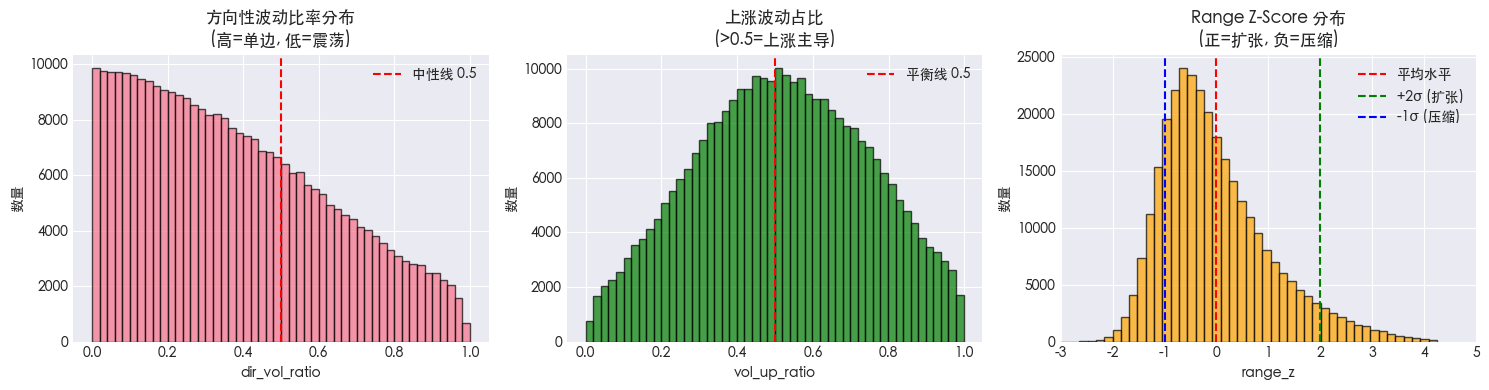


Cell 18 完成: 方向性波动 & Range Expansion ✅


In [29]:
# ========== Cell 18: 方向性波动 & Range Expansion (Directional Volatility) ==========
"""
📌 1.1(b) "方向性波动" vs "无方向波动"
   区分"顺势波动"和"乱抖动"：
   - vol_up = sum(r_i^2 for r_i > 0)
   - vol_down = sum(r_i^2 for r_i < 0)
   - dir_vol_ratio = |vol_up - vol_down| / vol_tot  ∈ [0,1]
     - 越接近 1: 单边主导（趋势更明显）
     - 越接近 0: 上下乱抖（典型 range）

📌 1.1(c) Range Expansion / Compression
   - range_z = (current_range - avg_range_N) / std_range_N
   - 典型的 regime 变化往往伴随 range_z 的 spike
"""
print("计算方向性波动 & Range Expansion 特征...")

DIR_VOL_WINDOW = 20
RANGE_Z_WINDOW = 20

# ========== 1.1(b) 方向性波动 ==========
def calc_directional_volatility(returns: pd.Series, window: int) -> pd.DataFrame:
    """
    计算方向性波动指标
    """
    # 上涨波动 (r > 0 时的 r^2)
    returns_sq = returns ** 2
    vol_up = returns_sq.where(returns > 0, 0).rolling(window).sum() # 窗口内正收益的平方和
    vol_down = returns_sq.where(returns < 0, 0).rolling(window).sum() # 窗口内负收益的平方和
    vol_tot = vol_up + vol_down
    
    # 方向性波动比率
    dir_vol_ratio = (vol_up - vol_down).abs() / vol_tot.replace(0, np.nan)
    dir_vol_ratio = dir_vol_ratio.clip(0, 1)
    
    # 上涨波动占比 (判断方向)
    vol_up_ratio = vol_up / vol_tot.replace(0, np.nan) # 单边主导程度
    
    return pd.DataFrame({
        "vol_up": vol_up,
        "vol_down": vol_down,
        "vol_tot": vol_tot,
        "dir_vol_ratio": dir_vol_ratio,
        "vol_up_ratio": vol_up_ratio,
    })


dir_vol_df = calc_directional_volatility(df["log_return"], DIR_VOL_WINDOW)
df["dir_vol_ratio"] = dir_vol_df["dir_vol_ratio"]
df["vol_up_ratio"] = dir_vol_df["vol_up_ratio"]

# ========== 1.1(c) Range Expansion / Compression ==========
df["bar_range"] = df["high"] - df["low"]
df["avg_range"] = df["bar_range"].rolling(RANGE_Z_WINDOW).mean()
df["std_range"] = df["bar_range"].rolling(RANGE_Z_WINDOW).std()
df["range_z"] = (df["bar_range"] - df["avg_range"]) / df["std_range"].replace(0, np.nan)

# Range z-score 的滚动均值 (用于检测持续压缩/扩张)
df["range_z_ma5"] = df["range_z"].rolling(5).mean()

# 统计
print("\n=== 方向性波动特征统计 ===")
print(f"dir_vol_ratio: mean={df['dir_vol_ratio'].mean():.4f}, median={df['dir_vol_ratio'].median():.4f}")
print(f"vol_up_ratio: mean={df['vol_up_ratio'].mean():.4f} (0.5=平衡, >0.5=上涨主导)")

print(f"\n=== Range Expansion 特征统计 ===")
print(f"range_z: mean={df['range_z'].mean():.4f}, std={df['range_z'].std():.4f}")
print(f"range_z_ma5: mean={df['range_z_ma5'].mean():.4f}")

# 可视化
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# dir_vol_ratio 分布
axes[0].hist(df["dir_vol_ratio"].dropna(), bins=50, edgecolor="black", alpha=0.7)
axes[0].axvline(x=0.5, color="red", linestyle="--", label="中性线 0.5")
axes[0].set_xlabel("dir_vol_ratio")
axes[0].set_ylabel("数量")
axes[0].set_title("方向性波动比率分布\n(高=单边, 低=震荡)")
axes[0].legend()

# vol_up_ratio 分布
axes[1].hist(df["vol_up_ratio"].dropna(), bins=50, edgecolor="black", alpha=0.7, color="green")
axes[1].axvline(x=0.5, color="red", linestyle="--", label="平衡线 0.5")
axes[1].set_xlabel("vol_up_ratio")
axes[1].set_ylabel("数量")
axes[1].set_title("上涨波动占比\n(>0.5=上涨主导)")
axes[1].legend()

# range_z 分布
axes[2].hist(df["range_z"].dropna(), bins=50, edgecolor="black", alpha=0.7, color="orange")
axes[2].axvline(x=0, color="red", linestyle="--", label="平均水平")
axes[2].axvline(x=2, color="green", linestyle="--", label="+2σ (扩张)")
axes[2].axvline(x=-1, color="blue", linestyle="--", label="-1σ (压缩)")
axes[2].set_xlabel("range_z")
axes[2].set_ylabel("数量")
axes[2].set_title("Range Z-Score 分布\n(正=扩张, 负=压缩)")
axes[2].legend()
axes[2].set_xlim(-3, 5)

plt.tight_layout()
plt.show()

print("\nCell 18 完成: 方向性波动 & Range Expansion ✅")



计算多空 Bar 结构特征...

=== Bull/Bear 比例统计 ===
bull_ratio: mean=0.4669
bear_ratio: mean=0.4513
bull_bear_diff: mean=0.0157

=== 连续性统计 ===
consec_bull: max=13, mean=0.85
consec_bear: max=15, mean=0.80


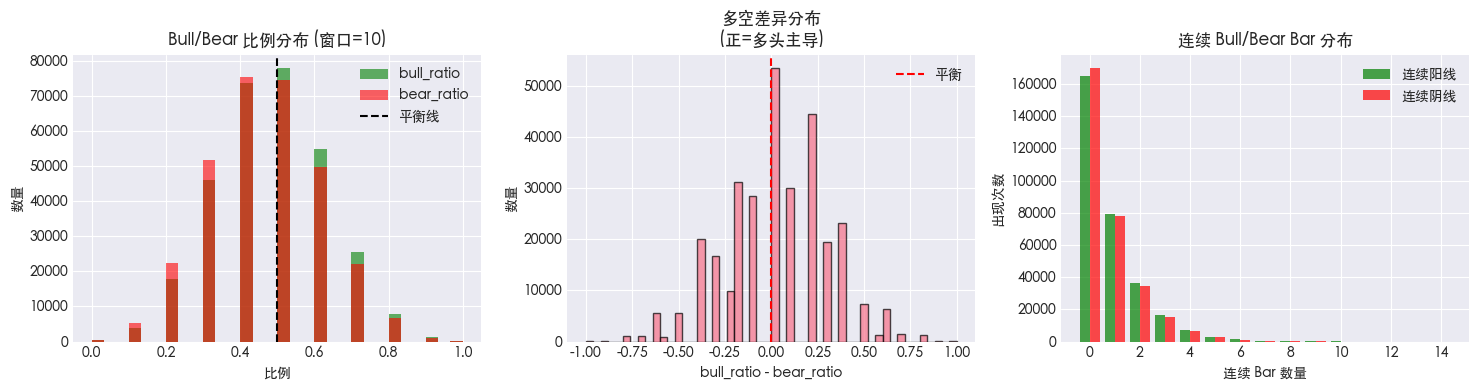


Cell 19 完成: 多空 Bar 结构 ✅


In [33]:
# ========== Cell 19: 多空 Bar 结构 & 连续性 (Bull/Bear Bar Structure) ==========
"""
📌 1.2(a) Brooks 很看"连续几根 bull/bear bar"
   - bull_ratio_N: 窗口内阳线比例
   - bear_ratio_N: 窗口内阴线比例
   - consec_bull: 当前向前连续的阳线数量
   - consec_bear: 当前向前连续的阴线数量
   
   趋势段中常见: bull_ratio 极高且 consec_bull > 3
   震荡段中多为: 1-1、2-1 互换、bull/bear 混杂
"""
print("计算多空 Bar 结构特征...")

BAR_STRUCTURE_WINDOW = 10

# ========== Bull/Bear 判定 ==========
# 阳线: close > open, 阴线: close < open
df["is_bull"] = (df["close"] > df["open"]).astype(int)
df["is_bear"] = (df["close"] < df["open"]).astype(int)

tick = MICRO_TICK_SIZE
df["is_doji"] = (np.abs(df["close"] - df["open"]) < tick/2).astype(int) # 十字星


# ========== 窗口内比例 ==========
df["bull_ratio"] = df["is_bull"].rolling(BAR_STRUCTURE_WINDOW).mean() # 趋势上行bull_ratio高
df["bear_ratio"] = df["is_bear"].rolling(BAR_STRUCTURE_WINDOW).mean()# 趋势下行bear_ratio高

# Bull - Bear 差异 (正=多头主导, 负=空头主导)
df["bull_bear_diff"] = df["bull_ratio"] - df["bear_ratio"] # 方向压力

# ========== 连续性计算 ==========
def calc_consecutive_bars(is_bull: np.ndarray, is_bear: np.ndarray) -> tuple:
    """
    计算连续阳线/阴线数量
    """
    n = len(is_bull)
    consec_bull = np.zeros(n, dtype=np.int32)
    consec_bear = np.zeros(n, dtype=np.int32)
    
    for i in range(n):
        # 连续阳线
        if is_bull[i]:
            if i == 0:
                consec_bull[i] = 1
            else:
                consec_bull[i] = consec_bull[i-1] + 1 if is_bull[i-1] else 1
        else:
            consec_bull[i] = 0
        
        # 连续阴线
        if is_bear[i]:
            if i == 0:
                consec_bear[i] = 1
            else:
                consec_bear[i] = consec_bear[i-1] + 1 if is_bear[i-1] else 1
        else:
            consec_bear[i] = 0
    
    return consec_bull, consec_bear


consec_bull, consec_bear = calc_consecutive_bars(
    df["is_bull"].values.astype(np.int32), 
    df["is_bear"].values.astype(np.int32) 
)
df["consec_bull"] = consec_bull
df["consec_bear"] = consec_bear

# 最近 N 根内最大连续段
df["max_consec_bull_10"] = df["consec_bull"].rolling(10).max()
df["max_consec_bear_10"] = df["consec_bear"].rolling(10).max()

# ========== 统计 ==========
print("\n=== Bull/Bear 比例统计 ===")
print(f"bull_ratio: mean={df['bull_ratio'].mean():.4f}")
print(f"bear_ratio: mean={df['bear_ratio'].mean():.4f}")
print(f"bull_bear_diff: mean={df['bull_bear_diff'].mean():.4f}")

print(f"\n=== 连续性统计 ===")
print(f"consec_bull: max={df['consec_bull'].max()}, mean={df['consec_bull'].mean():.2f}")
print(f"consec_bear: max={df['consec_bear'].max()}, mean={df['consec_bear'].mean():.2f}")


# 可视化
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

plt.rcParams['font.sans-serif'] = ['Heiti TC', 'PingFang SC']


# bull/bear ratio 分布
axes[0].hist(df["bull_ratio"].dropna(), bins=30, alpha=0.6, label="bull_ratio", color="green")
axes[0].hist(df["bear_ratio"].dropna(), bins=30, alpha=0.6, label="bear_ratio", color="red")
axes[0].axvline(x=0.5, color="black", linestyle="--", label="平衡线")
axes[0].set_xlabel("比例")
axes[0].set_ylabel("数量")
axes[0].set_title(f"Bull/Bear 比例分布 (窗口={BAR_STRUCTURE_WINDOW})")
axes[0].legend()

# bull_bear_diff 分布
axes[1].hist(df["bull_bear_diff"].dropna(), bins=50, edgecolor="black", alpha=0.7)
axes[1].axvline(x=0, color="red", linestyle="--", label="平衡")
axes[1].set_xlabel("bull_ratio - bear_ratio")
axes[1].set_ylabel("数量")
axes[1].set_title("多空差异分布\n(正=多头主导)")
axes[1].legend()

# 连续性分布
consec_bull_counts = pd.Series(consec_bull).value_counts().sort_index()
consec_bear_counts = pd.Series(consec_bear).value_counts().sort_index()
x_range = range(0, min(15, max(consec_bull_counts.index.max(), consec_bear_counts.index.max()) + 1))
axes[2].bar([x - 0.2 for x in x_range], 
            [consec_bull_counts.get(x, 0) for x in x_range], 
            width=0.4, label="连续阳线", color="green", alpha=0.7)
axes[2].bar([x + 0.2 for x in x_range], 
            [consec_bear_counts.get(x, 0) for x in x_range], 
            width=0.4, label="连续阴线", color="red", alpha=0.7)
axes[2].set_xlabel("连续 Bar 数量")
axes[2].set_ylabel("出现次数")
axes[2].set_title("连续 Bull/Bear Bar 分布")
axes[2].legend()

plt.tight_layout()
plt.show()

print("\nCell 19 完成: 多空 Bar 结构 ✅")


计算实体/影线结构特征...

=== 单 Bar 实体/影线统计 ===
body_ratio: mean=0.4482, median=0.4483
upper_wick_ratio: mean=0.2710
lower_wick_ratio: mean=0.2807
total_wick_ratio: mean=0.5518

=== 窗口均值 (N=10) ===
avg_body_ratio: mean=0.4482
avg_total_wick_ratio: mean=0.5518
doji_like_ratio: mean=0.3193 (小实体大影线的比例)


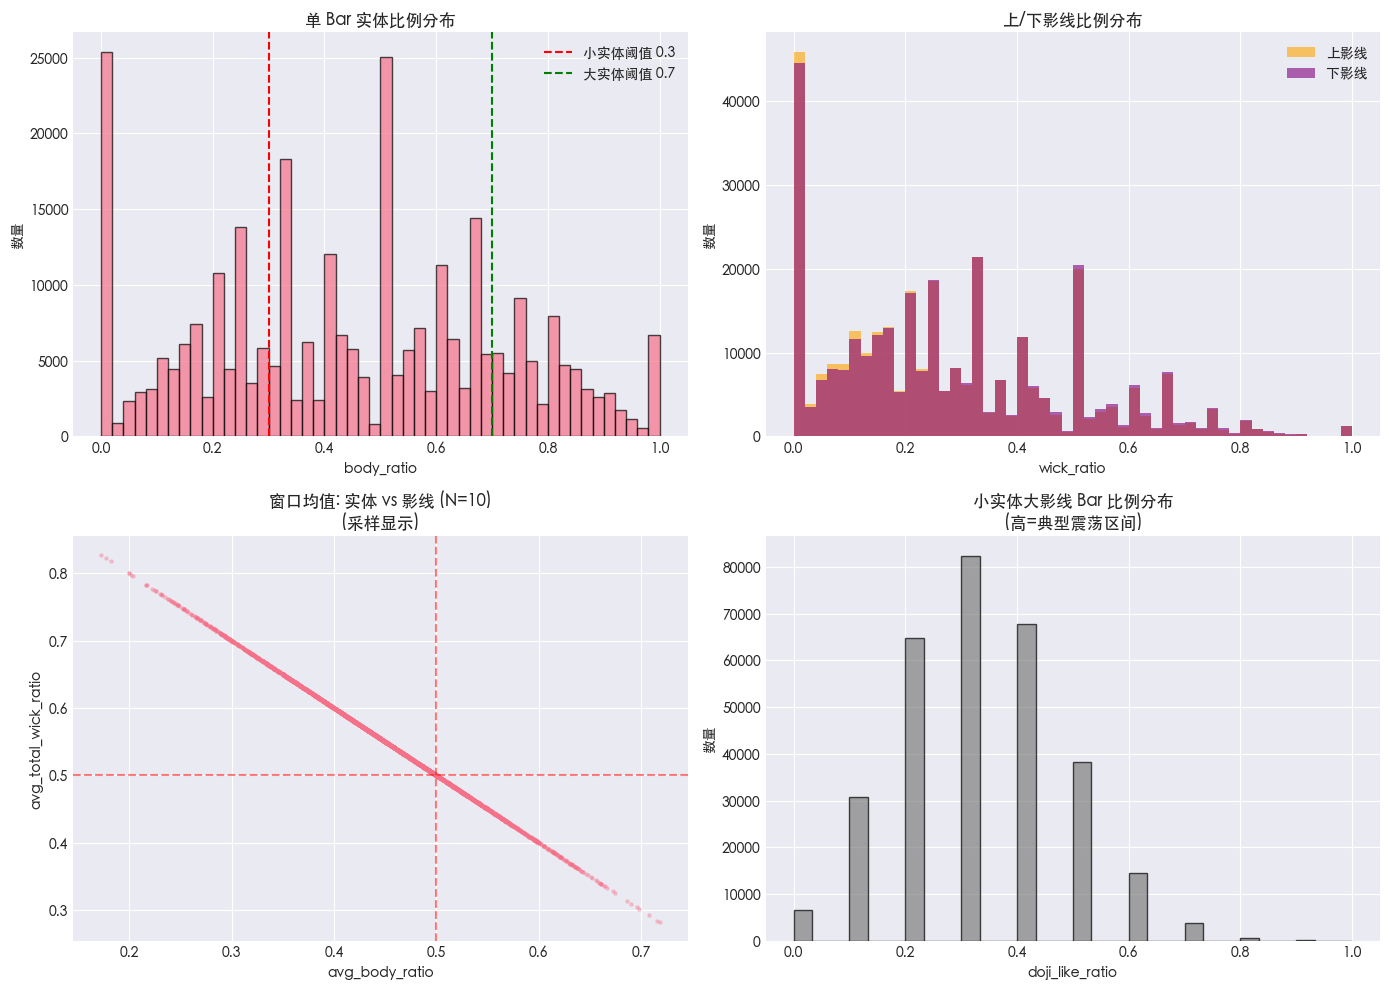


Cell 20 完成: 实体/影线结构 ✅


In [35]:
# ========== Cell 20: 实体/影线结构 (Body & Wick Ratios) ==========
"""
📌 1.2(b) Brooks 风格的实体/影线分析（不做日式形态名）
   对每根 bar:
   - body_ratio = |close - open| / range  (实体占比)
   - upper_wick_ratio = (high - max(open, close)) / range (上影线占比)
   - lower_wick_ratio = (min(open, close) - low) / range (下影线占比)
   
   窗口均值解读:
   - avg_body_ratio 低 + 多影线 ⇒ 典型 trading range
   - avg_body_ratio 高 + bull/bear 极端 ⇒ 趋势段
   - Brooks: "lots of tails, especially both sides ⇒ trading range"
"""
print("计算实体/影线结构特征...")

if "bar_range" not in df.columns:
    df["bar_range"] = df["high"] - df["low"]


WICK_WINDOW = 10

# ========== 单 Bar 的实体/影线比例 ==========
df["body"] = (df["close"] - df["open"]).abs()
df["upper_wick"] = df["high"] - df[["open", "close"]].max(axis=1)
df["lower_wick"] = df[["open", "close"]].min(axis=1) - df["low"]

# 比例 (避免除以0)
bar_range = df["bar_range"].replace(0, np.nan)
df["body_ratio"] = df["body"] / bar_range
df["upper_wick_ratio"] = df["upper_wick"] / bar_range
df["lower_wick_ratio"] = df["lower_wick"] / bar_range

# 双影线比例 (上下影线之和)
df["total_wick_ratio"] = df["upper_wick_ratio"] + df["lower_wick_ratio"]

# ========== 窗口均值 ==========
df["avg_body_ratio"] = df["body_ratio"].rolling(WICK_WINDOW).mean()
df["avg_upper_wick_ratio"] = df["upper_wick_ratio"].rolling(WICK_WINDOW).mean()
df["avg_lower_wick_ratio"] = df["lower_wick_ratio"].rolling(WICK_WINDOW).mean()
df["avg_total_wick_ratio"] = df["total_wick_ratio"].rolling(WICK_WINDOW).mean()

# ========== 小实体/大影线的 bar 数量 (Brooks 所说的 trading range 特征) ==========
# 定义: body_ratio < 0.3 且 total_wick_ratio > 0.5
df["is_doji_like"] = ((df["body_ratio"] < 0.3) & (df["total_wick_ratio"] > 0.5)).astype(int)
df["doji_like_ratio"] = df["is_doji_like"].rolling(WICK_WINDOW).mean()

# ========== 统计 ==========
print("\n=== 单 Bar 实体/影线统计 ===")
print(f"body_ratio: mean={df['body_ratio'].mean():.4f}, median={df['body_ratio'].median():.4f}")
print(f"upper_wick_ratio: mean={df['upper_wick_ratio'].mean():.4f}")
print(f"lower_wick_ratio: mean={df['lower_wick_ratio'].mean():.4f}")
print(f"total_wick_ratio: mean={df['total_wick_ratio'].mean():.4f}")

print(f"\n=== 窗口均值 (N={WICK_WINDOW}) ===")
print(f"avg_body_ratio: mean={df['avg_body_ratio'].mean():.4f}")
print(f"avg_total_wick_ratio: mean={df['avg_total_wick_ratio'].mean():.4f}")
print(f"doji_like_ratio: mean={df['doji_like_ratio'].mean():.4f} (小实体大影线的比例)")


plt.rcParams['font.sans-serif'] = ['Heiti TC', 'PingFang SC']

# 可视化
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 单 bar body_ratio 分布
axes[0, 0].hist(df["body_ratio"].dropna(), bins=50, edgecolor="black", alpha=0.7)
axes[0, 0].axvline(x=0.3, color="red", linestyle="--", label="小实体阈值 0.3")
axes[0, 0].axvline(x=0.7, color="green", linestyle="--", label="大实体阈值 0.7")
axes[0, 0].set_xlabel("body_ratio")
axes[0, 0].set_ylabel("数量")
axes[0, 0].set_title("单 Bar 实体比例分布")
axes[0, 0].legend()

# 单 bar 影线分布
axes[0, 1].hist(df["upper_wick_ratio"].dropna(), bins=50, alpha=0.6, label="上影线", color="orange")
axes[0, 1].hist(df["lower_wick_ratio"].dropna(), bins=50, alpha=0.6, label="下影线", color="purple")
axes[0, 1].set_xlabel("wick_ratio")
axes[0, 1].set_ylabel("数量")
axes[0, 1].set_title("上/下影线比例分布")
axes[0, 1].legend()

# 窗口均值 body vs wick
axes[1, 0].scatter(df["avg_body_ratio"].dropna().values[::100], 
                   df["avg_total_wick_ratio"].dropna().values[::100], 
                   alpha=0.3, s=5)
axes[1, 0].set_xlabel("avg_body_ratio")
axes[1, 0].set_ylabel("avg_total_wick_ratio")
axes[1, 0].set_title(f"窗口均值: 实体 vs 影线 (N={WICK_WINDOW})\n(采样显示)")
axes[1, 0].axhline(y=0.5, color="red", linestyle="--", alpha=0.5)
axes[1, 0].axvline(x=0.5, color="red", linestyle="--", alpha=0.5)

# doji_like_ratio 分布
axes[1, 1].hist(df["doji_like_ratio"].dropna(), bins=30, edgecolor="black", alpha=0.7, color="gray")
axes[1, 1].set_xlabel("doji_like_ratio")
axes[1, 1].set_ylabel("数量")
axes[1, 1].set_title("小实体大影线 Bar 比例分布\n(高=典型震荡区间)")

plt.tight_layout()
plt.show()

print("\nCell 20 完成: 实体/影线结构 ✅")


计算三重腿结构特征 (这可能需要一些时间)...
  计算 Leg Type A (Major Legs)...
  计算 Leg Type B (Micro Legs)...
  计算 Leg Type C (Fractal Legs)...

=== 三重腿结构统计 ===
Leg A (Major): 总腿数=105,514, 平均每10bar变化=3.41次
Leg B (Micro): 总腿数=156,620, 平均每10bar变化=5.06次
Leg C (Fractal): 总腿数=149,083, 平均每10bar变化=4.82次


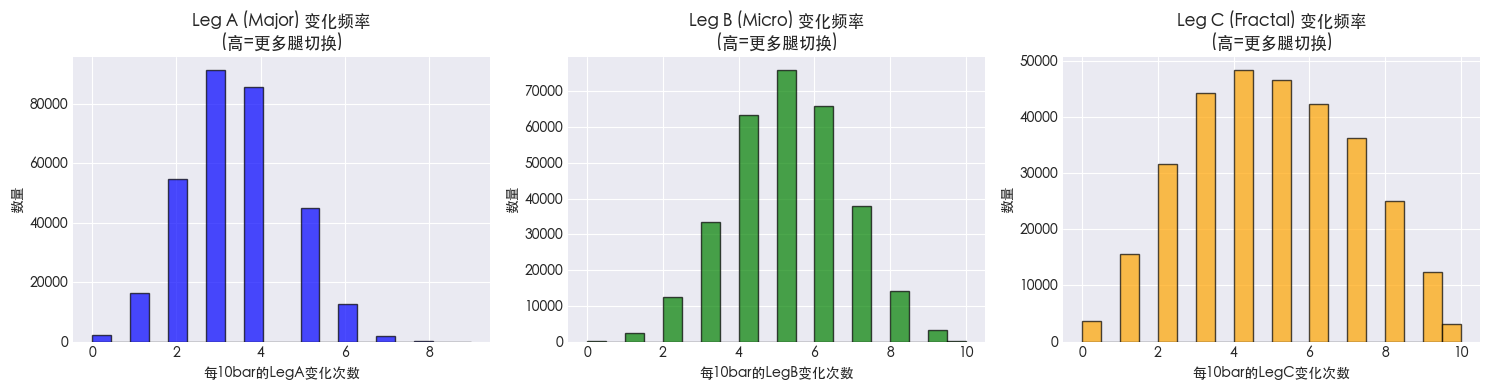


Cell 21 完成: 三重腿结构 ✅


In [36]:
# ========== Cell 21: 三重腿结构 (Three-Type Leg Structure) ==========
"""
📌 1.2(c) Leg Structure Metrics — Brooks 风格的腿结构量化

三种腿的定义:
1. Leg Type A (Major Legs): Spike Break Leg — 结构性突破腿
   - 上涨中: 某根 bar 的 low 跌破前一根 bar 的 low → 新 major leg 开始
   - 下跌中: 某根 bar 的 high 突破前一根 bar 的 high → 新 major leg 开始
   
2. Leg Type B (Micro Legs): Opposite Close Leg — 对向收盘腿  
   - 上涨中: 出现一根阴线 (close < open) → 新 micro leg
   - 下跌中: 出现一根阳线 (close > open) → 新 micro leg
   
3. Leg Type C (Fractal Legs): Implied Pullback Leg — 隐含回调腿
   - 基于重叠度、小实体、影线等结构信号判定
   - 模拟更小时间周期上的 pullback 信息

输出特征:
- legA_id, legA_dir, legA_prev1_dir, legA_prev2_dir
- legB_id, legB_dir, legB_prev1_dir, legB_prev2_dir  
- legC_id, legC_dir, legC_prev1_dir, legC_prev2_dir
"""
print("计算三重腿结构特征 (这可能需要一些时间)...")


def calc_leg_type_A(high: np.ndarray, low: np.ndarray, close: np.ndarray, open_: np.ndarray) -> tuple:
    """
    计算 Leg Type A: Spike Break Legs (Major Legs)
    
    规则:
    - 上涨趋势中: low 跌破前一根 low → 新腿开始
    - 下跌趋势中: high 突破前一根 high → 新腿开始
    - 初始方向由第一根 bar 的 close-open 决定
    """
    n = len(high)
    leg_id = np.zeros(n, dtype=np.int32)
    leg_dir = np.zeros(n, dtype=np.int32)
    
    # 初始化
    current_leg_id = 1
    if close[0] >= open_[0]:
        current_dir = 1  # 上涨
    else:
        current_dir = -1  # 下跌
    
    leg_id[0] = current_leg_id
    leg_dir[0] = current_dir
    
    for i in range(1, n):
        new_leg = False
        
        if current_dir == 1:  # 当前上涨腿
            # 如果 low 跌破前一根 low → 结构性破坏 → 新腿
            if low[i] < low[i-1]:
                new_leg = True
                # 新腿方向由当前 bar 决定
                if close[i] >= open_[i]:
                    current_dir = 1
                else:
                    current_dir = -1
        else:  # 当前下跌腿
            # 如果 high 突破前一根 high → 结构性破坏 → 新腿
            if high[i] > high[i-1]:
                new_leg = True
                if close[i] >= open_[i]:
                    current_dir = 1
                else:
                    current_dir = -1
        
        if new_leg:
            current_leg_id += 1
        
        leg_id[i] = current_leg_id
        leg_dir[i] = current_dir
    
    return leg_id, leg_dir


def calc_leg_type_B(close: np.ndarray, open_: np.ndarray) -> tuple:
    """
    计算 Leg Type B: Opposite Close Legs (Micro Legs)
    
    规则:
    - 当前上涨腿中，出现阴线 → 新腿（方向翻转）
    - 当前下跌腿中，出现阳线 → 新腿（方向翻转）
    """
    n = len(close)
    leg_id = np.zeros(n, dtype=np.int32)
    leg_dir = np.zeros(n, dtype=np.int32)
    
    current_leg_id = 1
    if close[0] >= open_[0]:
        current_dir = 1
    else:
        current_dir = -1
    
    leg_id[0] = current_leg_id
    leg_dir[0] = current_dir
    
    for i in range(1, n):
        bar_dir = 1 if close[i] >= open_[i] else -1
        
        # 如果当前 bar 方向与腿方向相反 → 新腿
        if bar_dir != current_dir:
            current_leg_id += 1
            current_dir = bar_dir
        
        leg_id[i] = current_leg_id
        leg_dir[i] = current_dir
    
    return leg_id, leg_dir


def calc_leg_type_C(high: np.ndarray, low: np.ndarray, close: np.ndarray, open_: np.ndarray,
                    overlap_ratio: np.ndarray, body_ratio: np.ndarray, 
                    upper_wick_ratio: np.ndarray, lower_wick_ratio: np.ndarray,
                    atr: np.ndarray) -> tuple:
    """
    计算 Leg Type C: Implied Pullback Legs (Fractal Legs)
    
    规则 (上涨中，满足2项条件即新腿):
    - overlap_ratio > 0.6
    - body_ratio < 0.3
    - upper_wick_ratio > 0.4 (上涨中) 或 lower_wick_ratio > 0.4 (下跌中)
    - 最近4根bar的高点增幅 < ATR * 0.3 (动能停滞)
    """
    n = len(high)
    leg_id = np.zeros(n, dtype=np.int32)
    leg_dir = np.zeros(n, dtype=np.int32)
    
    current_leg_id = 1
    if close[0] >= open_[0]:
        current_dir = 1
    else:
        current_dir = -1
    
    leg_id[0] = current_leg_id
    leg_dir[0] = current_dir
    
    for i in range(1, n):
        conditions_met = 0
        
        # 检查各项条件
        if not np.isnan(overlap_ratio[i]) and overlap_ratio[i] > 0.6: 
            conditions_met += 1
        
        if not np.isnan(body_ratio[i]) and body_ratio[i] < 0.3:
            conditions_met += 1
        
        if current_dir == 1:  # 上涨腿
            if not np.isnan(upper_wick_ratio[i]) and upper_wick_ratio[i] > 0.4:
                conditions_met += 1
        else:  # 下跌腿
            if not np.isnan(lower_wick_ratio[i]) and lower_wick_ratio[i] > 0.4:
                conditions_met += 1
        
        # 动能停滞检查 (最近4根bar)
        if i >= 4 and not np.isnan(atr[i]) and atr[i] > 0:
            if current_dir == 1:
                high_gain = high[i] - high[i-4]
            else:
                high_gain = low[i-4] - low[i]
            
            if high_gain < atr[i] * 0.3:
                conditions_met += 1
        
        # 满足 2 项条件 → 新腿
        if conditions_met >= 2:
            current_leg_id += 1
            # 方向由当前 bar 决定
            if close[i] >= open_[i]:
                current_dir = 1
            else:
                current_dir = -1
        
        leg_id[i] = current_leg_id
        leg_dir[i] = current_dir
    
    return leg_id, leg_dir


# ========== 计算三种腿 ==========
print("  计算 Leg Type A (Major Legs)...")
legA_id, legA_dir = calc_leg_type_A(
    df["high"].values, df["low"].values, 
    df["close"].values, df["open"].values
)
df["legA_id"] = legA_id
df["legA_dir"] = legA_dir


print("  计算 Leg Type B (Micro Legs)...")
legB_id, legB_dir = calc_leg_type_B(df["close"].values, df["open"].values)
df["legB_id"] = legB_id
df["legB_dir"] = legB_dir

print("  计算 Leg Type C (Fractal Legs)...")
# 先填充 NaN 为 0，避免 numba 错误
overlap_arr = df["overlap_ratio"].values.astype(np.float64)
body_arr = df["body_ratio"].values.astype(np.float64)
upper_wick_arr = df["upper_wick_ratio"].values.astype(np.float64)
lower_wick_arr = df["lower_wick_ratio"].values.astype(np.float64)
atr_arr = df["atr"].values.astype(np.float64)


legC_id, legC_dir = calc_leg_type_C(
    df["high"].values, df["low"].values,
    df["close"].values, df["open"].values,
    overlap_arr, body_arr, upper_wick_arr, lower_wick_arr, atr_arr
)
df["legC_id"] = legC_id
df["legC_dir"] = legC_dir

# ========== 添加前几腿方向特征 ==========
for leg_type in ["A", "B", "C"]:
    dir_col = f"leg{leg_type}_dir"
    df[f"leg{leg_type}_prev1_dir"] = df[dir_col].shift(1)
    df[f"leg{leg_type}_prev2_dir"] = df[dir_col].shift(2)

# ========== 计算每种腿的变化率 (用于检测频率) ==========
for leg_type in ["A", "B", "C"]:
    id_col = f"leg{leg_type}_id"
    # 腿变化标记
    df[f"leg{leg_type}_change"] = (df[id_col] != df[id_col].shift(1)).astype(int)
    # 最近 N 根内的腿变化次数
    df[f"leg{leg_type}_changes_10"] = df[f"leg{leg_type}_change"].rolling(10).sum()

# ========== 统计 ==========
print("\n=== 三重腿结构统计 ===")
for leg_type, desc in [("A", "Major"), ("B", "Micro"), ("C", "Fractal")]:
    total_legs = df[f"leg{leg_type}_id"].max()
    avg_changes = df[f"leg{leg_type}_changes_10"].mean()
    print(f"Leg {leg_type} ({desc}): 总腿数={total_legs:,}, 平均每10bar变化={avg_changes:.2f}次")

plt.rcParams['font.sans-serif'] = ['Heiti TC', 'PingFang SC']

# 可视化
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, (leg_type, desc, color) in enumerate([("A", "Major", "blue"), 
                                               ("B", "Micro", "green"), 
                                               ("C", "Fractal", "orange")]):
    changes_col = f"leg{leg_type}_changes_10"
    axes[i].hist(df[changes_col].dropna(), bins=20, edgecolor="black", alpha=0.7, color=color)
    axes[i].set_xlabel(f"每10bar的Leg{leg_type}变化次数")
    axes[i].set_ylabel("数量")
    axes[i].set_title(f"Leg {leg_type} ({desc}) 变化频率\n(高=更多腿切换)")

plt.tight_layout()
plt.show()

print("\nCell 21 完成: 三重腿结构 ✅")


计算 Spike & Channel 评分...

=== Spike & Channel 评分统计 ===
spike_score: mean=0.4211, max=0.9677
channel_score: mean=0.6019, max=0.9419

=== Phase 分布 ===
  Normal/Range: 223,935 (72.37%)
  Spike: 36,201 (11.70%)
  Channel: 49,276 (15.93%)


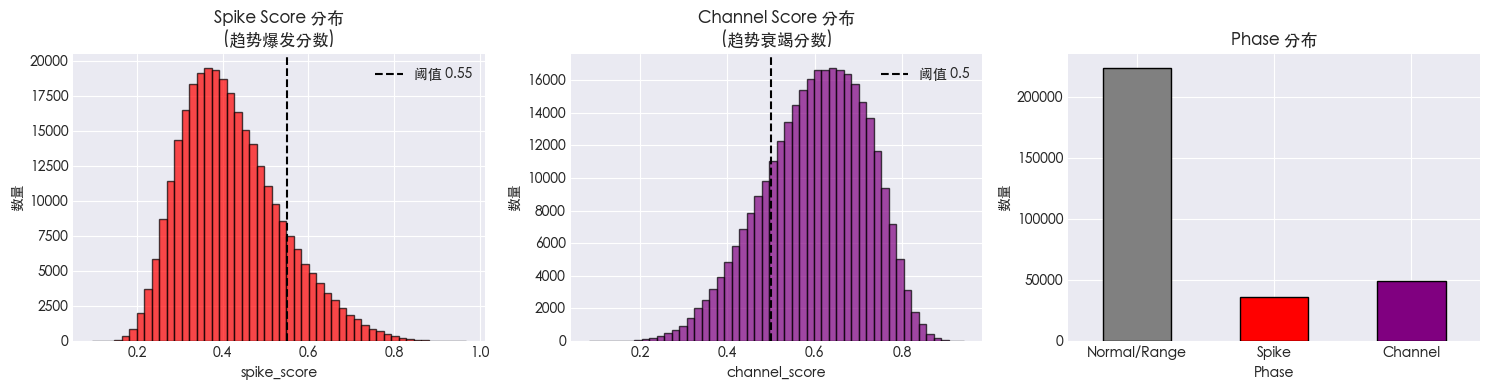


Cell 22 完成: Spike & Channel 评分 ✅


In [63]:
# ========== Cell 22: Spike & Channel 评分 (Phase Detection) ==========
"""
📌 使用三套腿结构来识别 Spike (趋势爆发期) 和 Channel (趋势成熟期)

Spike (趋势爆发) 特点:
- 只有 1 条 major leg（或只到 legA=2）
- micro legs（B 型）极少
- implied legs（C 型）极少
- 斜率强、重叠少、range_z 高、er 高、chop 低

Channel (趋势成熟/衰竭) 特点:
- major legA ≥ 2 且趋势仍延续
- micro legs（B 型）数量上升
- implied legs（C 型）密度上升
- slope 下降但方向仍稳定
- 高重叠度

输出:
- spike_score: 0-1 分数，越高越像 Spike
- channel_score: 0-1 分数，越高越像 Channel
- phase: 0=normal, 1=spike, 2=channel
"""


"""
Phase 识别（无标签泄露版本）
- 仍然输出 spike_score / channel_score / phase
- phase 不再依赖 df['regime']（标签），而是依赖非标签的 trend_proxy（趋势代理）
  trend_proxy 使用：slope_norm, er, chop, trend_alignment（都不需要标签）
"""


print("计算 Spike & Channel 评分...")

PHASE_WINDOW = 10

# ========== Spike Score ==========
def calc_spike_score(df: pd.DataFrame, window: int = 10) -> pd.Series:
    """
    计算 Spike Score (趋势爆发分数)
    
    组成:
    1. Major leg 少 (legA_changes 低)
    2. Micro leg 少 (legB_changes 低) 
    3. Fractal leg 少 (legC_changes 低)
    4. ER 高
    5. chop 低
    6. range_z 高
    7. 多尺度一致性高 (|trend_alignment| == 3)
    """
    scores = pd.DataFrame(index=df.index)
    
    # 1. Major leg 变化少 (spike 中通常只有 1-2 条大腿)
    legA_changes = df["legA_changes_10"]
    scores["legA_score"] = 1 - (legA_changes / 10).clip(0, 1)  # 变化少 → 高分
    
    # 2. Micro leg 变化少
    legB_changes = df["legB_changes_10"]
    scores["legB_score"] = 1 - (legB_changes / 10).clip(0, 1)
    
    # 3. Fractal leg 变化少
    legC_changes = df["legC_changes_10"]
    scores["legC_score"] = 1 - (legC_changes / 10).clip(0, 1)
    
    # 4. ER 高 (> 0.4 开始加分)
    scores["er_score"] = ((df["er"] - 0.2) / 0.6).clip(0, 1)
    
    # 5. chop 低 (< 0.5 开始加分)
    scores["chop_score"] = ((0.7 - df["chop"]) / 0.5).clip(0, 1)
    
    # 6. range_z 高 (扩张)
    scores["range_z_score"] = (df["range_z"] / 3).clip(0, 1)
    
    # 7. 多尺度一致性
    scores["alignment_score"] = (df["trend_alignment"].abs() / 3).clip(0, 1)
    
    # 加权平均
    weights = {
        "legA_score": 0.15,
        "legB_score": 0.15,
        "legC_score": 0.10,
        "er_score": 0.20,
        "chop_score": 0.15,
        "range_z_score": 0.10,
        "alignment_score": 0.15,
    }
    
    spike_score = sum(scores[col] * w for col, w in weights.items())
    return spike_score.clip(0, 1)


# ========== Channel Score ==========
def calc_channel_score(df: pd.DataFrame, window: int = 10) -> pd.Series:
    """
    计算 Channel Score (趋势成熟/衰竭分数)
    
    组成:
    1. Major leg >= 2
    2. Micro leg 增多 (legB_changes 高)
    3. Fractal leg 增多 (legC_changes 高)
    4. 重叠度高
    5. 斜率衰减 (但方向仍一致)
    6. ER 中等 (0.3-0.5)
    """
    scores = pd.DataFrame(index=df.index)
    
    # 1. Micro leg 变化多 (channel 内部有很多小回调)
    legB_changes = df["legB_changes_10"]
    scores["legB_score"] = (legB_changes / 8).clip(0, 1)
    
    # 2. Fractal leg 变化多
    legC_changes = df["legC_changes_10"]
    scores["legC_score"] = (legC_changes / 6).clip(0, 1)
    
    # 3. 重叠度高
    scores["overlap_score"] = ((df["overlap_ratio"] - 0.3) / 0.5).clip(0, 1)
    
    # 4. ER 中等 (不太高也不太低)
    er = df["er"]
    scores["er_score"] = 1 - 2 * (er - 0.35).abs()  # 0.35 附近最高
    scores["er_score"] = scores["er_score"].clip(0, 1)
    
    # 5. 斜率仍有但在衰减 (slope_norm 正/负但绝对值 < 0.05)
    slope_abs = df["slope_norm"].abs()
    scores["slope_score"] = ((0.1 - slope_abs) / 0.1 + 0.5).clip(0, 1)
    
    # 6. 小实体比例高 (channel 内部常见)
    scores["body_score"] = ((0.6 - df["avg_body_ratio"]) / 0.4).clip(0, 1)
    
    # 加权平均
    weights = {
        "legB_score": 0.20,
        "legC_score": 0.15,
        "overlap_score": 0.20,
        "er_score": 0.15,
        "slope_score": 0.15,
        "body_score": 0.15,
    }
    
    channel_score = sum(scores[col] * w for col, w in weights.items())
    return channel_score.clip(0, 1)


# 计算分数
df["spike_score"] = calc_spike_score(df, PHASE_WINDOW)
df["channel_score"] = calc_channel_score(df, PHASE_WINDOW)

# ========== Phase 判定 ==========
# phase: 0=normal, 1=spike, 2=channel
SPIKE_THRESHOLD = 0.55
CHANNEL_THRESHOLD = 0.50


# --- 1) 用“非标签特征”构造趋势代理 trend_proxy ---
# 可以把阈值当成超参调
TREND_SLOPE_THR = 0.02   # 斜率够强
TREND_ER_THR    = 0.35   # ER 够高（趋势效率）
TREND_CHOP_THR  = 0.55   # chop 够低（不太震荡）
TREND_ALIGN_THR = 2      # 多尺度一致性（>=2 表示大概率同向）

trend_proxy = (
    (df["slope_norm"].abs() > TREND_SLOPE_THR) &
    ((df["er"] > TREND_ER_THR) | (df["chop"] < TREND_CHOP_THR)) &
    (df["trend_alignment"].abs() >= TREND_ALIGN_THR)
)

df["trend_proxy_phase"] = trend_proxy.astype(int)  # 可选：便于调试/画图

# --- 2) phase 仅在 trend_proxy=True 时才可能为 1/2 ---
phase = np.zeros(len(df), dtype=np.int32)

spike = df["spike_score"].fillna(0).values
channel = df["channel_score"].fillna(0).values
tp = trend_proxy.fillna(False).values

phase[(tp) & (spike > SPIKE_THRESHOLD) & (spike > channel)] = 1
phase[(tp) & (channel > CHANNEL_THRESHOLD) & (channel >= spike)] = 2
# 其余保持 0

df["phase"] = phase

'''
def determine_phase(spike: float, channel: float, regime: int) -> int:
    """
    判定当前阶段
    - 如果 regime == 0 (震荡区间)，则 phase = 0
    - 如果 spike_score 高且在趋势中，则 phase = 1 (spike)
    - 如果 channel_score 高且在趋势中，则 phase = 2 (channel)
    """
    if pd.isna(regime) or regime == 0:
        return 0
    
    if spike > SPIKE_THRESHOLD and spike > channel:
        return 1  # Spike
    elif channel > CHANNEL_THRESHOLD:
        return 2  # Channel
    else:
        return 0  # Normal trend


df["phase"] = df.apply(
    lambda row: determine_phase(row["spike_score"], row["channel_score"], row["regime"]),
    axis=1
)
'''

# ========== 统计 ==========
print("\n=== Spike & Channel 评分统计 ===")
print(f"spike_score: mean={df['spike_score'].mean():.4f}, max={df['spike_score'].max():.4f}")
print(f"channel_score: mean={df['channel_score'].mean():.4f}, max={df['channel_score'].max():.4f}")

phase_counts = df["phase"].value_counts().sort_index()
print(f"\n=== Phase 分布 ===")
phase_names = {0: "Normal/Range", 1: "Spike", 2: "Channel"}
for k, v in phase_counts.items():
    print(f"  {phase_names.get(k, k)}: {v:,} ({v/len(df)*100:.2f}%)")

plt.rcParams['font.sans-serif'] = ['Heiti TC', 'PingFang SC']

# 可视化
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Spike Score 分布
axes[0].hist(df["spike_score"].dropna(), bins=50, edgecolor="black", alpha=0.7, color="red")
axes[0].axvline(x=SPIKE_THRESHOLD, color="black", linestyle="--", label=f"阈值 {SPIKE_THRESHOLD}")
axes[0].set_xlabel("spike_score")
axes[0].set_ylabel("数量")
axes[0].set_title("Spike Score 分布\n(趋势爆发分数)")
axes[0].legend()

# Channel Score 分布
axes[1].hist(df["channel_score"].dropna(), bins=50, edgecolor="black", alpha=0.7, color="purple")
axes[1].axvline(x=CHANNEL_THRESHOLD, color="black", linestyle="--", label=f"阈值 {CHANNEL_THRESHOLD}")
axes[1].set_xlabel("channel_score")
axes[1].set_ylabel("数量")
axes[1].set_title("Channel Score 分布\n(趋势衰竭分数)")
axes[1].legend()

# Phase 分布
phase_counts.plot(kind="bar", ax=axes[2], color=["gray", "red", "purple"], edgecolor="black")
axes[2].set_xlabel("Phase")
axes[2].set_ylabel("数量")
axes[2].set_title("Phase 分布")
axes[2].set_xticklabels(["Normal/Range", "Spike", "Channel"], rotation=0)

plt.tight_layout()
plt.show()

print("\nCell 22 完成: Spike & Channel 评分 ✅")


计算关键价位特征...
  按日期分组计算日内特征...

=== 关键价位特征统计 ===
pos_in_day_range: mean=0.5520, std=0.2990
dist_to_open: mean=0.2815, std=3.7743
day_return: mean=0.000119, std=0.005790

=== 位置分布 ===
near_day_high 比例: 14.66%
near_day_low 比例: 8.10%
near_open 比例: 13.04%


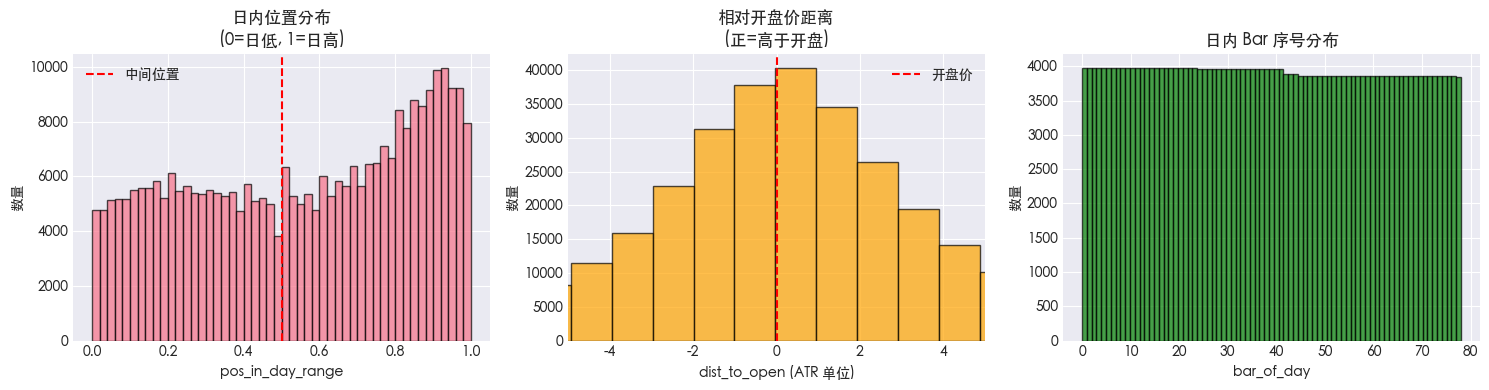


Cell 23 完成: 关键价位特征 ✅


In [39]:
# ========== Cell 23: 关键价位特征 (Key Price Levels) ==========
"""
📌 1.2(e) Brooks 交易员在盘中非常看重的关键价位:
   - pos_in_day_range = (close - day_low) / (day_high - day_low)  ∈ [0,1]
   - dist_to_open = (close - day_open) / ATR_day
   - 接近当日高/低且行情已经涨跌很多 ⇒ 更容易 trading range 或 climactic
   - 一直贴在 open 近旁上下晃 ⇒ 典型"开盘区间"的无方向震荡

注意: 这些特征使用 cumulative 的当日信息，不泄露未来
"""
print("计算关键价位特征...")

# 首先需要识别每个交易日
df_temp = df.copy()
df_temp = df_temp.reset_index()
df_temp["timestamp_dt"] = pd.to_datetime(df_temp["timestamp"].astype(str).str.slice(0, 19))
df_temp["date"] = df_temp["timestamp_dt"].dt.date
df_temp = df_temp.set_index("timestamp")

# ========== 计算每日的关键价位 (滚动累积，不泄露未来) ==========
def calc_intraday_features(group):
    """
    计算单日内的关键价位特征 (使用 expanding 确保不泄露未来)
    """
    n = len(group)
    
    # 当日开盘价 (第一根 bar 的 open)
    day_open = group["open"].iloc[0]
    
    # 累积到当前的最高/最低价 (expanding)
    cum_high = group["high"].expanding().max()
    cum_low = group["low"].expanding().min()
    cum_range = cum_high - cum_low
    
    # 当前价格在日内区间的位置 [0, 1]
    pos_in_day_range = (group["close"] - cum_low) / cum_range.replace(0, np.nan)
    
    # 当前价格相对开盘价的距离 (标准化)
    # 使用当日累积 ATR 的均值
    cum_atr_mean = group["atr"].expanding().mean()
    dist_to_open = (group["close"] - day_open) / cum_atr_mean.replace(0, np.nan)
    
    # 当日累积收益 (相对开盘)
    day_return = (group["close"] - day_open) / day_open
    
    # 当日累积波动 (ATR 总和 / 根数)
    day_volatility = group["atr"].expanding().mean()
    
    # 当日 bar 序号 (从 0 开始)
    bar_of_day = np.arange(n)
    
    return pd.DataFrame({
        "day_open": day_open,
        "cum_high": cum_high,
        "cum_low": cum_low,
        "cum_range": cum_range,
        "pos_in_day_range": pos_in_day_range,
        "dist_to_open": dist_to_open,
        "day_return": day_return,
        "day_volatility": day_volatility,
        "bar_of_day": bar_of_day,
    }, index=group.index)


# 按日期分组计算
print("  按日期分组计算日内特征...")
intraday_features = df_temp.groupby("date").apply(calc_intraday_features)

# 处理 MultiIndex
if isinstance(intraday_features.index, pd.MultiIndex):
    intraday_features = intraday_features.droplevel(0)

# 合并到主 df
for col in ["pos_in_day_range", "dist_to_open", "day_return", "bar_of_day"]:
    df[col] = intraday_features[col]

# ========== 额外的日内位置特征 ==========
# 是否接近当日高点 (top 10%)
df["near_day_high"] = (df["pos_in_day_range"] > 0.9).astype(int)
# 是否接近当日低点 (bottom 10%)
df["near_day_low"] = (df["pos_in_day_range"] < 0.1).astype(int)
# 是否在开盘区间 (dist_to_open 的绝对值 < 0.5 ATR)
df["near_open"] = (df["dist_to_open"].abs() < 0.5).astype(int)

# ========== 时间特征 (无泄露) ==========
# 将 bar_of_day 标准化 (一天约 79 根 5min bar for RTH)
df["time_of_day_norm"] = df["bar_of_day"] / 79  # 0=开盘, 1=收盘

# 开盘/收盘区间标记
df["is_open_range"] = (df["bar_of_day"] < 6).astype(int)   # 前30分钟
df["is_close_range"] = (df["bar_of_day"] > 70).astype(int)  # 最后45分钟

# ========== 统计 ==========
print("\n=== 关键价位特征统计 ===")
print(f"pos_in_day_range: mean={df['pos_in_day_range'].mean():.4f}, std={df['pos_in_day_range'].std():.4f}")
print(f"dist_to_open: mean={df['dist_to_open'].mean():.4f}, std={df['dist_to_open'].std():.4f}")
print(f"day_return: mean={df['day_return'].mean():.6f}, std={df['day_return'].std():.6f}")

print(f"\n=== 位置分布 ===")
print(f"near_day_high 比例: {df['near_day_high'].mean()*100:.2f}%")
print(f"near_day_low 比例: {df['near_day_low'].mean()*100:.2f}%")
print(f"near_open 比例: {df['near_open'].mean()*100:.2f}%")


plt.rcParams['font.sans-serif'] = ['Heiti TC', 'PingFang SC']

# 可视化
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# pos_in_day_range 分布
axes[0].hist(df["pos_in_day_range"].dropna(), bins=50, edgecolor="black", alpha=0.7)
axes[0].axvline(x=0.5, color="red", linestyle="--", label="中间位置")
axes[0].set_xlabel("pos_in_day_range")
axes[0].set_ylabel("数量")
axes[0].set_title("日内位置分布\n(0=日低, 1=日高)")
axes[0].legend()

# dist_to_open 分布
axes[1].hist(df["dist_to_open"].dropna(), bins=50, edgecolor="black", alpha=0.7, color="orange")
axes[1].axvline(x=0, color="red", linestyle="--", label="开盘价")
axes[1].set_xlabel("dist_to_open (ATR 单位)")
axes[1].set_ylabel("数量")
axes[1].set_title("相对开盘价距离\n(正=高于开盘)")
axes[1].legend()
axes[1].set_xlim(-5, 5)

# bar_of_day 分布 (应该是均匀的)
axes[2].hist(df["bar_of_day"].dropna(), bins=79, edgecolor="black", alpha=0.7, color="green")
axes[2].set_xlabel("bar_of_day")
axes[2].set_ylabel("数量")
axes[2].set_title("日内 Bar 序号分布")

plt.tight_layout()
plt.show()

print("\nCell 23 完成: 关键价位特征 ✅")


计算多时间周期特征...
  Resampling 到 15min 和 60min...
  15min bars: 105,713
  60min bars: 31,340
  计算 15min 指标...
  计算 60min 指标...
  对齐并合并到 5min 数据...

=== 多周期特征统计 ===
15min ER: mean=0.3047
60min ER: mean=0.3212
ATR ratio (15/5): mean=1.7948
ATR ratio (60/5): mean=3.5962

多周期趋势一致性分布:
  -3: 63,165 (20.4%)
  -2: 6,833 (2.2%)
  -1: 67,880 (21.9%)
  +0: 3,805 (1.2%)
  +1: 72,591 (23.5%)
  +2: 8,950 (2.9%)
  +3: 86,173 (27.9%)


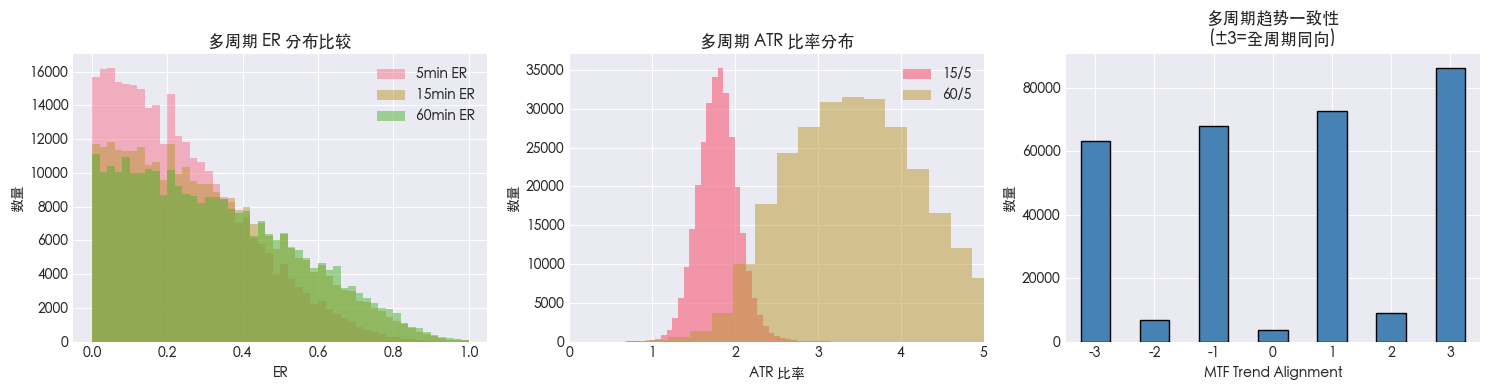


Cell 24 完成: 多时间周期特征 ✅


In [40]:
# ========== Cell 24: 多时间周期特征 (Multi-Timeframe Features) ==========
"""
📌 Section 2: 把 15min / 1h 的信息也加入训练集

思路:
1. 将 5min 数据 resample 到 15min 和 60min
2. 在高周期上计算相同的指标 (KAMA, ER, ATR, slope, chop 等)
3. 使用 floor 对齐，确保不泄露未来信息
4. 合并回 5min 数据

这样模型可以学到:
- "当 1h 在上升趋势、15min 在震荡时，5min 的向下波动多半是 pullback"
"""
print("计算多时间周期特征...")

# ========== 1. Resample to 15min and 60min ==========
print("  Resampling 到 15min 和 60min...")

# 保存原始 5min df
df_5 = df.copy()

# 需要先 reset index 来处理
df_5_reset = df_5.reset_index()
df_5_reset["timestamp_dt"] = pd.to_datetime(df_5_reset["timestamp"].astype(str).str.slice(0, 19))
df_5_reset = df_5_reset.set_index("timestamp_dt")

# Resample 函数
def resample_ohlcv(df_src: pd.DataFrame, freq: str) -> pd.DataFrame:
    """将 OHLCV 数据 resample 到指定频率"""
    df_resampled = df_src.resample(freq).agg({
        "open": "first",
        "high": "max",
        "low": "min",
        "close": "last",
        "volume": "sum",
    }).dropna()
    return df_resampled

df_15 = resample_ohlcv(df_5_reset, "15T")
df_60 = resample_ohlcv(df_5_reset, "60T")

print(f"  15min bars: {len(df_15):,}")
print(f"  60min bars: {len(df_60):,}")

# ========== 2. 在高周期上计算指标 ==========
def calc_htf_features(df_htf: pd.DataFrame, suffix: str, 
                      n_atr: int = 14, n_er: int = 14, l_back: int = 14) -> pd.DataFrame:
    """
    在高周期数据上计算核心指标
    """
    df_htf = df_htf.copy()
    
    # Log close
    df_htf["log_close"] = np.log(df_htf["close"])
    
    # ATR
    prev_close = df_htf["close"].shift(1)
    tr1 = df_htf["high"] - df_htf["low"]
    tr2 = (df_htf["high"] - prev_close).abs()
    tr3 = (df_htf["low"] - prev_close).abs()
    df_htf["tr"] = np.maximum(np.maximum(tr1, tr2), tr3)
    df_htf[f"atr_{suffix}"] = df_htf["tr"].ewm(span=n_atr, adjust=False).mean()
    
    # ER
    change = (df_htf["close"] - df_htf["close"].shift(n_er)).abs()
    volatility = df_htf["close"].diff().abs().rolling(window=n_er).sum()
    df_htf[f"er_{suffix}"] = (change / volatility.replace(0, np.nan)).clip(0, 1)
    
    # Slope (简化版)
    df_htf[f"slope_{suffix}"] = df_htf["log_close"].diff(5) / 5
    df_htf[f"slope_{suffix}_norm"] = df_htf[f"slope_{suffix}"] / df_htf[f"atr_{suffix}"].replace(0, np.nan) * 100
    
    # Chop (简化版)
    chop_window = min(14, l_back)
    atr_sum = df_htf["tr"].rolling(window=chop_window).sum()
    high_max = df_htf["high"].rolling(window=chop_window).max()
    low_min = df_htf["low"].rolling(window=chop_window).min()
    hl_range = high_max - low_min
    df_htf[f"chop_{suffix}"] = (np.log10(atr_sum / hl_range.replace(0, np.nan)) / np.log10(chop_window)).clip(0, 1)
    
    # 趋势方向 (基于 slope)
    df_htf[f"trend_dir_{suffix}"] = np.sign(df_htf[f"slope_{suffix}"])
    
    # 只返回需要的列
    result_cols = [f"atr_{suffix}", f"er_{suffix}", f"slope_{suffix}_norm", 
                   f"chop_{suffix}", f"trend_dir_{suffix}"]
    
    return df_htf[result_cols]


print("  计算 15min 指标...")
df_15_features = calc_htf_features(df_15, "15", n_atr=14, n_er=14, l_back=14)

print("  计算 60min 指标...")
df_60_features = calc_htf_features(df_60, "60", n_atr=14, n_er=14, l_back=14)

# ========== 3. Floor 对齐并 merge 回 5min ==========
print("  对齐并合并到 5min 数据...")

# ⚠️ 重要：使用前一个已完成的高周期 bar，避免未来信息泄露
# 例如：在 9:35 时，floor("15T") = 9:30，但 9:30-9:45 的 15min bar 包含 9:40 的未来信息
# 正确做法：减去一个周期，使用前一个已完成的 bar
df_5_reset["t_15"] = df_5_reset.index.floor("15T") - pd.Timedelta("15min")
df_5_reset["t_60"] = df_5_reset.index.floor("60T") - pd.Timedelta("60min")

# Merge 15min features
df_15_features = df_15_features.reset_index()
df_15_features = df_15_features.rename(columns={"timestamp_dt": "t_15"})
df_5_merged = df_5_reset.reset_index().merge(
    df_15_features, on="t_15", how="left"
)

# Merge 60min features
df_60_features = df_60_features.reset_index()
df_60_features = df_60_features.rename(columns={"timestamp_dt": "t_60"})
df_5_merged = df_5_merged.merge(
    df_60_features, on="t_60", how="left"
)

# 将特征添加回原始 df
df_5_merged = df_5_merged.set_index("timestamp")

for col in ["atr_15", "er_15", "slope_15_norm", "chop_15", "trend_dir_15",
            "atr_60", "er_60", "slope_60_norm", "chop_60", "trend_dir_60"]:
    if col in df_5_merged.columns:
        df[col] = df_5_merged[col]

# ========== 4. 多周期比率特征 ==========
# ATR 比率 (波动率跨周期比)
df["atr_ratio_15_5"] = df["atr_15"] / df["atr"].replace(0, np.nan)
df["atr_ratio_60_5"] = df["atr_60"] / df["atr"].replace(0, np.nan)

# 多周期趋势一致性
df["mtf_trend_alignment"] = (
    np.sign(df["slope_norm"]) + 
    df["trend_dir_15"].fillna(0) + 
    df["trend_dir_60"].fillna(0)
)

# ========== 统计 ==========
print("\n=== 多周期特征统计 ===")
print(f"15min ER: mean={df['er_15'].mean():.4f}")
print(f"60min ER: mean={df['er_60'].mean():.4f}")
print(f"ATR ratio (15/5): mean={df['atr_ratio_15_5'].mean():.4f}")
print(f"ATR ratio (60/5): mean={df['atr_ratio_60_5'].mean():.4f}")

mtf_counts = df["mtf_trend_alignment"].value_counts().sort_index()
print(f"\n多周期趋势一致性分布:")
for k, v in mtf_counts.items():
    print(f"  {int(k):+d}: {v:,} ({v/len(df)*100:.1f}%)")

plt.rcParams['font.sans-serif'] = ['Heiti TC', 'PingFang SC']

# 可视化
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# ER 比较: 5min vs 15min vs 60min
axes[0].hist(df["er"].dropna(), bins=50, alpha=0.5, label="5min ER")
axes[0].hist(df["er_15"].dropna(), bins=50, alpha=0.5, label="15min ER")
axes[0].hist(df["er_60"].dropna(), bins=50, alpha=0.5, label="60min ER")
axes[0].set_xlabel("ER")
axes[0].set_ylabel("数量")
axes[0].set_title("多周期 ER 分布比较")
axes[0].legend()

# ATR 比率分布
axes[1].hist(df["atr_ratio_15_5"].dropna(), bins=50, alpha=0.7, label="15/5")
axes[1].hist(df["atr_ratio_60_5"].dropna(), bins=50, alpha=0.5, label="60/5")
axes[1].set_xlabel("ATR 比率")
axes[1].set_ylabel("数量")
axes[1].set_title("多周期 ATR 比率分布")
axes[1].legend()
axes[1].set_xlim(0, 5)

# 多周期趋势一致性
mtf_counts.plot(kind="bar", ax=axes[2], color="steelblue", edgecolor="black")
axes[2].set_xlabel("MTF Trend Alignment")
axes[2].set_ylabel("数量")
axes[2].set_title("多周期趋势一致性\n(±3=全周期同向)")
axes[2].set_xticklabels([f"{int(x)}" for x in mtf_counts.index], rotation=0)

plt.tight_layout()
plt.show()

print("\nCell 24 完成: 多时间周期特征 ✅")


计算滞后特征...
  添加 regime 滞后特征...
  添加核心特征滞后版本...
  添加窗口统计特征...
  添加特征变化率...

=== 滞后特征统计 ===
regime_trend_ratio: mean=0.2112 (趋势占比)
regime_changes_N: mean=0.39 (每10bar变化次数)
regime_consec: max=305, mean=31.60

新增滞后/变化特征数量: 39


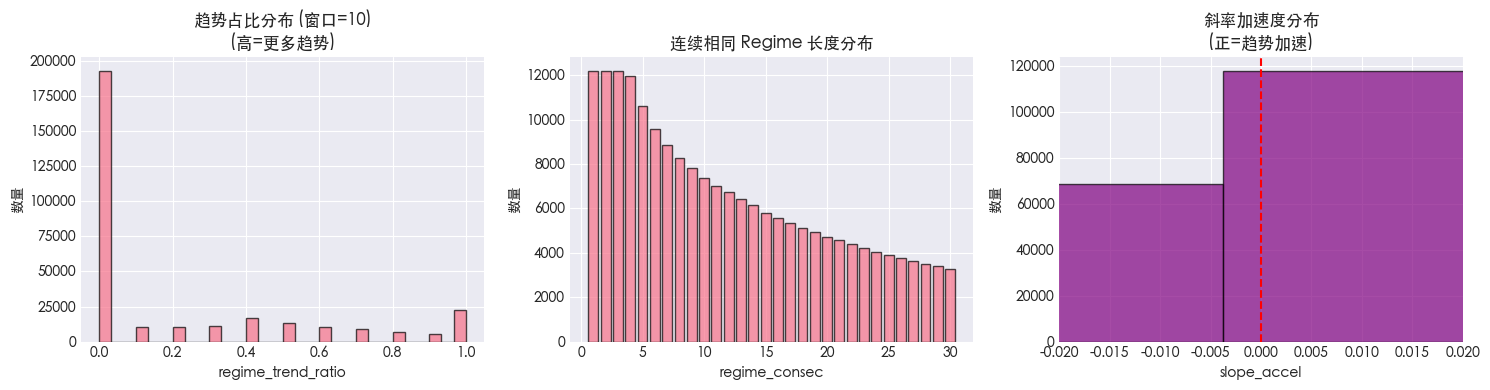


Cell 25 完成: 滞后特征 ✅


In [41]:
# ========== Cell 25: 滞后特征 (Lagged Features) ==========
"""
📌 Section 3: 加入前几个 K 线的标签和滞后特征

添加:
1. 历史 regime 标签: regime_lag1, regime_lag2, regime_lag3，如果过去几根都在趋势，那当前更可能也在趋势
2. 历史核心特征的滞后版本
3. 窗口统计特征 (如: 最近 10 根中 regime=±1 的比例)

这些直接模拟 "盘感"：
- 模型看到"连续三根 regime=+1 且 slope_norm 都放大"，自然会把当前也判为趋势段
"""
print("计算滞后特征...")

# ========== 配置 ==========
LAG_K = 3  # 滞后期数
WINDOW_N = 10  # 统计窗口

# ========== 1. 历史 regime 标签 ==========
print("  添加 regime 滞后特征...")
for lag in range(1, LAG_K + 1):
    df[f"regime_lag{lag}"] = df["regime"].shift(lag)

# ========== 2. 核心特征的滞后版本 ==========
print("  添加核心特征滞后版本...")

# 选择需要做滞后的核心特征
lag_features = [
    "er",
    "slope_norm",
    "dist_norm",
    "chop",
    "r2",
    "range_z",
    "dir_vol_ratio",
    "bull_bear_diff",
    "avg_body_ratio",
]

for col in lag_features:
    if col in df.columns:
        for lag in range(1, LAG_K + 1):
            df[f"{col}_lag{lag}"] = df[col].shift(lag)

# ========== 3. 窗口统计特征 ==========
print("  添加窗口统计特征...")

# 最近 N 根中 regime 的统计
# 趋势比例 (regime = ±1 的比例)
df["regime_trend_ratio"] = df["regime"].abs().rolling(WINDOW_N).mean()

# 上涨趋势比例 (regime = +1 的比例)
df["regime_up_ratio"] = (df["regime"] == 1).astype(int).rolling(WINDOW_N).mean()

# 下跌趋势比例 (regime = -1 的比例)
df["regime_down_ratio"] = (df["regime"] == -1).astype(int).rolling(WINDOW_N).mean()

# regime 变化次数 (市场结构变化频率)
df["regime_change"] = (df["regime"] != df["regime"].shift(1)).astype(int)
df["regime_changes_N"] = df["regime_change"].rolling(WINDOW_N).sum()

# 连续 regime 标签数量 (模拟"趋势持续性")
def calc_consecutive_regime(regime: np.ndarray) -> np.ndarray:
    """计算连续相同 regime 的长度"""
    n = len(regime)
    consec = np.zeros(n, dtype=np.int32)
    
    for i in range(n):
        if i == 0 or np.isnan(regime[i]) or np.isnan(regime[i-1]):
            consec[i] = 1
        elif regime[i] == regime[i-1]:
            consec[i] = consec[i-1] + 1
        else:
            consec[i] = 1
    
    return consec

df["regime_consec"] = calc_consecutive_regime(df["regime"].values.astype(np.float64))

# ========== 4. 特征变化率 (momentum of features) ==========
print("  添加特征变化率...")

# 核心特征的变化率
momentum_features = ["er", "slope_norm", "chop", "range_z"]

for col in momentum_features:
    if col in df.columns:
        # 1 期变化
        df[f"{col}_diff1"] = df[col].diff(1)
        # 3 期变化
        df[f"{col}_diff3"] = df[col].diff(3)

# ========== 5. 趋势加速/减速指标 ==========
# slope_norm 的变化 (趋势加速)
df["slope_accel"] = df["slope_norm"].diff(1)
df["slope_accel_ma3"] = df["slope_accel"].rolling(3).mean()

# ========== 统计 ==========
print("\n=== 滞后特征统计 ===")
print(f"regime_trend_ratio: mean={df['regime_trend_ratio'].mean():.4f} (趋势占比)")
print(f"regime_changes_N: mean={df['regime_changes_N'].mean():.2f} (每{WINDOW_N}bar变化次数)")
print(f"regime_consec: max={df['regime_consec'].max()}, mean={df['regime_consec'].mean():.2f}")

# 检查滞后特征数量
lag_cols = [c for c in df.columns if "_lag" in c or "_diff" in c]
print(f"\n新增滞后/变化特征数量: {len(lag_cols)}")

plt.rcParams['font.sans-serif'] = ['Heiti TC', 'PingFang SC']

# 可视化
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# regime_trend_ratio 分布
axes[0].hist(df["regime_trend_ratio"].dropna(), bins=30, edgecolor="black", alpha=0.7)
axes[0].set_xlabel("regime_trend_ratio")
axes[0].set_ylabel("数量")
axes[0].set_title(f"趋势占比分布 (窗口={WINDOW_N})\n(高=更多趋势)")

# regime_consec 分布
consec_counts = df["regime_consec"].value_counts().sort_index()
consec_counts_plot = consec_counts[consec_counts.index <= 30]  # 限制显示范围
axes[1].bar(consec_counts_plot.index, consec_counts_plot.values, edgecolor="black", alpha=0.7)
axes[1].set_xlabel("regime_consec")
axes[1].set_ylabel("数量")
axes[1].set_title("连续相同 Regime 长度分布")

# slope_accel 分布
axes[2].hist(df["slope_accel"].dropna(), bins=50, edgecolor="black", alpha=0.7, color="purple")
axes[2].axvline(x=0, color="red", linestyle="--")
axes[2].set_xlabel("slope_accel")
axes[2].set_ylabel("数量")
axes[2].set_title("斜率加速度分布\n(正=趋势加速)")
axes[2].set_xlim(-0.02, 0.02)

plt.tight_layout()
plt.show()

print("\nCell 25 完成: 滞后特征 ✅")


In [48]:
# ========== Cell 11: 多时间周期辅助 Regime 标注 (MTF-Assisted Labeling) ==========
"""
📌 目标: 在打标签时让高周期结构成为"额外的裁判"
  - 5m 趋势如果和 60m 完全反向 → 降权或打回 0 (可能是 pullback)
  - 5m 震荡如果在强 60m 趋势中 → 标记为 "range_inside_trend"
  
📌 设计原则:
  - 5min 特征占 ~80% 决策权重
  - 15min/60min 占 ~20%，仅起辅助作用
  - 多周期同向时增加置信度
  - 高周期强反向时降低趋势概率
"""
print("=" * 70)
print("🔄 多时间周期辅助 Regime 标注")
print("=" * 70)

# ========== 1. 定义高周期强趋势条件 ==========
# 15min 强趋势
STRONG_15_SLOPE_THR = 0.8
STRONG_15_ER_THR = 0.4
STRONG_15_CHOP_THR = 0.6

# 60min 强趋势
STRONG_60_SLOPE_THR = 1.0
STRONG_60_ER_THR = 0.4
STRONG_60_CHOP_THR = 0.6

# MTF 权重
W_15 = 0.15  # 15min 权重
W_60 = 0.15  # 60min 权重
THR_TREND_SCORE = 1.0  # 趋势得分阈值

# 计算高周期强趋势标记
df["strong_15"] = (
    (df["slope_15_norm"].abs() > STRONG_15_SLOPE_THR) & 
    (df["er_15"] > STRONG_15_ER_THR) & 
    (df["chop_15"] < STRONG_15_CHOP_THR)
).astype(int)

df["strong_60"] = (
    (df["slope_60_norm"].abs() > STRONG_60_SLOPE_THR) & 
    (df["er_60"] > STRONG_60_ER_THR) & 
    (df["chop_60"] < STRONG_60_CHOP_THR)
).astype(int)

print(f"\n强 15min 趋势 bar 比例: {df['strong_15'].mean()*100:.1f}%")
print(f"强 60min 趋势 bar 比例: {df['strong_60'].mean()*100:.1f}%")

# ========== 2. 带 MTF 辅助的趋势识别 ==========
def identify_trend_with_mtf(df: pd.DataFrame, is_range: np.ndarray,
                             w_15: float = 0.15, w_60: float = 0.15,
                             thr_score: float = 1.0) -> np.ndarray:
    """
    带多时间周期辅助的趋势识别
    
    趋势得分 = base_score + mtf_bonus - mtf_penalty
    - base_score: 基于 5min 的原始条件 (0-1)
    - mtf_bonus: 高周期同向加分
    - mtf_penalty: 高周期反向减分
    """
    n = len(df)
    regime = np.zeros(n, dtype=np.int32)
    trend_scores = np.zeros(n, dtype=np.float64)
    
    # 预提取数组 (加速)
    er = df["er"].values
    chop = df["chop"].values
    slope_norm = df["slope_norm"].values
    dist_norm = df["dist_norm"].values
    d_barrier = df["d_barrier"].values
    close = df["close"].values
    
    # 高周期信息
    trend_dir_15 = df["trend_dir_15"].fillna(0).values
    trend_dir_60 = df["trend_dir_60"].fillna(0).values
    strong_15 = df["strong_15"].fillna(0).values
    strong_60 = df["strong_60"].fillna(0).values
    er_15 = df["er_15"].fillna(0).values
    er_60 = df["er_60"].fillna(0).values
    
    for t in range(n): 
        if is_range[t]: # 震荡直接标记为 0
            regime[t] = 0
            continue
        
        if np.isnan(slope_norm[t]) or np.isnan(er[t]):
            continue
        
        # ========== 5min 基础得分 ==========
        dir_5 = np.sign(slope_norm[t])
        if dir_5 == 0:
            continue
        
        # 方向一致性 (使用未来 L_FWD 的收益)
        future_idx = min(t + L_FWD, n - 1)
        future_direction = np.sign(close[future_idx] - close[t])
        direction_consistent = (dir_5 == future_direction) and (dir_5 != 0)
        
        # 构建 base_score (0-1 区间)
        base_score = 0.0
        
        # 方向一致 +0.3
        if direction_consistent:
            base_score += 0.3
        
        # 斜率强度 +0.2
        if abs(slope_norm[t]) > THR_SLOPE_NORM:
            base_score += 0.2
        
        # 趋势质量 (ER 高或 chop 低) +0.25
        if er[t] > THR_ER_HIGH or chop[t] < THR_CHOP_LOW:
            base_score += 0.25
        
        # 价格偏离 +0.15
        if abs(dist_norm[t]) > THR_DIST_NORM:
            base_score += 0.15
        
        # Triple barrier 确认 +0.1
        if d_barrier[t] == dir_5:
            base_score += 0.1
        
        # ========== MTF 加减分 ==========
        mtf_adjustment = 0.0
        
        # 15min 同向加分
        if trend_dir_15[t] == dir_5 and trend_dir_15[t] != 0:
            mtf_adjustment += w_15
        
        # 60min 同向加分
        if trend_dir_60[t] == dir_5 and trend_dir_60[t] != 0:
            mtf_adjustment += w_60
        
        # 高周期强反向 → 大幅减分 (可能是 counter-trend pullback)
        if strong_60[t] and trend_dir_60[t] == -dir_5:
            final_score *= 0.5
        
        # 多周期完全混乱 → 小幅降权
        mtf_align = dir_5 + trend_dir_15[t] + trend_dir_60[t]
        if abs(mtf_align) <= 1:
            base_score *= 0.85
        
        # 最终得分
        final_score = base_score + mtf_adjustment
        trend_scores[t] = final_score
        
        # 判定
        if final_score >= thr_score:
            regime[t] = int(dir_5)
    
    return regime, trend_scores


# ========== 3. 带 MTF 过滤的震荡识别 ==========
def identify_range_with_mtf_filter(df: pd.DataFrame, is_range_5m: np.ndarray) -> tuple:
    """
    在 5min 震荡基础上，标记"强趋势中的震荡"
    
    返回:
        is_range_final: 最终震荡标记
        is_range_in_trend: 强趋势中的震荡标记 (从训练集剔除)
    """
    n = len(df)
    is_range_final = is_range_5m.copy()
    is_range_in_trend = np.zeros(n, dtype=bool)
    
    strong_60 = df["strong_60"].fillna(0).values
    er_60 = df["er_60"].fillna(0.5).values
    chop_60 = df["chop_60"].fillna(0.5).values
    
    for t in range(n):
        if is_range_5m[t]:
            # 如果 60min 是强趋势，标记为 "range_inside_trend"
            if strong_60[t] and er_60[t] > 0.45 and chop_60[t] < 0.55:
                is_range_in_trend[t] = True
                # 可选: 保持 is_range_final[t] = True (仍然是震荡，但训练时剔除)
    
    return is_range_final, is_range_in_trend


# ========== 4. 执行 MTF 辅助标注 ==========
print("\n执行 MTF 辅助标注...")

# 使用原始的 5m 震荡判定
is_range_5m = df["is_range_extended"].values if "is_range_extended" in df.columns else df["is_range"].values

# MTF 过滤震荡
is_range_mtf, is_range_in_trend = identify_range_with_mtf_filter(df, is_range_5m)

# MTF 辅助趋势识别
regime_mtf_raw, trend_scores = identify_trend_with_mtf(
    df, is_range_mtf, 
    w_15=W_15, w_60=W_60, thr_score=THR_TREND_SCORE
)

# 应用平滑 (与原方法相同)
regime_mtf = smooth_regime_labels(regime_mtf_raw, MIN_TREND_LEN, SMOOTH_WINDOW)

# 保存结果
df["regime_mtf"] = regime_mtf
df["trend_score_mtf"] = trend_scores
df["is_range_in_trend"] = is_range_in_trend

# ========== 5. 统计对比 ==========
print("\n" + "=" * 70)
print("📊 原始 vs MTF 辅助 Regime 分布对比")
print("=" * 70)

# 原始分布
orig_counts = df["regime"].value_counts().sort_index()
mtf_counts = df["regime_mtf"].value_counts().sort_index()

print("\n原始方法:")
for k, v in orig_counts.items():
    label = {-1: "DOWN", 0: "RANGE", 1: "UP"}.get(k, str(k))
    print(f"  {label}: {v:,} ({v/len(df)*100:.2f}%)")

print("\nMTF 辅助方法:")
for k, v in mtf_counts.items():
    label = {-1: "DOWN", 0: "RANGE", 1: "UP"}.get(k, str(k))
    print(f"  {label}: {v:,} ({v/len(df)*100:.2f}%)")

# 标签变化统计
changed = (df["regime"] != df["regime_mtf"]).sum()
print(f"\n标签变化数量: {changed:,} ({changed/len(df)*100:.2f}%)")

# 强趋势中的震荡数量
range_in_trend_count = df["is_range_in_trend"].sum()
print(f"强趋势中的震荡 bar: {range_in_trend_count:,} ({range_in_trend_count/len(df)*100:.2f}%)")

print("\nCell 11 完成: MTF 辅助标注 ✅")


🔄 多时间周期辅助 Regime 标注

强 15min 趋势 bar 比例: 0.0%
强 60min 趋势 bar 比例: 0.0%

执行 MTF 辅助标注...

📊 原始 vs MTF 辅助 Regime 分布对比

原始方法:
  DOWN: 25,109 (8.12%)
  RANGE: 244,054 (78.88%)
  UP: 40,249 (13.01%)

MTF 辅助方法:
  DOWN: 16,300 (5.27%)
  RANGE: 266,039 (85.98%)
  UP: 27,073 (8.75%)

标签变化数量: 29,699 (9.60%)
强趋势中的震荡 bar: 0 (0.00%)

Cell 11 完成: MTF 辅助标注 ✅


In [62]:
# ========== Cell: 原始 vs MTF 对比（修复版：reset_output + 每次重建模型） ==========
import numpy as np
import pandas as pd
from pathlib import Path

from bokeh.layouts import row as bokeh_row, column
from bokeh.io import output_file, save, show, reset_output, output_notebook
from bokeh.models import BoxAnnotation, ColumnDataSource, HoverTool, Range1d
from bokeh.plotting import figure

# 确保 Notebook 输出已启用
output_notebook()

print("生成原始 vs MTF 对比图表（修正版，使用 reset_output()）...")

# 输出目录兜底
if "OUTPUT_DIR_CHARTS" not in globals():
    OUTPUT_DIR_CHARTS = Path("./charts")
OUTPUT_DIR_CHARTS.mkdir(parents=True, exist_ok=True)

# 准备绘图数据（确保变量 df 已在环境中）
df_plot = df.reset_index().copy()
df_plot["timestamp_dt"] = pd.to_datetime(df_plot["timestamp"].astype(str).str.slice(0, 19))
df_plot["date"] = df_plot["timestamp_dt"].dt.date

# 必要列检查
required_cols = ["open", "high", "low", "close", "regime", "regime_mtf", "date", "timestamp_dt"]
missing = [c for c in required_cols if c not in df_plot.columns]
if missing:
    raise ValueError(f"缺少必要列: {missing}")

# 有效交易日（至少 50 根 bar）
day_counts = df_plot.groupby("date").size()
valid_dates = day_counts[day_counts >= 50].index.tolist()
if len(valid_dates) == 0:
    raise ValueError("没有满足 >=50 bars 的交易日可绘制，请检查数据或标签是否大量 NaN。")

# 随机选择若干日期
np.random.seed(None) # 42的意思是随机但可复现，如果需要每次不同可改为 None
sample_dates = sorted(np.random.choice(valid_dates, size=min(5, len(valid_dates)), replace=False))
print(f"选择 {len(sample_dates)} 个日期进行对比:")
for d in sample_dates:
    print(f"  - {d}")

# 单日绘图函数（每次调用都会创建全新模型）
def plot_kline_comparison(df_day: pd.DataFrame, regime_col: str, title: str, width: int = 600, height: int = 350):
    d = df_day.copy().reset_index(drop=True)
    d["idx"] = np.arange(len(d))
    d["regime_filled"] = d[regime_col].fillna(0).astype(int)
    d["bar_color"] = np.where(d["close"] >= d["open"], "#26a69a", "#ef5350")
    d["top"] = np.maximum(d["open"], d["close"])
    d["bottom"] = np.minimum(d["open"], d["close"])

    source = ColumnDataSource(d)

    y_min = float(d["low"].min() * 0.9995)
    y_max = float(d["high"].max() * 1.0005)

    p = figure(
        width=width, height=height,
        title=title,
        x_range=Range1d(-1, len(d)),
        y_range=Range1d(y_min, y_max),
        tools="pan,wheel_zoom,box_zoom,reset,save,crosshair",
        background_fill_color="#fafafa",
    )

    # regime 背景色按连续段绘制（BoxAnnotation）
    regime_colors = {-1: "#ffcccc", 0: "#ffffcc", 1: "#ccffcc"}
    d["regime_change"] = (d["regime_filled"] != d["regime_filled"].shift()).cumsum()
    groups = d.groupby("regime_change").agg(start_idx=("idx", "first"), end_idx=("idx", "last"), regime=("regime_filled", "first"))

    for _, g in groups.iterrows():
        r = int(g["regime"])
        box = BoxAnnotation(
            left=float(g["start_idx"]) - 0.5,
            right=float(g["end_idx"]) + 0.5,
            fill_color=regime_colors.get(r, "#ffffff"),
            fill_alpha=0.30,
            level="underlay",
        )
        p.add_layout(box)

    # 影线与实体（每次使用新的 ColumnDataSource）
    p.segment(x0="idx", y0="high", x1="idx", y1="low", source=source, color="black", line_width=1)
    p.vbar(x="idx", width=0.65, top="top", bottom="bottom", source=source, fill_color="bar_color", line_color="black", line_width=0.5)

    hover = HoverTool(
        tooltips=[
            ("时间", "@timestamp_dt{%F %T}"),
            ("开", "@open{0.2f}"),
            ("高", "@high{0.2f}"),
            ("低", "@low{0.2f}"),
            ("收", "@close{0.2f}"),
            (f"{regime_col}", "@regime_filled"),
        ],
        formatters={"@timestamp_dt": "datetime"},
        mode="vline",
    )
    p.add_tools(hover)
    p.xaxis.visible = False
    return p

# 生成 layout 的函数：每次调用构建全新模型集合
def build_comparison_layout(df_plot: pd.DataFrame, sample_dates):
    rows = []
    for date in sample_dates:
        df_day = df_plot[df_plot["date"] == date].copy()
        if len(df_day) < 30:
            continue

        orig_counts = df_day["regime"].fillna(0).astype(int).value_counts().to_dict()
        mtf_counts  = df_day["regime_mtf"].fillna(0).astype(int).value_counts().to_dict()
        changes = (df_day["regime"].fillna(0).astype(int) != df_day["regime_mtf"].fillna(0).astype(int)).sum()

        title_orig = f"{date} - 原始 | D:{orig_counts.get(-1,0)} R:{orig_counts.get(0,0)} U:{orig_counts.get(1,0)}"
        title_mtf  = f"{date} - MTF  | D:{mtf_counts.get(-1,0)} R:{mtf_counts.get(0,0)} U:{mtf_counts.get(1,0)} | 变化:{changes}"

        p_orig = plot_kline_comparison(df_day, "regime", title_orig, width=550)
        p_mtf  = plot_kline_comparison(df_day, "regime_mtf", title_mtf, width=550)
        rows.append(bokeh_row(p_orig, p_mtf))

    return column(*rows) if rows else None

# ---- 清理先前 notebook state，防止残留模型冲突 ----
reset_output()

# ---- 使用一套 layout 用于 show（每次都重建） ----
layout_show = build_comparison_layout(df_plot, sample_dates)
if layout_show is not None:
    try:
        show(layout_show)
    except RuntimeError as e:
        print("第一次 show() 出错，尝试 reset_output() 并重试：", e)
        reset_output()
        layout_show = build_comparison_layout(df_plot, sample_dates)
        show(layout_show)
else:
    print("⚠️ 没有生成任何图（可能 sample_dates 对应日数据不足）。")

# ---- 再次 reset 并为保存重建一套独立模型（关键：不能复用已用于 show 的模型） ----
reset_output()
layout_save = build_comparison_layout(df_plot, sample_dates)
if layout_save is not None:
    chart_path = OUTPUT_DIR_CHARTS / "regime_comparison_orig_vs_mtf.html"
    output_file(str(chart_path), title="Regime Comparison: Original vs MTF")
    save(layout_save, filename=str(chart_path))
    print(f"\n对比图已保存到: {chart_path}")
else:
    print("⚠️ 无图可保存。")

# ---- 汇总统计（不涉及 Bokeh 模型） ----
print("\n" + "=" * 70)
print("📊 方法对比汇总")
print("=" * 70)

orig_reg = df["regime"].fillna(0).astype(int)
mtf_reg  = df["regime_mtf"].fillna(0).astype(int)

print("\n标签变化矩阵 (行=原始, 列=MTF):")
change_matrix = pd.crosstab(orig_reg, mtf_reg, margins=True, margins_name="Total")
print(change_matrix)

orig_trend_rate = (orig_reg != 0).mean() * 100
mtf_trend_rate  = (mtf_reg  != 0).mean() * 100
print(f"\n趋势识别率:")
print(f"  原始方法: {orig_trend_rate:.2f}%")
print(f"  MTF 辅助: {mtf_trend_rate:.2f}%")

Loading BokehJS ...

生成原始 vs MTF 对比图表（修正版，使用 reset_output()）...
选择 5 个日期进行对比:
  - 2022-05-02
  - 2022-08-29
  - 2023-06-02
  - 2024-01-02
  - 2025-02-10

对比图已保存到: market_cycle/charts/regime_comparison_orig_vs_mtf.html

📊 方法对比汇总

标签变化矩阵 (行=原始, 列=MTF):
regime_mtf     -1       0      1   Total
regime                                  
-1          14535   10574      0   25109
0            1765  240197   2092  244054
1               0   15268  24981   40249
Total       16300  266039  27073  309412

趋势识别率:
  原始方法: 21.12%
  MTF 辅助: 14.02%


In [64]:
# ========== Cell 26: 最终特征矩阵 & 数据导出 (Final Feature Matrix) ==========
"""
📌 最终准备机器学习训练数据

关键更新:
1. 使用 regime_mtf (多周期辅助标注) 作为标签 (可切换为原始 regime)
2. 排除原始尺度特征 (kama, atr, tr, bar_range)，使用归一化版本 (*_z)
3. d_barrier 只用于标注，不输入模型训练 (它使用了未来信息)

泄露检查清单:
✅ 无泄露: 使用 shift/rolling 的过去窗口特征
✅ 无泄露: 使用 expanding (累积到当前) 的特征
✅ 无泄露: 多周期特征使用 floor - 1 周期对齐
❌ 泄露: d_barrier (使用了未来路径) → 排除
"""
print("准备最终特征矩阵...")

# ═══════════════════════════════════════════════════════════════════════════════
# ⚠️ 选择使用哪个 regime 作为标签
# ═══════════════════════════════════════════════════════════════════════════════
USE_MTF_REGIME = True  # True: 使用 MTF 辅助标签, False: 使用原始标签，实测MTF不如原始标签

LABEL_COL = "regime_mtf" if USE_MTF_REGIME else "regime"
print(f"\n使用标签列: {LABEL_COL}")

# ========== 1. 定义特征列表 (已排除原始尺度特征) ==========

# 基础波动特征 (已归一化)
volatility_features = [
    "log_return",       # 当前收益 (无量纲)
    "range_atr",        # 区间/ATR (比例)
    "range_z",          # Range z-score
    "range_z_ma5",      # Range z-score 均值
    "atr_z",            # ATR 归一化
    "tr_z",             # TR 归一化 (如果存在)
    "bar_range_z",      # Bar range 归一化 (如果存在)
]

# 趋势特征 (无泄露 - 全部使用过去窗口)
trend_features = [
    "er",               # 效率因子 [0,1]
    "slope_norm",       # KAMA 斜率标准化 (相对 ATR)
    "dist_norm",        # 价格偏离度 (相对 ATR)
    "kama_z",           # KAMA 归一化 (如果存在)
    "beta",             # 回归斜率
    "r2",               # R² [0,1]
    "slope_10_norm",    # 10-bar 斜率
    "slope_30_norm",    # 30-bar 斜率
    "slope_60_norm",    # 60-bar 斜率
    "trend_alignment",  # 多尺度一致性 [-3, +3]
]

# 震荡特征 (无泄露)
range_features = [
    "chop",             # Choppiness Index [0,1]
    "overlap_ratio",    # 重叠度 [0,1]
    "dir_vol_ratio",    # 方向性波动 [0,1]
    "vol_up_ratio",     # 上涨波动占比 [0,1]
]

# Bar 结构特征 (无泄露)
bar_structure_features = [
    "is_bull",          # 阳线 {0,1}
    "is_bear",          # 阴线 {0,1}
    "bull_ratio",       # 阳线比例 [0,1]
    "bear_ratio",       # 阴线比例 [0,1]
    "bull_bear_diff",   # 多空差 [-1,1]
    "consec_bull",      # 连续阳线
    "consec_bear",      # 连续阴线
    "body_ratio",       # 实体比例 [0,1]
    "upper_wick_ratio", # 上影线比例 [0,1]
    "lower_wick_ratio", # 下影线比例 [0,1]
    "total_wick_ratio", # 总影线比例 [0,1]
    "avg_body_ratio",   # 窗口平均实体比例
    "avg_total_wick_ratio",  # 窗口平均影线比例
    "doji_like_ratio",  # 小实体大影线比例 [0,1]
]

# 腿结构特征 (无泄露 - 全部基于过去)
leg_features = [
    "legA_dir", "legA_prev1_dir", "legA_prev2_dir", "legA_changes_10",
    "legB_dir", "legB_prev1_dir", "legB_prev2_dir", "legB_changes_10",
    "legC_dir", "legC_prev1_dir", "legC_prev2_dir", "legC_changes_10",
]

# Phase 特征 (无泄露)
phase_features = [
    "spike_score",      # Spike 分数 [0,1]
    "channel_score",    # Channel 分数 [0,1]
    "phase",            # Phase {0,1,2}
]

# 日内特征 (无泄露 - expanding)
intraday_features = [
    "pos_in_day_range", # 日内位置 [0,1]
    "dist_to_open",     # 距开盘价
    "day_return",       # 日内收益
    "bar_of_day",       # 当日第几根 bar
    "time_of_day_norm", # 时间归一化 [0,1]
    "near_day_high",    # 接近日高 {0,1}
    "near_day_low",     # 接近日低 {0,1}
    "near_open",        # 接近开盘 {0,1}
    "is_open_range",    # 开盘阶段 {0,1}
    "is_close_range",   # 收盘阶段 {0,1}
]

# 多周期特征 (无泄露 - 使用 floor-1 对齐)
mtf_features = [
    "er_15", "slope_15_norm", "chop_15", "trend_dir_15",
    "er_60", "slope_60_norm", "chop_60", "trend_dir_60",
    "atr_ratio_15_5", "atr_ratio_60_5", "mtf_trend_alignment",
]

# 滞后特征 (无泄露 - shift)
lag_features = []
for lag in range(1, 4):
    lag_features.extend([
        f"er_lag{lag}", f"slope_norm_lag{lag}", f"dist_norm_lag{lag}",
        f"chop_lag{lag}", f"r2_lag{lag}", f"range_z_lag{lag}",
        f"dir_vol_ratio_lag{lag}", f"bull_bear_diff_lag{lag}",
        f"avg_body_ratio_lag{lag}",
    ])
'''
# 统计特征 （有可能泄露！）
stat_features = [
    "regime_trend_ratio", "regime_up_ratio", "regime_down_ratio",
    "regime_changes_N", "regime_consec",
    "er_diff1", "er_diff3", "slope_norm_diff1", "slope_norm_diff3",
    "chop_diff1", "chop_diff3", "range_z_diff1", "range_z_diff3",
    "slope_accel", "slope_accel_ma3",
]
'''


stat_features = [
    "er_diff1", "er_diff3", "slope_norm_diff1", "slope_norm_diff3",
    "chop_diff1", "chop_diff3", "range_z_diff1", "range_z_diff3",
    "slope_accel", "slope_accel_ma3",
]

# Volume 特征 (如果存在)
volume_features = ["volume_z", "log_volume_z"]

# ========== 2. 合并所有特征并过滤存在的列 ==========
all_features = (
    volatility_features + trend_features + range_features +
    bar_structure_features + leg_features + phase_features +
    intraday_features + mtf_features + lag_features + stat_features +
    volume_features
)

# 明确排除的特征 (原始尺度或泄露)
EXCLUDED_FEATURES = [
    "kama", "atr", "tr", "bar_range", "volume",  # 原始尺度
    "d_barrier", "regime_raw", "is_range", "is_range_extended",  # 泄露或辅助标记
    "is_range_in_trend", "strong_15", "strong_60", "trend_score_mtf",  # 辅助变量
    # ✅ stat_features 里剔除的泄露列（由真实 regime 统计得来）
    "regime_trend_ratio", "regime_up_ratio", "regime_down_ratio",
    "regime_changes_N", "regime_consec", "regime_change",
]

# 过滤: 只保留存在且未排除的特征
training_features = [
    col for col in all_features 
    if col in df.columns and col not in EXCLUDED_FEATURES
]

print(f"\n可用特征数量: {len(training_features)}")

# ========== 3. 构建训练数据 ==========
# 过滤有效样本 (非 NaN)
df_train = df.dropna(subset=[LABEL_COL]).copy()

# 构建 X 和 y
X = df_train[training_features].copy()
y = df_train[LABEL_COL].astype(int).copy()

# 过滤掉特征中有 NaN 的行
valid_mask = X.notna().all(axis=1)
X = X[valid_mask]
y = y[valid_mask]
df_train = df_train[valid_mask]

print(f"有效样本数: {len(X):,} / {len(df):,} ({len(X)/len(df)*100:.1f}%)")
print(f"特征数: {X.shape[1]}")

# ========== 4. 特征统计 ==========
print("\n" + "=" * 70)
print("📊 特征统计")
print("=" * 70)

# 按类别统计
feature_categories = {
    "波动": volatility_features,
    "趋势": trend_features,
    "震荡": range_features,
    "Bar结构": bar_structure_features,
    "腿结构": leg_features,
    "Phase": phase_features,
    "日内": intraday_features,
    "多周期": mtf_features,
    "滞后": lag_features,
    "统计": stat_features,
}

for cat, feats in feature_categories.items():
    available = [f for f in feats if f in training_features]
    print(f"  {cat}: {len(available)} 个特征")

# ========== 5. 标签分布 ==========
print("\n" + "=" * 70)
print(f"📊 标签分布 ({LABEL_COL})")
print("=" * 70)

label_counts = y.value_counts().sort_index()
for k, v in label_counts.items():
    label_name = {-1: "DOWN (-1)", 0: "RANGE (0)", 1: "UP (+1)"}.get(k, str(k))
    print(f"  {label_name}: {v:,} ({v/len(y)*100:.2f}%)")

# ========== 6. 导出训练数据 ==========
print("\n" + "=" * 70)
print("💾 导出训练数据")
print("=" * 70)

# 准备导出数据
df_train = df_train.reset_index()
df_train["timestamp_str"] = df_train["timestamp"].astype(str)
df_train["year"] = pd.to_datetime(df_train["timestamp_str"].str[:10]).dt.year
df_train["month"] = pd.to_datetime(df_train["timestamp_str"].str[:10]).dt.month
df_train["date"] = df_train["timestamp_str"].str[:10]

# 选择要导出的列
export_meta = ["timestamp_str", "year", "month", "date", "open", "high", "low", "close", "volume"]
export_cols = export_meta + training_features + [LABEL_COL]
export_cols = [c for c in export_cols if c in df_train.columns]

# 去重
export_cols = list(dict.fromkeys(export_cols))

df_export = df_train[export_cols].copy()
df_export = df_export.rename(columns={"timestamp_str": "timestamp", LABEL_COL: "regime"})

# 导出
OUTPUT_TRAIN_CSV = OUTPUT_DIR_FEATURES / "market_cycle_train_data.csv"
OUTPUT_TRAIN_PARQUET = OUTPUT_DIR_FEATURES / "market_cycle_train_data.parquet"

df_export.to_csv(OUTPUT_TRAIN_CSV, index=False)
df_export.to_parquet(OUTPUT_TRAIN_PARQUET, index=False)

print(f"\n📁 训练数据已导出:")
print(f"   - CSV: {OUTPUT_TRAIN_CSV}")
print(f"   - Parquet: {OUTPUT_TRAIN_PARQUET}")
print(f"   - 样本数: {len(df_export):,}")
print(f"   - 特征数: {len(training_features)}")

# ========== 7. 数据泄露最终检查 ==========
print("\n" + "=" * 70)
print("🔍 数据泄露检查")
print("=" * 70)

# 检查是否有未来信息特征
future_keywords = ["_fwd", "future", "barrier"]
potential_leak = [c for c in training_features if any(k in c.lower() for k in future_keywords)]
if potential_leak:
    print(f"⚠️ 发现可能泄露的特征: {potential_leak}")
else:
    print("✅ 未发现明显的数据泄露")

# 检查原始尺度特征
raw_scale_in_train = [c for c in ["kama", "atr", "tr", "bar_range"] if c in training_features]
if raw_scale_in_train:
    print(f"⚠️ 训练集中包含原始尺度特征: {raw_scale_in_train}")
else:
    print("✅ 原始尺度特征已排除")

print("\nCell 26 完成: 最终特征矩阵准备完毕 ✅")
print("\n🎉 数据准备完成！可以开始机器学习训练了！")


准备最终特征矩阵...

使用标签列: regime_mtf

可用特征数量: 110
有效样本数: 285,377 / 309,412 (92.2%)
特征数: 110

📊 特征统计
  波动: 7 个特征
  趋势: 10 个特征
  震荡: 4 个特征
  Bar结构: 14 个特征
  腿结构: 12 个特征
  Phase: 3 个特征
  日内: 10 个特征
  多周期: 11 个特征
  滞后: 27 个特征
  统计: 10 个特征

📊 标签分布 (regime_mtf)
  DOWN (-1): 15,615 (5.47%)
  RANGE (0): 243,744 (85.41%)
  UP (+1): 26,018 (9.12%)

💾 导出训练数据

📁 训练数据已导出:
   - CSV: market_cycle/features/market_cycle_train_data.csv
   - Parquet: market_cycle/features/market_cycle_train_data.parquet
   - 样本数: 285,377
   - 特征数: 110

🔍 数据泄露检查
✅ 未发现明显的数据泄露
✅ 原始尺度特征已排除

Cell 26 完成: 最终特征矩阵准备完毕 ✅

🎉 数据准备完成！可以开始机器学习训练了！


# 市场周期标注规则总结

## 📌 标签定义

| 标签 | 含义 | Al Brooks 对应概念 |
|-----|------|-------------------|
| `-1` | 下跌趋势 | Bear Trend / Sell-off |
| `0` | 震荡/交易区间 | Trading Range / Breakout Mode |
| `+1` | 上涨趋势 | Bull Trend / Rally |

## 📌 标签生成流程 (伪代码)

```
输入: 5分钟K线序列 (OHLCV)

==== 第一阶段: 特征计算 ====
FOR 每根 bar t:
    # 基础序列
    log_return = ln(close_t) - ln(close_{t-1})
    ATR = EMA(TR, 20)
    range_atr = (roll_max - roll_min) / ATR
    
    # KAMA 及衍生
    ER = |close_t - close_{t-20}| / sum(|close_i - close_{i-1}|)  # 效率因子
    KAMA = 自适应移动平均
    slope_norm = (KAMA_t - KAMA_{t-5}) / (5 * ATR)  # 标准化斜率
    dist_norm = (close_t - KAMA_t) / ATR  # 价格偏离度
    
    # 结构特征
    R² = 线性回归拟合度 (窗口=20)
    chop = Choppiness Index (基于ATR)
    overlap_ratio = 相邻bar重叠度
    
    # Triple Barrier (使用未来信息，仅用于标注)
    d_barrier = 先触及 +1.5*ATR 上轨 → +1
               先触及 -1.5*ATR 下轨 → -1
               时间截止 (12 bar) → sign(收益)

==== 第二阶段: 震荡区间识别 (Step 1) ====
FOR 每根 bar t:
    震荡候选条件:
        - ER < 0.25  (走势不"直")
        - chop > 0.75  (震荡度高)
        - range_atr < 3.5 OR R² < 0.25  (区间窄或无线性趋势)
        - |future_move| < 1.2 * ATR  (未来没有大幅移动)
    
    IF 满足震荡候选:
        is_range[t] = True
    
    # Brooks 20-bar rule (最小长度约束)
    IF 连续震荡段长度 >= 15 bar:
        确认为震荡区间
    ELSE:
        打回为非震荡
    
    # 边缘扩展 (防止频繁抖动)
    震荡区间边缘前后各扩展 2 bar

==== 第三阶段: 趋势识别 (Step 2) ====
FOR 每根 非震荡区间 的 bar t:
    趋势候选条件:
        方向一致 = sign(slope_norm_t) == sign(close_{t+12} - close_t)
        斜率足够 = |slope_norm_t| > 0.015
        趋势质量 = (ER_t > 0.35) OR (chop_t < 0.55)
        价格偏离 = |dist_norm_t| > 0.4
    
    IF 方向一致 AND 斜率足够 AND (趋势质量 OR 价格偏离):
        IF d_barrier_t 与 slope_norm_t 方向一致:
            regime[t] = sign(slope_norm_t)  # ±1 趋势
        ELSE:
            regime[t] = 0  # 方向不一致 → 模糊段 → 震荡
    ELSE:
        regime[t] = 0  # 不满足条件 → 震荡

==== 第四阶段: 标签平滑 (Step 3) ====
# 1. 删除短趋势段
FOR 每个连续趋势段:
    IF 长度 < 4 bar:
        → 改为 0 (震荡)

# 2. 多数投票
FOR 每根 bar t:
    窗口 = [t-2, t+2] 共 5 bar
    regime[t] = 窗口内出现最多的标签

==== 输出 ====
regime ∈ {-1, 0, +1}
```

## 📌 核心判定规则对照表

| 指标 | 震荡区间条件 | 趋势条件 | 说明 |
|-----|-------------|---------|------|
| **ER (效率因子)** | < 0.25 | > 0.35 | ER→1 走直线, ER→0 震荡 |
| **Chop (震荡度)** | > 0.75 | < 0.55 | 基于ATR的震荡指数 |
| **R² (线性拟合)** | < 0.25 | - | 回归拟合度低 → 无趋势 |
| **slope_norm** | - | > 0.015 | KAMA斜率需足够强 |
| **dist_norm** | - | > 0.4 | 价格需偏离KAMA |
| **方向一致性** | - | ✓ | slope 与未来收益同向 |
| **Triple Barrier** | - | ✓ | 方向确认 |
| **最小段长度** | ≥ 15 bar | ≥ 4 bar | Brooks 20-bar rule |

## 📌 符合 Al Brooks 的核心原则

### 80/20 规则
- **震荡区间占比**: 约 70-80% (符合 Brooks 的 "80% 时间在交易区间")
- **趋势区间占比**: 约 20-30%

### 20-bar 中性化规则
- 震荡区间至少持续 15-20 根 bar 才确认
- 短于此的 "假趋势" 被过滤

### Triple Barrier 方向确认
- 只有当 **结构特征** 和 **未来走势** 都指向同一方向时，才标记为趋势
- 这模拟了 Brooks 所说的 "80% 的突破会失败被吸回区间"

## 📌 扩展特征 (用于 ML 训练)

新增特征**不参与**标签生成，仅作为模型输入:

| 类别 | 特征 | 数量 |
|-----|------|-----|
| 多尺度趋势 | slope_10/30/60, trend_alignment | 7 |
| 方向性波动 | dir_vol_ratio, vol_up_ratio, range_z | 4 |
| Bar 结构 | bull/bear_ratio, consec_bull/bear, body/wick_ratio | 14 |
| 腿结构 | legA/B/C_dir, legA/B/C_changes_10 | 12 |
| Spike/Channel | spike_score, channel_score, phase | 3 |
| 日内位置 | pos_in_day_range, dist_to_open, bar_of_day | 10 |
| 多周期 | er_15/60, slope_15/60_norm, chop_15/60 | 11 |
| 滞后特征 | *_lag1/2/3, *_diff1/3, regime_consec | 40+ |

**总计: 100+ 个无泄露特征**

## 📌 数据泄露说明

| 特征 | 是否泄露 | 处理 |
|-----|---------|------|
| `d_barrier` | ✅ 是 | 仅用于标注，**不输入模型** |
| `regime` | ✅ 是 | 作为标签 y，**不作为特征** |
| 其他特征 | ❌ 否 | 基于 rolling/shift/expanding |
| 多周期特征 | ❌ 否 | 使用 floor() 对齐 |


In [ ]:
# ========== Cell 26: 最终特征矩阵 & 数据导出 (Final Feature Matrix | No-Leak) ==========
import os
import pandas as pd
import numpy as np

print("准备最终特征矩阵（新策略/隐变量优先 + 严格无泄露）...")

# ═════════════════════════════════════════════════════════════════════
# 0) 标签列选择
# ═════════════════════════════════════════════════════════════════════
USE_MTF_REGIME = True
LABEL_COL = "regime_mtf" if USE_MTF_REGIME else "regime"
print(f"\n使用标签列: {LABEL_COL}")

if LABEL_COL not in df.columns:
    raise ValueError(f"缺少标签列 {LABEL_COL}，请先生成并写入 df['{LABEL_COL}'].")

# ═════════════════════════════════════════════════════════════════════
# 1) 新策略：隐变量（存在就用）
# ═════════════════════════════════════════════════════════════════════
latent_features = [
    "impulse_push",
    "impulse_control",
    "coherence_strength",
    "noise_regime",
    "trend_env_score",
]

# 你也可以把“新策略核心特征”补充进来（可选）
extra_core_features = [
    # 波动/趋势环境（不含未来）
    "log_return", "er", "chop", "overlap_ratio", "dir_vol_ratio", "range_z",
    # 归一化版本（若存在）
    "atr_z", "tr_z", "bar_range_z", "kama_z", "log_volume_z", "volume_z",
    # 多尺度（不含未来）
    "slope_10_norm", "slope_30_norm", "slope_60_norm", "trend_alignment",
    # MTF（不含未来；你已做 floor-1 对齐）
    "er_15", "slope_15_norm", "chop_15", "trend_dir_15",
    "er_60", "slope_60_norm", "chop_60", "trend_dir_60",
    "atr_ratio_15_5", "atr_ratio_60_5", "mtf_trend_alignment",
]

def pick_existing(cols):
    return [c for c in cols if c in df.columns]

# 你想“只用隐变量”就把 USE_LATENT_ONLY=True
USE_LATENT_ONLY = False

candidate_features = pick_existing(latent_features)
if not USE_LATENT_ONLY:
    candidate_features += pick_existing(extra_core_features)

# 去重保持顺序
candidate_features = list(dict.fromkeys(candidate_features))

print(f"候选特征数(去重后): {len(candidate_features)}")
if len(candidate_features) == 0:
    raise ValueError("没有可用特征列（latent_features/extra_core_features 在 df 中都不存在）。")

# ═════════════════════════════════════════════════════════════════════
# 2) 明确排除：泄露/标签派生/辅助变量/原始尺度
# ═════════════════════════════════════════════════════════════════════
EXCLUDED_FEATURES = set([
    # 原始尺度（训练只用 *_z / 比例/无量纲）
    "kama", "atr", "tr", "bar_range", "volume",

    # 明确泄露：用未来路径
    "d_barrier",

    # 标签/辅助标记（以及你已有的）
    "regime_raw", "is_range", "is_range_extended", "is_range_in_trend",
    "strong_15", "strong_60", "trend_score_mtf",

    # 关键：phase 是用 regime 判的 → 必须排除
    "phase",
])

# 关键：任何“直接/间接基于 regime 真实标签滚动算出来”的列都排除
# （如果你未来做“预测下一根”，可以把它们 shift(1) 后再纳入）
def is_label_derived(col: str) -> bool:
    if col.startswith("regime_"):
        return True
    if col.startswith("regime"):
        return True
    return False

# 关键：名字里像未来信息的也排除（双保险）
LEAK_KEYWORDS = ["future", "_fwd", "barrier"]

training_features = []
for c in candidate_features:
    if c in EXCLUDED_FEATURES:
        continue
    if is_label_derived(c):
        continue
    if any(k in c.lower() for k in LEAK_KEYWORDS):
        continue
    training_features.append(c)

print(f"\n最终可用特征数量: {len(training_features)}")
if len(training_features) == 0:
    raise ValueError("过滤后没有可用特征了：请检查你的特征列名或排除规则。")

# ═════════════════════════════════════════════════════════════════════
# 3) 构建训练数据（严格：label 非空 + 特征全非空）
# ═════════════════════════════════════════════════════════════════════
df_train = df.dropna(subset=[LABEL_COL]).copy()
X = df_train[training_features].copy()
y = df_train[LABEL_COL].astype(int).copy()

valid_mask = X.notna().all(axis=1)
X = X[valid_mask]
y = y[valid_mask]
df_train = df_train[valid_mask]

print(f"有效样本数: {len(X):,} / {len(df):,} ({len(X)/len(df)*100:.1f}%)")
print(f"特征数: {X.shape[1]}")

# ═════════════════════════════════════════════════════════════════════
# 4) 标签分布
# ═════════════════════════════════════════════════════════════════════
print("\n" + "=" * 70)
print(f"📊 标签分布 ({LABEL_COL})")
print("=" * 70)

label_counts = y.value_counts().sort_index()
for k, v in label_counts.items():
    label_name = {-1: "DOWN (-1)", 0: "RANGE (0)", 1: "UP (+1)"}.get(k, str(k))
    print(f"  {label_name}: {v:,} ({v/len(y)*100:.2f}%)")

# ═════════════════════════════════════════════════════════════════════
# 5) 导出
# ═════════════════════════════════════════════════════════════════════
print("\n" + "=" * 70)
print("💾 导出训练数据")
print("=" * 70)

df_out = df_train.copy().reset_index()

# 统一 timestamp 输出
df_out["timestamp_str"] = df_out["timestamp"].astype(str)
# 更稳：从 timestamp_dt 取年月日（如果你有 timestamp_dt）
if "timestamp_dt" in df_out.columns:
    dt = pd.to_datetime(df_out["timestamp_dt"])
else:
    dt = pd.to_datetime(df_out["timestamp_str"].str.slice(0, 19), errors="coerce")

df_out["year"] = dt.dt.year
df_out["month"] = dt.dt.month
df_out["date"] = dt.dt.date.astype(str)

export_meta = [c for c in ["timestamp_str", "year", "month", "date", "open", "high", "low", "close", "volume"] if c in df_out.columns]
export_cols = export_meta + training_features + [LABEL_COL]
export_cols = list(dict.fromkeys(export_cols))  # 去重

df_export = df_out[export_cols].copy()
df_export = df_export.rename(columns={"timestamp_str": "timestamp", LABEL_COL: "regime"})

# 输出目录兜底
out_dir = None
if "OUTPUT_DIR_FEATURES" in globals():
    out_dir = OUTPUT_DIR_FEATURES
elif "OUTPUT_DIR_DATA" in globals():
    out_dir = OUTPUT_DIR_DATA
else:
    out_dir = "./features_out"

os.makedirs(out_dir, exist_ok=True)

OUTPUT_TRAIN_CSV = os.path.join(out_dir, "market_cycle_train_data.csv")
OUTPUT_TRAIN_PARQUET = os.path.join(out_dir, "market_cycle_train_data.parquet")

df_export.to_csv(OUTPUT_TRAIN_CSV, index=False)
df_export.to_parquet(OUTPUT_TRAIN_PARQUET, index=False)

print(f"\n📁 训练数据已导出:")
print(f"   - CSV: {OUTPUT_TRAIN_CSV}")
print(f"   - Parquet: {OUTPUT_TRAIN_PARQUET}")
print(f"   - 样本数: {len(df_export):,}")
print(f"   - 特征数: {len(training_features)}")

print("\nCell 26 完成 ✅（新策略/隐变量优先 + 严格无泄露）")


In [ ]:
# ========== Cell 31.1: Transformer 市场周期分类 (PyTorch + MPS | Latent-First) ==========

import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------- 0) 设备选择 ----------------
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("✅ 使用设备: MPS (Apple GPU)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("✅ 使用设备: CUDA GPU")
else:
    device = torch.device("cpu")
    print("⚠️ 未检测到 GPU, 使用 CPU")

# ---------------- 1) 读取训练数据 ----------------
OUTPUT_DIR = Path("market_cycle")
OUTPUT_DIR_FEATURES = OUTPUT_DIR / "features"
train_parquet_path = OUTPUT_DIR_FEATURES / "market_cycle_train_data.parquet"
train_csv_path = OUTPUT_DIR_FEATURES / "market_cycle_train_data.csv"

if train_parquet_path.exists():
    print(f"\n从 Parquet 读取训练数据: {train_parquet_path}")
    df_train = pd.read_parquet(train_parquet_path)
elif train_csv_path.exists():
    print(f"\n从 CSV 读取训练数据: {train_csv_path}")
    df_train = pd.read_csv(train_csv_path)
else:
    raise FileNotFoundError(
        f"找不到训练数据文件，请先跑完特征导出 Cell。\n"
        f"期望路径: \n  {train_parquet_path}\n  或 {train_csv_path}"
    )

print(f"数据形状: {df_train.shape}")

# ---------------- 2) 特征选择：隐变量优先 + 自动过滤泄露 ----------------
meta_cols = ["timestamp", "year", "month", "date", "open", "high", "low", "close", "volume", "regime"]

# ✅ 你的“新策略隐变量”（存在就用，不存在自动跳过）
LATENT_COLS = [
    "impulse_push",
    "impulse_control",
    "coherence_strength",
    "noise_regime",
    "trend_env_score",   # 如果你坚持只有4个，就把这一行删掉
]

# ✅ 自动排除（防止把标签/泄露列喂进去）
EXCLUDED = set([
    "phase",                    # 你之前 phase 直接用 regime 判过 → 强泄露
    "d_barrier",                # 未来路径 → 泄露
    "trend_score_mtf",
    "strong_15", "strong_60",
    "regime_raw", "is_range", "is_range_extended", "is_range_in_trend",
])

LEAK_KEYWORDS = ["future", "_fwd", "barrier"]  # 双保险
def is_bad_feature(c: str) -> bool:
    if c in EXCLUDED:
        return True
    if c.startswith("regime"):              # 任何 regime_* 派生列都先排掉（尤其 rolling 统计）
        return True
    if any(k in c.lower() for k in LEAK_KEYWORDS):
        return True
    return False

# 选择模式：只用隐变量 or 隐变量 + 其他特征
FEATURE_MODE = "latent_only"   # "latent_only" / "latent_plus_all"

all_candidate = [c for c in df_train.columns if c not in meta_cols]
all_candidate = [c for c in all_candidate if not is_bad_feature(c)]

latent_exist = [c for c in LATENT_COLS if c in df_train.columns]
if len(latent_exist) == 0:
    print("⚠️ parquet 中找不到 LATENT_COLS，回退为使用过滤后的全部特征。")
    feature_cols = all_candidate
else:
    if FEATURE_MODE == "latent_only":
        feature_cols = latent_exist
    else:
        # latent + 其它（先放 latent，再加其它）
        others = [c for c in all_candidate if c not in latent_exist]
        feature_cols = latent_exist + others

print(f"\n特征选择模式: {FEATURE_MODE}")
print(f"最终特征数量: {len(feature_cols)}")
print("特征列示例:", feature_cols[:12])

# ---------------- 3) 时间排序 + 清理 NaN ----------------
if "timestamp" in df_train.columns:
    # 字符串也能排序，但更稳：转 datetime 再排序
    ts = pd.to_datetime(df_train["timestamp"].astype(str).str.slice(0, 19), errors="coerce")
    df_train = df_train.assign(_ts=ts).sort_values("_ts").drop(columns=["_ts"]).reset_index(drop=True)

df_train = df_train.dropna(subset=feature_cols + ["regime"]).reset_index(drop=True)

# 标签: -1,0,1 → 0,1,2
label_raw = df_train["regime"].astype(int).values
y_all = label_raw + 1
X_all = df_train[feature_cols].astype("float32").values

print(f"清理 NaN 后形状: X={X_all.shape}, y={y_all.shape}")

# ---------------- 4) 按时间切分 Train / Val ----------------
train_ratio = 0.8
n_total = len(df_train)
split_idx = int(n_total * train_ratio)

X_train_all = X_all[:split_idx]
y_train_all = y_all[:split_idx]
X_val_all   = X_all[split_idx:]
y_val_all   = y_all[split_idx:]

print(f"\n时间切分:")
print(f"  Train: {X_train_all.shape[0]:,} 行")
print(f"  Val  : {X_val_all.shape[0]:,} 行")

# ---------------- 5) 归一化（只在 Train 上 fit） ----------------
scaler = StandardScaler()
scaler.fit(X_train_all)

X_train_all = scaler.transform(X_train_all).astype("float32")
X_val_all   = scaler.transform(X_val_all).astype("float32")

# ---------------- 6) 构建序列样本 ----------------
from torch.utils.data import Dataset, DataLoader

SEQ_LEN = 64
BATCH_SIZE = 128
N_EPOCHS = 30
LR = 1e-4

# 预测目标：当前bar（序列末端） or 下一根bar
PREDICT_HORIZON = "current"   # "current" / "next"

class SequenceDataset(Dataset):
    def __init__(self, X, y, seq_len, horizon="current"):
        assert len(X) == len(y)
        self.X = X
        self.y = y
        self.seq_len = seq_len
        self.horizon = horizon

        if horizon == "current":
            self.n_samples = len(X) - seq_len + 1
        elif horizon == "next":
            self.n_samples = len(X) - seq_len  # 需要 y[end] 存在
        else:
            raise ValueError("horizon must be 'current' or 'next'")

        if self.n_samples <= 0:
            raise ValueError(f"数据太短，无法构造长度为 {seq_len} 的序列。X长度={len(X)}")

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        start = idx
        end = idx + self.seq_len
        x_seq = self.X[start:end]  # (T, F)

        if self.horizon == "current":
            y_label = self.y[end - 1]
        else:  # next
            y_label = self.y[end]

        return torch.from_numpy(x_seq).float(), torch.tensor(y_label, dtype=torch.long)

train_dataset = SequenceDataset(X_train_all, y_train_all, SEQ_LEN, horizon=PREDICT_HORIZON)
val_dataset   = SequenceDataset(X_val_all,   y_val_all,   SEQ_LEN, horizon=PREDICT_HORIZON)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

print(f"\n构造序列后：")
print(f"  Train 序列数: {len(train_dataset):,}")
print(f"  Val   序列数: {len(val_dataset):,}")

# ---------------- 7) Transformer 模型 ----------------
class TimeSeriesTransformer(nn.Module):
    def __init__(
        self,
        num_features: int,
        d_model: int = 128,
        nhead: int = 4,
        num_layers: int = 2,
        dim_feedforward: int = 256,
        dropout: float = 0.1,
        num_classes: int = 3,
        max_seq_len: int = 512,
    ):
        super().__init__()
        self.input_proj = nn.Linear(num_features, d_model)
        self.pos_embedding = nn.Parameter(torch.zeros(1, max_seq_len, d_model))

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)

        self.head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, num_classes),
        )

    def forward(self, x):
        # x: (B, T, F)
        B, T, F = x.shape
        x = self.input_proj(x)                 # (B, T, D)
        x = x + self.pos_embedding[:, :T, :]   # (B, T, D)
        x = self.encoder(x)                    # (B, T, D)
        last = x[:, -1, :]                     # (B, D)
        return self.head(last)                 # (B, C)

model = TimeSeriesTransformer(
    num_features=len(feature_cols),
    d_model=128,
    nhead=4,
    num_layers=2,
    dim_feedforward=256,
    dropout=0.1,
    num_classes=3,
    max_seq_len=SEQ_LEN,
).to(device)

print(f"\n模型结构:\n{model}")

# ---------------- 8) 训练准备 ----------------
# 类别不平衡时建议加权（可选）
class_counts = np.bincount(y_train_all.astype(int), minlength=3)
class_weights = (class_counts.sum() / np.maximum(class_counts, 1)).astype(np.float32)
class_weights = class_weights / class_weights.sum() * 3.0
class_weights_t = torch.tensor(class_weights, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights_t)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)

def evaluate(model, loader):
    model.eval()
    all_true, all_pred = [], []
    total_loss, n_batches = 0.0, 0

    with torch.no_grad():
        for Xb, yb in loader:
            Xb, yb = Xb.to(device), yb.to(device)
            logits = model(Xb)
            loss = criterion(logits, yb)

            total_loss += loss.item()
            n_batches += 1
            pred = logits.argmax(dim=1)

            all_true.append(yb.cpu().numpy())
            all_pred.append(pred.cpu().numpy())

    all_true = np.concatenate(all_true)
    all_pred = np.concatenate(all_pred)

    avg_loss = total_loss / max(n_batches, 1)
    acc = accuracy_score(all_true, all_pred)
    f1_macro = f1_score(all_true, all_pred, average="macro")
    f1_weighted = f1_score(all_true, all_pred, average="weighted")
    return avg_loss, acc, f1_macro, f1_weighted, all_true, all_pred

# ---------------- 9) 训练循环 ----------------
print("\n开始 Transformer 训练...")

best_val_f1 = -1e9
best_state = None

for epoch in range(1, N_EPOCHS + 1):
    model.train()
    total_loss, n_batches = 0.0, 0

    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)

        optimizer.zero_grad()
        logits = model(Xb)
        loss = criterion(logits, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # 稳一点
        optimizer.step()

        total_loss += loss.item()
        n_batches += 1

    train_loss = total_loss / max(n_batches, 1)
    val_loss, val_acc, val_f1_macro, val_f1_weighted, _, _ = evaluate(model, val_loader)

    print(
        f"Epoch {epoch:02d}/{N_EPOCHS} | "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Loss: {val_loss:.4f} | "
        f"Val Acc: {val_acc:.4f} | "
        f"Val F1-macro: {val_f1_macro:.4f} | "
        f"Val F1-weighted: {val_f1_weighted:.4f}"
    )

    if val_f1_macro > best_val_f1:
        best_val_f1 = val_f1_macro
        best_state = {
            "epoch": epoch,
            "model": model.state_dict(),
            "optim": optimizer.state_dict(),
            "val_f1_macro": val_f1_macro,
        }

if best_state is not None:
    model.load_state_dict(best_state["model"])
    print(f"\n✅ 加载最优模型：Epoch {best_state['epoch']} | best Val F1-macro={best_state['val_f1_macro']:.4f}")

# ---------------- 10) 最终评估 ----------------
val_loss, val_acc, val_f1_macro, val_f1_weighted, y_true, y_pred = evaluate(model, val_loader)

print("\n" + "=" * 70)
print("📊 最终验证集表现 (Transformer)")
print("=" * 70)
print(f"Val Loss       : {val_loss:.4f}")
print(f"Val Accuracy   : {val_acc:.4f}")
print(f"Val F1-macro   : {val_f1_macro:.4f}")
print(f"Val F1-weighted: {val_f1_weighted:.4f}")

label_names = ["DOWN (-1)", "RANGE (0)", "UP (+1)"]
print("\n分类报告：")
print(classification_report(y_true, y_pred, target_names=label_names))

cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype("float32") / np.maximum(cm.sum(axis=1, keepdims=True), 1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_names, yticklabels=label_names, ax=axes[0])
axes[0].set_xlabel("预测类别")
axes[0].set_ylabel("真实类别")
axes[0].set_title("混淆矩阵 (数量)")

sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=label_names, yticklabels=label_names, ax=axes[1])
axes[1].set_xlabel("预测类别")
axes[1].set_ylabel("真实类别")
axes[1].set_title("混淆矩阵 (行归一化)")

plt.tight_layout()
plt.show()

print("\n✅ Transformer 训练完成！")


In [ ]:
# ========== Cell 31.2: 改进版 Transformer 市场周期分类 (PyTorch + MPS) ==========

import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score,
)
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader

# -------- 0. 设备选择：优先 MPS，其次 CUDA，最后 CPU --------
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("✅ 使用设备: MPS (Apple GPU)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("✅ 使用设备: CUDA GPU")
else:
    device = torch.device("cpu")
    print("⚠️ 未检测到 GPU, 使用 CPU")

# -------- 1. 读取训练数据（和 CatBoost 同一份） --------
OUTPUT_DIR = Path("market_cycle")
OUTPUT_DIR_FEATURES = OUTPUT_DIR / "features"
train_parquet_path = OUTPUT_DIR_FEATURES / "market_cycle_train_data.parquet"
train_csv_path = OUTPUT_DIR_FEATURES / "market_cycle_train_data.csv"

if train_parquet_path.exists():
    print(f"\n从 Parquet 读取训练数据: {train_parquet_path}")
    df_train = pd.read_parquet(train_parquet_path)
elif train_csv_path.exists():
    print(f"\n从 CSV 读取训练数据: {train_csv_path}")
    df_train = pd.read_csv(train_csv_path)
else:
    raise FileNotFoundError(
        f"找不到训练数据文件，请先跑完特征导出 Cell。\n"
        f"期望路径: \n  {train_parquet_path}\n  或 {train_csv_path}"
    )

print(f"数据形状: {df_train.shape}")

# -------- 2. 特征和标签列定义（保持和 CatBoost Cell 完全一致） --------
meta_cols = [
    "timestamp", "year", "month", "date",
    "open", "high", "low", "close", "volume", "regime"
]
feature_cols = [c for c in df_train.columns if c not in meta_cols]

print(f"特征数量: {len(feature_cols)}")
print(f"样本数量(行数): {len(df_train):,}")

# 时间排序，保证时序正确
if "timestamp" in df_train.columns:
    df_train = df_train.sort_values("timestamp").reset_index(drop=True)

# 去掉含 NaN 的行（特征 + 标签）
df_train = df_train.dropna(subset=feature_cols + ["regime"]).reset_index(drop=True)

label_raw = df_train["regime"].astype(int).values          # -1,0,1
y_all = label_raw + 1                                      # → 0,1,2
X_all = df_train[feature_cols].astype("float32").values    # (N, F)

print(f"清理 NaN 后形状: X={X_all.shape}, y={y_all.shape}")

# -------- 3. 按时间切分 Train / Val --------
train_ratio = 0.8
n_total = len(df_train)
split_idx = int(n_total * train_ratio)

X_train_all = X_all[:split_idx]
y_train_all = y_all[:split_idx]
X_val_all   = X_all[split_idx:]
y_val_all   = y_all[split_idx:]

print(f"\n时间切分:")
print(f"  Train: {X_train_all.shape[0]:,} 行")
print(f"  Val  : {X_val_all.shape[0]:,} 行")

# -------- 4. 归一化（StandardScaler，只在 Train 上 fit） --------
scaler = StandardScaler()
scaler.fit(X_train_all)

X_train_all = scaler.transform(X_train_all).astype("float32")
X_val_all   = scaler.transform(X_val_all).astype("float32")

# -------- 5. 构建时序样本：滑动窗口序列 --------
SEQ_LEN = 64      # 序列长度（保持和原始版本一致；你也可以改成 96 再试）
BATCH_SIZE = 128
N_EPOCHS = 15
LR = 3e-4         # 略大一点的学习率，配合 scheduler 使用

class SequenceDataset(Dataset):
    """
    按滑动窗口构造 (seq_len, num_features) → label 的样本
    用序列最后一个 time step 的标签作为 y
    """
    def __init__(self, X, y, seq_len):
        assert len(X) == len(y)
        self.X = X
        self.y = y
        self.seq_len = seq_len
        self.n_samples = len(X) - seq_len + 1
        if self.n_samples <= 0:
            raise ValueError(
                f"数据太短，无法构造长度为 {seq_len} 的序列，"
                f"当前 X 长度为 {len(X)}"
            )

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        start = idx
        end = idx + self.seq_len
        x_seq = self.X[start:end]           # (T, F)
        y_label = self.y[end - 1]           # 序列最后一个点的标签
        x_tensor = torch.from_numpy(x_seq).float()
        y_tensor = torch.tensor(y_label, dtype=torch.long)
        return x_tensor, y_tensor

train_dataset = SequenceDataset(X_train_all, y_train_all, SEQ_LEN)
val_dataset   = SequenceDataset(X_val_all,   y_val_all,   SEQ_LEN)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,   # 按序列打乱
    drop_last=False,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False,
)

print(f"\n构造序列后：")
print(f"  Train 序列数: {len(train_dataset):,}")
print(f"  Val   序列数: {len(val_dataset):,}")

# -------- 6. 定义 改进版 Transformer 模型 --------
class TimeSeriesTransformerV2(nn.Module):
    """
    改进点：
    1）保持和原版一样的 encoder 结构（d_model=128, 2 层 encoder）
    2）使用 learnable positional embedding
    3）加一个 attention pooling，而不是只用最后一个时间步
    """
    def __init__(
        self,
        num_features: int,
        d_model: int = 128,
        nhead: int = 4,
        num_layers: int = 2,
        dim_feedforward: int = 256,
        dropout: float = 0.1,
        num_classes: int = 3,
        max_seq_len: int = 512,
    ):
        super().__init__()
        self.d_model = d_model

        # 输入特征 → d_model 维
        self.input_proj = nn.Linear(num_features, d_model)

        # 可学习位置编码
        self.pos_embedding = nn.Parameter(
            torch.zeros(1, max_seq_len, d_model)
        )

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,  # (B, T, D)
        )
        self.encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )

        # attention pooling：从整个序列做一个加权平均
        self.attn = nn.Linear(d_model, 1)

        # 分类头
        self.fc = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, num_classes),
        )

    def forward(self, x):
        """
        x: (B, T, F)
        """
        B, T, F = x.shape

        # 投影
        x = self.input_proj(x)  # (B, T, D)

        # 加位置编码
        pos = self.pos_embedding[:, :T, :]  # (1, T, D)
        x = x + pos

        # Transformer Encoder
        x = self.encoder(x)  # (B, T, D)

        # attention pooling
        # attn_scores: (B, T, 1) -> (B, T)
        attn_scores = self.attn(x).squeeze(-1)
        attn_weights = torch.softmax(attn_scores, dim=1)  # (B, T)
        # 加权求和： (B, T, D) * (B, T, 1)
        context = torch.sum(x * attn_weights.unsqueeze(-1), dim=1)  # (B, D)

        logits = self.fc(context)  # (B, num_classes)
        return logits

num_features = len(feature_cols)
num_classes = 3

model = TimeSeriesTransformerV2(
    num_features=num_features,
    d_model=128,
    nhead=4,
    num_layers=2,
    dim_feedforward=256,
    dropout=0.1,
    num_classes=num_classes,
    max_seq_len=SEQ_LEN,
)

model = model.to(device)
print(f"\n模型结构:\n{model}")

# -------- 7. 损失函数（加入类别权重），优化器 & Scheduler --------
# 训练集上的类别权重（标签是 0,1,2）
class_counts = np.bincount(y_train_all, minlength=num_classes)
print("\n训练集标签计数:", class_counts)

total = class_counts.sum()
class_weights = total / (num_classes * class_counts.astype(np.float32))
class_weights = class_weights / class_weights.mean()  # 归一化到均值=1，方便调参
print("类别权重:", class_weights)

class_weights_t = torch.tensor(class_weights, dtype=torch.float32, device=device)

criterion = nn.CrossEntropyLoss(weight=class_weights_t)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)

# 使用 ReduceLROnPlateau，根据验证集 F1-macro 调整学习率
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="max",
    factor=0.5,
    patience=3,
    verbose=True,
)

def evaluate(model, data_loader):
    model.eval()
    all_true = []
    all_pred = []
    total_loss = 0.0
    n_batches = 0

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch)

            total_loss += loss.item()
            n_batches += 1

            preds = logits.argmax(dim=1)
            all_true.extend(y_batch.cpu().numpy())
            all_pred.extend(preds.cpu().numpy())

    avg_loss = total_loss / max(n_batches, 1)
    acc = accuracy_score(all_true, all_pred)
    f1_macro = f1_score(all_true, all_pred, average="macro")
    f1_weighted = f1_score(all_true, all_pred, average="weighted")

    return avg_loss, acc, f1_macro, f1_weighted, np.array(all_true), np.array(all_pred)

# -------- 8. 训练循环 --------
print("\n开始 改进版 Transformer 训练...")

best_val_f1 = -np.inf
best_state = None

for epoch in range(1, N_EPOCHS + 1):
    model.train()
    total_train_loss = 0.0
    n_train_batches = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()

        # 梯度裁剪，防止梯度爆炸
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        total_train_loss += loss.item()
        n_train_batches += 1

    train_loss = total_train_loss / max(n_train_batches, 1)

    val_loss, val_acc, val_f1_macro, val_f1_weighted, y_true_val, y_pred_val = evaluate(model, val_loader)

    # 更新 scheduler（使用 F1-macro）
    scheduler.step(val_f1_macro)

    print(
        f"Epoch {epoch:02d}/{N_EPOCHS} | "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Loss: {val_loss:.4f} | "
        f"Val Acc: {val_acc:.4f} | "
        f"Val F1-macro: {val_f1_macro:.4f} | "
        f"Val F1-weighted: {val_f1_weighted:.4f}"
    )

    # 保存最优模型（按 macro F1）
    if val_f1_macro > best_val_f1:
        best_val_f1 = val_f1_macro
        best_state = {
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "val_f1_macro": val_f1_macro,
        }

# 加载最好的一次
if best_state is not None:
    model.load_state_dict(best_state["model_state_dict"])
    print(f"\n✅ 加载验证集 F1-macro 最优模型 (Epoch {best_state['epoch']})，最佳 F1-macro = {best_state['val_f1_macro']:.4f}")

# -------- 9. 最终在验证集上评估 --------
val_loss, val_acc, val_f1_macro, val_f1_weighted, y_true, y_pred = evaluate(model, val_loader)

print("\n" + "=" * 70)
print("📊 最终验证集表现 (改进版 Transformer)")
print("=" * 70)
print(f"Val Loss       : {val_loss:.4f}")
print(f"Val Accuracy   : {val_acc:.4f}")
print(f"Val F1-macro   : {val_f1_macro:.4f}")
print(f"Val F1-weighted: {val_f1_weighted:.4f}")

label_names = ["DOWN (-1)", "RANGE (0)", "UP (+1)"]
print("\n分类报告：")
print(classification_report(y_true, y_pred, target_names=label_names))

# -------- 10. 混淆矩阵可视化 --------
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype("float32") / cm.sum(axis=1, keepdims=True)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=label_names,
    yticklabels=label_names,
    ax=axes[0],
)
axes[0].set_xlabel("预测类别")
axes[0].set_ylabel("真实类别")
axes[0].set_title("混淆矩阵 (数量)")

sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=label_names,
    yticklabels=label_names,
    ax=axes[1],
)
axes[1].set_xlabel("预测类别")
axes[1].set_ylabel("真实类别")
axes[1].set_title("混淆矩阵 (行归一化)")

plt.tight_layout()
plt.show()

print("\n✅ 改进版 Transformer 训练完成！")


In [ ]:
# ========== Cell 31: 预测 vs 真实标签 K线图对比 ==========
"""
📌 可视化模型预测效果
   - 左侧: 真实标签 (Ground Truth)
   - 右侧: 模型预测标签 (Prediction)
   - 背景色: 红色=DOWN, 黄色=RANGE, 绿色=UP
"""
import matplotlib.pyplot as plt


from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, BoxAnnotation, Span, Label
from bokeh.layouts import row as bokeh_row, column as bokeh_column
from bokeh.io import output_file, save

output_notebook()

print("=" * 70)
print("📊 预测 vs 真实标签 K线图对比")
print("=" * 70)

# ========== 1. 准备预测数据 ==========
# 使用最后一折的验证集进行可视化
print("\n准备可视化数据...")

# 获取最后一折的索引
last_fold_train_idx, last_fold_val_idx = list(tscv.split(X))[-1]

# 获取验证集的原始数据
df_val = df_train.iloc[last_fold_val_idx].copy()
df_val['y_true'] = y[last_fold_val_idx]  # 原始标签 {-1, 0, 1}

# 预测 (使用最后一折训练的模型)
X_val = X[last_fold_val_idx]
y_pred_mapped = model.predict(X_val).flatten().astype(int)
df_val['y_pred'] = y_pred_mapped - 1  # 转回 {-1, 0, 1}

# 解析日期 (timestamp 是字符串格式)
df_val['date'] = df_val['timestamp'].astype(str).str[:10]

print(f"验证集样本数: {len(df_val):,}")
print(f"验证集日期范围: {df_val['date'].min()} ~ {df_val['date'].max()}")

# ========== 2. K线绘图函数 ==========
def plot_kline_with_regime(df_day, regime_col, title, width=600):
    """
    绘制带 regime 背景色的 K 线图
    """
    df_day = df_day.copy().reset_index(drop=True)
    df_day['idx'] = range(len(df_day))
    
    # 创建图表
    p = figure(
        width=width, height=300,
        title=title,
        x_axis_label="Bar Index",
        y_axis_label="Price",
        tools="pan,wheel_zoom,box_zoom,reset",
    )
    
    # Regime 背景色
    regime_colors = {-1: "#FFCCCC", 0: "#FFFFCC", 1: "#CCFFCC"}
    regime_names = {-1: "DOWN", 0: "RANGE", 1: "UP"}
    
    # 分段添加背景
    current_regime = None
    start_idx = 0
    
    for i in range(len(df_day)):
        r = int(df_day[regime_col].iloc[i]) if not pd.isna(df_day[regime_col].iloc[i]) else 0
        
        if current_regime is None:
            current_regime = r
            start_idx = i
        elif r != current_regime or i == len(df_day) - 1:
            end_idx = i if r != current_regime else i + 1
            
            box = BoxAnnotation(
                left=start_idx - 0.5, right=end_idx - 0.5,
                fill_color=regime_colors.get(current_regime, "#FFFFFF"),
                fill_alpha=0.4, level="underlay"
            )
            p.add_layout(box)
            
            current_regime = r
            start_idx = i
    
    # 绘制 K 线
    bull_mask = df_day['close'] >= df_day['open']
    bear_mask = ~bull_mask
    
    # 阳线
    bull_idx = df_day[bull_mask]['idx']
    if len(bull_idx) > 0:
        p.segment(x0=bull_idx, y0=df_day[bull_mask]['low'], 
                  x1=bull_idx, y1=df_day[bull_mask]['high'], color="green", line_width=1)
        p.vbar(x=bull_idx, width=0.6, top=df_day[bull_mask]['close'], 
               bottom=df_day[bull_mask]['open'], fill_color="green", line_color="green")
    
    # 阴线
    bear_idx = df_day[bear_mask]['idx']
    if len(bear_idx) > 0:
        p.segment(x0=bear_idx, y0=df_day[bear_mask]['low'], 
                  x1=bear_idx, y1=df_day[bear_mask]['high'], color="red", line_width=1)
        p.vbar(x=bear_idx, width=0.6, top=df_day[bear_mask]['open'], 
               bottom=df_day[bear_mask]['close'], fill_color="red", line_color="red")
    
    return p


# ========== 3. 选择代表性日期 ==========
# 选择预测效果差异明显的日期进行展示
print("\n选择代表性日期...")

# 按日计算准确率
daily_accuracy = df_val.groupby('date').apply(
    lambda x: (x['y_true'] == x['y_pred']).mean()
).sort_values()

# 选择: 2个低准确率日 + 2个中等准确率日 + 2个高准确率日
n_days = len(daily_accuracy)
sample_dates = []

# 低准确率 (模型表现差的日子)
sample_dates.extend(daily_accuracy.head(2).index.tolist())
# 中等准确率
mid_idx = n_days // 2
sample_dates.extend(daily_accuracy.iloc[mid_idx:mid_idx+2].index.tolist())
# 高准确率 (模型表现好的日子)
sample_dates.extend(daily_accuracy.tail(2).index.tolist())

print(f"选择的日期及其准确率:")
for d in sample_dates:
    acc = daily_accuracy[d]
    print(f"  {d}: {acc:.2%}")

# ========== 4. 生成并排对比图 ==========
print("\n生成对比图...")

comparison_plots = []

for date in sample_dates:
    df_day = df_val[df_val['date'] == date].copy()
    
    if len(df_day) < 20:
        continue
    
    # 计算该日统计
    day_acc = (df_day['y_true'] == df_day['y_pred']).mean()
    
    # 真实标签分布
    true_dist = df_day['y_true'].value_counts().to_dict()
    pred_dist = df_day['y_pred'].value_counts().to_dict()
    
    # 左图: 真实标签
    title_true = f"{date} 真实标签 | D:{true_dist.get(-1,0)} R:{true_dist.get(0,0)} U:{true_dist.get(1,0)}"
    p_true = plot_kline_with_regime(df_day, 'y_true', title_true, width=550)
    
    # 右图: 预测标签
    title_pred = f"{date} 预测标签 | D:{pred_dist.get(-1,0)} R:{pred_dist.get(0,0)} U:{pred_dist.get(1,0)} | Acc:{day_acc:.1%}"
    p_pred = plot_kline_with_regime(df_day, 'y_pred', title_pred, width=550)
    
    # 并排
    comparison_plots.append(bokeh_row(p_true, p_pred))

if comparison_plots:
    comparison_layout = bokeh_column(*comparison_plots)
    show(comparison_layout)
    
    # 保存
    chart_path = OUTPUT_DIR_CHARTS / "prediction_vs_truth_comparison.html"
    output_file(str(chart_path))
    save(comparison_layout, filename=str(chart_path), title="Prediction vs Truth")
    print(f"\n对比图已保存到: {chart_path}")

# ========== 5. 错误分析统计 ==========
print("\n" + "=" * 70)
print("📈 错误分析")
print("=" * 70)

# 混淆情况统计
df_val['correct'] = df_val['y_true'] == df_val['y_pred']
df_val['error_type'] = df_val.apply(
    lambda r: f"{['DOWN','RANGE','UP'][int(r['y_true'])+1]}→{['DOWN','RANGE','UP'][int(r['y_pred'])+1]}" 
    if not r['correct'] else 'CORRECT', axis=1
)

error_counts = df_val[~df_val['correct']]['error_type'].value_counts()
print("\n最常见的预测错误:")
for err, count in error_counts.head(10).items():
    pct = count / len(df_val) * 100
    print(f"  {err}: {count:,} ({pct:.2f}%)")

# 按真实标签统计准确率
print("\n各类别预测准确率:")
for label in [-1, 0, 1]:
    mask = df_val['y_true'] == label
    acc = df_val[mask]['correct'].mean()
    label_name = {-1: 'DOWN', 0: 'RANGE', 1: 'UP'}[label]
    print(f"  {label_name}: {acc:.2%} (n={mask.sum():,})")

# ========== 6. 连续错误分析 ==========
print("\n连续预测错误分析:")

# 找出连续错误的段落
df_val['error_run'] = (~df_val['correct']).astype(int)
df_val['error_run_id'] = (df_val['error_run'] != df_val['error_run'].shift()).cumsum()

error_runs = df_val[~df_val['correct']].groupby('error_run_id').size()
if len(error_runs) > 0:
    print(f"  平均连续错误长度: {error_runs.mean():.1f} bars")
    print(f"  最大连续错误长度: {error_runs.max()} bars")
    print(f"  连续错误段数: {len(error_runs)}")

print("\n" + "=" * 70)
print("✅ 预测 vs 真实标签对比完成!")
print("=" * 70)


In [ ]:
# ========== Cell: Transformer 预测 vs 真实标签 K线图对比 ==========

"""
📌 可视化 Transformer 模型预测效果
   - 使用 Cell 31.1 训练好的 Transformer 模型
   - 数据来源：同一份 df_train，验证集为时间序列尾部 20%
   - 左侧: 真实标签 (Ground Truth)
   - 右侧: 模型预测标签 (Prediction)
   - 背景色: 红色=DOWN, 黄色=RANGE, 绿色=UP
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, BoxAnnotation
from bokeh.layouts import row as bokeh_row, column as bokeh_column
from bokeh.io import output_file, save
from pathlib import Path

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

output_notebook()

# 如果没定义 OUTPUT_DIR_CHARTS，这里补一下
OUTPUT_DIR = Path("market_cycle")
OUTPUT_DIR_CHARTS = OUTPUT_DIR / "charts"
OUTPUT_DIR_CHARTS.mkdir(parents=True, exist_ok=True)

print("=" * 70)
print("📊 Transformer 预测 vs 真实标签 K线图对比")
print("=" * 70)

# ========== 1. 重新在验证集上跑一遍 evaluate（保证 y_true / y_pred 在内存里） ==========

print("\n在验证集上重新评估 Transformer...")

val_loss, val_acc, val_f1_macro, val_f1_weighted, y_true_seq, y_pred_seq = evaluate(model, val_loader)

print(f"Val Loss       : {val_loss:.4f}")
print(f"Val Accuracy   : {val_acc:.4f}")
print(f"Val F1-macro   : {val_f1_macro:.4f}")
print(f"Val F1-weighted: {val_f1_weighted:.4f}")

# y_true_seq / y_pred_seq 是序列级的标签 (0,1,2)
# 对应的全局 bar 索引计算方式：
#   - 验证部分在 df_train 中从 split_idx 开始
#   - SequenceDataset 在验证集上，以滑动窗口构造，长度 = len(X_val_all) - SEQ_LEN + 1
#   - 每个样本的标签对应窗口最后一个 bar:
#         全局索引 = split_idx + (样本起始 index) + (SEQ_LEN - 1)
#   - 样本起始 index 依次为 0,1,2,... → 全局索引从 split_idx + SEQ_LEN -1 直到最后一行

n_val_seq = len(y_true_seq)
val_start_global = split_idx + SEQ_LEN - 1
val_indices_global = np.arange(val_start_global, val_start_global + n_val_seq)

# 安全检查
assert val_indices_global.max() < len(df_train), "索引越界，请检查 split_idx / SEQ_LEN 设定。"

# ========== 2. 构造验证集 DataFrame，附上真 / 预测标签 ==========
print("\n构造可视化用 df_val...")

df_val = df_train.iloc[val_indices_global].copy()

# 将 0,1,2 映射回 -1,0,1
df_val["y_true"] = (y_true_seq - 1).astype(int)
df_val["y_pred"] = (y_pred_seq - 1).astype(int)

# 解析日期
df_val["date"] = df_val["timestamp"].astype(str).str[:10]

print(f"验证集样本数 (有标签的 bar): {len(df_val):,}")
print(f"验证集日期范围: {df_val['date'].min()} ~ {df_val['date'].max()}")

# ========== 3. 定义带 regime 背景色的 K 线图绘制函数 (Bokeh) ==========

def plot_kline_with_regime(df_day, regime_col, title, width=600):
    """
    绘制带 regime 背景色的 K 线图 (Bokeh)
    regime_col: 'y_true' 或 'y_pred'
    """
    df_day = df_day.copy().reset_index(drop=True)
    df_day["idx"] = range(len(df_day))
    
    p = figure(
        width=width, height=300,
        title=title,
        x_axis_label="Bar Index",
        y_axis_label="Price",
        tools="pan,wheel_zoom,box_zoom,reset",
    )
    
    # 背景色: -1=红,0=黄,1=绿
    regime_colors = {-1: "#FFCCCC", 0: "#FFFFCC", 1: "#CCFFCC"}
    
    current_regime = None
    start_idx = 0
    
    for i in range(len(df_day)):
        val = df_day[regime_col].iloc[i]
        r = int(val) if not pd.isna(val) else 0
        
        if current_regime is None:
            current_regime = r
            start_idx = i
        elif r != current_regime or i == len(df_day) - 1:
            end_idx = i if r != current_regime else i + 1
            
            box = BoxAnnotation(
                left=start_idx - 0.5, right=end_idx - 0.5,
                fill_color=regime_colors.get(current_regime, "#FFFFFF"),
                fill_alpha=0.4, level="underlay"
            )
            p.add_layout(box)
            
            current_regime = r
            start_idx = i
    
    # 画 K 线
    bull_mask = df_day["close"] >= df_day["open"]
    bear_mask = ~bull_mask
    
    bull_idx = df_day[bull_mask]["idx"]
    if len(bull_idx) > 0:
        p.segment(
            x0=bull_idx, y0=df_day[bull_mask]["low"],
            x1=bull_idx, y1=df_day[bull_mask]["high"],
            color="green", line_width=1
        )
        p.vbar(
            x=bull_idx, width=0.6,
            top=df_day[bull_mask]["close"],
            bottom=df_day[bull_mask]["open"],
            fill_color="green", line_color="green"
        )
    
    bear_idx = df_day[bear_mask]["idx"]
    if len(bear_idx) > 0:
        p.segment(
            x0=bear_idx, y0=df_day[bear_mask]["low"],
            x1=bear_idx, y1=df_day[bear_mask]["high"],
            color="red", line_width=1
        )
        p.vbar(
            x=bear_idx, width=0.6,
            top=df_day[bear_mask]["open"],
            bottom=df_day[bear_mask]["close"],
            fill_color="red", line_color="red"
        )
    
    return p

# ========== 4. 按日统计准确率，选代表性日期展示 ==========
print("\n按日统计准确率，选择代表性日期...")

daily_accuracy = df_val.groupby("date").apply(
    lambda x: (x["y_true"] == x["y_pred"]).mean()
).sort_values()

n_days = len(daily_accuracy)
sample_dates = []

# 2 天低准确率 + 2 天中等 + 2 天高准确率
if n_days >= 6:
    sample_dates.extend(daily_accuracy.head(2).index.tolist())
    mid_idx = n_days // 2
    sample_dates.extend(daily_accuracy.iloc[mid_idx:mid_idx+2].index.tolist())
    sample_dates.extend(daily_accuracy.tail(2).index.tolist())
else:
    sample_dates = daily_accuracy.index.tolist()

print("选择的日期及其日内准确率：")
for d in sample_dates:
    acc = daily_accuracy[d]
    print(f"  {d}: {acc:.2%}")

# ========== 5. 生成并排对比图 (真实 vs 预测) ==========

print("\n生成 K 线对比图...")

comparison_plots = []

for date in sample_dates:
    df_day = df_val[df_val["date"] == date].copy()
    if len(df_day) < 20:
        continue
    
    day_acc = (df_day["y_true"] == df_day["y_pred"]).mean()
    
    true_dist = df_day["y_true"].value_counts().to_dict()
    pred_dist = df_day["y_pred"].value_counts().to_dict()
    
    title_true = (
        f"{date} 真实标签 | "
        f"D:{true_dist.get(-1,0)} R:{true_dist.get(0,0)} U:{true_dist.get(1,0)}"
    )
    p_true = plot_kline_with_regime(df_day, "y_true", title_true, width=550)
    
    title_pred = (
        f"{date} 预测标签 | "
        f"D:{pred_dist.get(-1,0)} R:{pred_dist.get(0,0)} U:{pred_dist.get(1,0)} "
        f"| Acc:{day_acc:.1%}"
    )
    p_pred = plot_kline_with_regime(df_day, "y_pred", title_pred, width=550)
    
    comparison_plots.append(bokeh_row(p_true, p_pred))

if comparison_plots:
    comparison_layout = bokeh_column(*comparison_plots)
    show(comparison_layout)
    
    chart_path = OUTPUT_DIR_CHARTS / "transformer_prediction_vs_truth.html"
    output_file(str(chart_path))
    save(comparison_layout, filename=str(chart_path), title="Transformer Prediction vs Truth")
    print(f"\n对比图已保存到: {chart_path}")
else:
    print("⚠️ 没有足够样本生成对比图。")

# ========== 6. 错误分析 ==========
print("\n" + "=" * 70)
print("📈 Transformer 错误分析")
print("=" * 70)

df_val["correct"] = df_val["y_true"] == df_val["y_pred"]

df_val["error_type"] = df_val.apply(
    lambda r: (
        f"{['DOWN','RANGE','UP'][int(r['y_true'])+1]}→"
        f"{['DOWN','RANGE','UP'][int(r['y_pred'])+1]}"
        if not r["correct"] else "CORRECT"
    ),
    axis=1
)

error_counts = df_val[~df_val["correct"]]["error_type"].value_counts()
print("\n最常见的预测错误：")
for err, count in error_counts.head(10).items():
    pct = count / len(df_val) * 100
    print(f"  {err}: {count:,} ({pct:.2f}%)")

print("\n各类别预测准确率：")
for label in [-1, 0, 1]:
    mask = df_val["y_true"] == label
    if mask.sum() == 0:
        continue
    acc_lbl = df_val[mask]["correct"].mean()
    label_name = {-1: "DOWN", 0: "RANGE", 1: "UP"}[label]
    print(f"  {label_name}: {acc_lbl:.2%} (n={mask.sum():,})")

print("\n连续预测错误分析:")

df_val["error_run"] = (~df_val["correct"]).astype(int)
df_val["error_run_id"] = (df_val["error_run"] != df_val["error_run"].shift()).cumsum()

error_runs = df_val[~df_val["correct"]].groupby("error_run_id").size()
if len(error_runs) > 0:
    print(f"  平均连续错误长度: {error_runs.mean():.1f} bars")
    print(f"  最大连续错误长度: {error_runs.max()} bars")
    print(f"  连续错误段数: {len(error_runs)}")
else:
    print("  没有错误样本。")

print("\n" + "=" * 70)
print("✅ Transformer 预测 vs 真实标签对比完成!")
print("=" * 70)


In [ ]:
# ========== Cell 32: 多模型对比 - 配置与数据准备 ==========
"""
📌 使用多个树模型进行对比:
   1. CatBoost (更复杂配置)
   2. LightGBM
   3. XGBoost
   4. Random Forest
   5. Stacking Ensemble (Logistic Regression 作为 meta-learner)
"""
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

print("=" * 70)
print("🚀 多模型对比 & Stacking 集成学习")
print("=" * 70)

# ========== 1. 安装依赖 ==========
print("\n检查并安装依赖...")

try:
    from catboost import CatBoostClassifier, Pool
    print("  ✅ CatBoost")
except ImportError:
    import subprocess
    subprocess.check_call(["pip", "install", "catboost", "-q"])
    from catboost import CatBoostClassifier, Pool
    print("  ✅ CatBoost (已安装)")

try:
    import lightgbm as lgb
    print("  ✅ LightGBM")
except ImportError:
    import subprocess
    subprocess.check_call(["pip", "install", "lightgbm", "-q"])
    import lightgbm as lgb
    print("  ✅ LightGBM (已安装)")

try:
    import xgboost as xgb
    print("  ✅ XGBoost")
except ImportError:
    import subprocess
    subprocess.check_call(["pip", "install", "xgboost", "-q"])
    import xgboost as xgb
    print("  ✅ XGBoost (已安装)")

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import time

# ========== 2. 准备数据 ==========
print("\n准备训练数据...")

df_train_models = pd.read_parquet(OUTPUT_DIR_FEATURES / "market_cycle_train_data.parquet")

feature_cols_models = [c for c in df_train_models.columns if c not in [
    'timestamp', 'year', 'month', 'date', 'open', 'high', 'low', 'close', 'volume', 'regime'
]]

X_models = df_train_models[feature_cols_models].values
y_models = df_train_models['regime'].values

# 标签映射: {-1, 0, 1} → {0, 1, 2}
y_models_mapped = y_models + 1
label_names_models = ['DOWN', 'RANGE', 'UP']

print(f"特征数: {len(feature_cols_models)}, 样本数: {len(X_models):,}")

# ========== 3. 定义模型参数 ==========
print("\n配置模型...")

# CatBoost (更复杂)
catboost_params = {
    'iterations': 1000,
    'depth': 8,
    'learning_rate': 0.03,
    'l2_leaf_reg': 3,
    'loss_function': 'MultiClass',
    'eval_metric': 'Accuracy',
    'random_seed': 42,
    'verbose': False,
    'early_stopping_rounds': 100,
    'task_type': 'CPU',
}

# LightGBM
lgb_params = {
    'objective': 'multiclass',
    'num_class': 3,
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 127,
    'max_depth': 8,
    'learning_rate': 0.03,
    'n_estimators': 1000,
    'min_child_samples': 20,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,
    'verbose': -1,
    'n_jobs': -1,
}

# XGBoost
xgb_params = {
    'objective': 'multi:softprob',
    'num_class': 3,
    'eval_metric': 'mlogloss',
    'max_depth': 8,
    'learning_rate': 0.03,
    'n_estimators': 1000,
    'min_child_weight': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'random_state': 42,
    'verbosity': 0,
    'n_jobs': -1,
}

# Random Forest
rf_params = {
    'n_estimators': 500,
    'max_depth': 15,
    'min_samples_split': 10,
    'min_samples_leaf': 5,
    'max_features': 'sqrt',
    'random_state': 42,
    'n_jobs': -1,
    'class_weight': 'balanced',
}

print("  CatBoost: iterations=1000, depth=8, lr=0.03")
print("  LightGBM: n_estimators=1000, num_leaves=127, lr=0.03")
print("  XGBoost: n_estimators=1000, max_depth=8, lr=0.03")
print("  RandomForest: n_estimators=500, max_depth=15")

# ========== 4. 初始化存储 ==========
N_SPLITS = 5
tscv_models = TimeSeriesSplit(n_splits=N_SPLITS)

model_results = {
    'CatBoost': {'accuracy': [], 'f1_macro': [], 'time': []},
    'LightGBM': {'accuracy': [], 'f1_macro': [], 'time': []},
    'XGBoost': {'accuracy': [], 'f1_macro': [], 'time': []},
    'RandomForest': {'accuracy': [], 'f1_macro': [], 'time': []},
    'Stacking': {'accuracy': [], 'f1_macro': [], 'time': []},
}

final_y_true_models = []
final_predictions_models = {name: [] for name in model_results.keys()}

print("\n✅ 配置完成，准备开始训练")

In [ ]:
# ========== Cell 33: 多模型训练循环 ==========
"""
📌 5-Fold 时间序列交叉验证训练
   每折训练: CatBoost, LightGBM, XGBoost, RandomForest, Stacking
"""
print("=" * 70)
print("开始交叉验证训练...")
print("=" * 70)

for fold, (train_idx, val_idx) in enumerate(tscv_models.split(X_models)):
    print(f"\n{'='*20} Fold {fold+1}/{N_SPLITS} {'='*20}")
    
    X_train, X_val = X_models[train_idx], X_models[val_idx]
    y_train, y_val = y_models_mapped[train_idx], y_models_mapped[val_idx]
    
    # 用于 Stacking 的 meta-features
    meta_val = np.zeros((len(X_val), 4 * 3))  # 4个模型 x 3类概率
    
    # ----- CatBoost -----
    print("\n  [1/4] Training CatBoost...")
    start = time.time()
    
    train_pool = Pool(X_train, y_train)
    val_pool = Pool(X_val, y_val)
    
    cat_model = CatBoostClassifier(**catboost_params)
    cat_model.fit(train_pool, eval_set=val_pool, use_best_model=True)
    
    cat_pred = cat_model.predict(X_val).flatten().astype(int)
    cat_proba = cat_model.predict_proba(X_val)
    
    cat_time = time.time() - start
    cat_acc = accuracy_score(y_val, cat_pred)
    cat_f1 = f1_score(y_val, cat_pred, average='macro')
    
    model_results['CatBoost']['accuracy'].append(cat_acc)
    model_results['CatBoost']['f1_macro'].append(cat_f1)
    model_results['CatBoost']['time'].append(cat_time)
    
    meta_val[:, 0:3] = cat_proba
    print(f"       Acc: {cat_acc:.4f}, F1: {cat_f1:.4f}, Time: {cat_time:.1f}s")
    
    # ----- LightGBM -----
    print("  [2/4] Training LightGBM...")
    start = time.time()
    
    lgb_model = lgb.LGBMClassifier(**lgb_params)
    lgb_model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        callbacks=[lgb.early_stopping(100, verbose=False)]
    )
    
    lgb_pred = lgb_model.predict(X_val)
    lgb_proba = lgb_model.predict_proba(X_val)
    
    lgb_time = time.time() - start
    lgb_acc = accuracy_score(y_val, lgb_pred)
    lgb_f1 = f1_score(y_val, lgb_pred, average='macro')
    
    model_results['LightGBM']['accuracy'].append(lgb_acc)
    model_results['LightGBM']['f1_macro'].append(lgb_f1)
    model_results['LightGBM']['time'].append(lgb_time)
    
    meta_val[:, 3:6] = lgb_proba
    print(f"       Acc: {lgb_acc:.4f}, F1: {lgb_f1:.4f}, Time: {lgb_time:.1f}s")
    
    # ----- XGBoost -----
    print("  [3/4] Training XGBoost...")
    start = time.time()
    
    xgb_model = xgb.XGBClassifier(**xgb_params)
    xgb_model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    
    xgb_pred = xgb_model.predict(X_val)
    xgb_proba = xgb_model.predict_proba(X_val)
    
    xgb_time = time.time() - start
    xgb_acc = accuracy_score(y_val, xgb_pred)
    xgb_f1 = f1_score(y_val, xgb_pred, average='macro')
    
    model_results['XGBoost']['accuracy'].append(xgb_acc)
    model_results['XGBoost']['f1_macro'].append(xgb_f1)
    model_results['XGBoost']['time'].append(xgb_time)
    
    meta_val[:, 6:9] = xgb_proba
    print(f"       Acc: {xgb_acc:.4f}, F1: {xgb_f1:.4f}, Time: {xgb_time:.1f}s")
    
    # ----- Random Forest -----
    print("  [4/4] Training RandomForest...")
    start = time.time()
    
    rf_model = RandomForestClassifier(**rf_params)
    rf_model.fit(X_train, y_train)
    
    rf_pred = rf_model.predict(X_val)
    rf_proba = rf_model.predict_proba(X_val)
    
    rf_time = time.time() - start
    rf_acc = accuracy_score(y_val, rf_pred)
    rf_f1 = f1_score(y_val, rf_pred, average='macro')
    
    model_results['RandomForest']['accuracy'].append(rf_acc)
    model_results['RandomForest']['f1_macro'].append(rf_f1)
    model_results['RandomForest']['time'].append(rf_time)
    
    meta_val[:, 9:12] = rf_proba
    print(f"       Acc: {rf_acc:.4f}, F1: {rf_f1:.4f}, Time: {rf_time:.1f}s")
    
    # ----- Stacking: Logistic Regression -----
    print("  [Stacking] Training Meta-Learner...")
    start = time.time()
    
    # 获取训练集的 meta-features
    cat_train_proba = cat_model.predict_proba(X_train)
    lgb_train_proba = lgb_model.predict_proba(X_train)
    xgb_train_proba = xgb_model.predict_proba(X_train)
    rf_train_proba = rf_model.predict_proba(X_train)
    
    meta_train = np.hstack([cat_train_proba, lgb_train_proba, xgb_train_proba, rf_train_proba])
    
    # 标准化 meta-features
    scaler = StandardScaler()
    meta_train_scaled = scaler.fit_transform(meta_train)
    meta_val_scaled = scaler.transform(meta_val)
    
    # Logistic Regression
    stack_model = LogisticRegression(
        C=1.0, max_iter=1000, multi_class='multinomial',
        solver='lbfgs', random_state=42
    )
    stack_model.fit(meta_train_scaled, y_train)
    
    stack_pred = stack_model.predict(meta_val_scaled)
    
    stack_time = time.time() - start
    stack_acc = accuracy_score(y_val, stack_pred)
    stack_f1 = f1_score(y_val, stack_pred, average='macro')
    
    model_results['Stacking']['accuracy'].append(stack_acc)
    model_results['Stacking']['f1_macro'].append(stack_f1)
    model_results['Stacking']['time'].append(stack_time)
    
    print(f"       Acc: {stack_acc:.4f}, F1: {stack_f1:.4f}, Time: {stack_time:.1f}s")
    
    # 收集最终预测 (用于最后一折的可视化)
    if fold == N_SPLITS - 1:
        final_y_true_models = y_val
        final_predictions_models['CatBoost'] = cat_pred
        final_predictions_models['LightGBM'] = lgb_pred
        final_predictions_models['XGBoost'] = xgb_pred
        final_predictions_models['RandomForest'] = rf_pred
        final_predictions_models['Stacking'] = stack_pred

print("\n✅ 训练完成!")

In [ ]:
# ========== Cell 34: 模型对比汇总 ==========
"""
📌 汇总各模型的交叉验证结果
"""
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.unicode_minus'] = False

print("=" * 70)
print("📊 模型对比汇总")
print("=" * 70)

summary_data = []
for name in model_results.keys():
    acc_mean = np.mean(model_results[name]['accuracy'])
    acc_std = np.std(model_results[name]['accuracy'])
    f1_mean = np.mean(model_results[name]['f1_macro'])
    f1_std = np.std(model_results[name]['f1_macro'])
    time_total = np.sum(model_results[name]['time'])
    
    summary_data.append({
        'Model': name,
        'Accuracy': f"{acc_mean:.4f} ± {acc_std:.4f}",
        'F1-Macro': f"{f1_mean:.4f} ± {f1_std:.4f}",
        'Acc_mean': acc_mean,
        'F1_mean': f1_mean,
        'Total Time (s)': f"{time_total:.1f}",
    })

summary_df = pd.DataFrame(summary_data).sort_values('Acc_mean', ascending=False)
print("\n" + summary_df[['Model', 'Accuracy', 'F1-Macro', 'Total Time (s)']].to_string(index=False))

# 找出最佳模型
best_model_name = summary_df.iloc[0]['Model']
print(f"\n🏆 最佳模型: {best_model_name}")

# ========== 可视化对比 ==========
print("\n绘制对比图...")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

models_list = list(model_results.keys())
acc_means = [np.mean(model_results[m]['accuracy']) for m in models_list]
acc_stds = [np.std(model_results[m]['accuracy']) for m in models_list]

colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6', '#f39c12']

# Accuracy 对比
bars1 = axes[0].bar(models_list, acc_means, yerr=acc_stds, capsize=5, color=colors, edgecolor='black')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('模型准确率对比')
axes[0].set_ylim([min(acc_means) - 0.05, max(acc_means) + 0.05])
for bar, val in zip(bars1, acc_means):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                 f'{val:.3f}', ha='center', va='bottom', fontsize=10)

# F1-Macro 对比
f1_means = [np.mean(model_results[m]['f1_macro']) for m in models_list]
f1_stds = [np.std(model_results[m]['f1_macro']) for m in models_list]

bars2 = axes[1].bar(models_list, f1_means, yerr=f1_stds, capsize=5, color=colors, edgecolor='black')
axes[1].set_ylabel('F1-Macro')
axes[1].set_title('模型 F1-Macro 对比')
axes[1].set_ylim([min(f1_means) - 0.05, max(f1_means) + 0.05])
for bar, val in zip(bars2, f1_means):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                 f'{val:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
# ========== Cell 35: 混淆矩阵对比 ==========
"""
📌 可视化各模型在最后一折验证集上的混淆矩阵
"""
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.unicode_minus'] = False

print("绘制混淆矩阵对比...")

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, (name, preds) in enumerate(final_predictions_models.items()):
    cm = confusion_matrix(final_y_true_models, preds)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues', ax=axes[idx],
                xticklabels=label_names_models, yticklabels=label_names_models)
    axes[idx].set_xlabel('预测')
    axes[idx].set_ylabel('真实')
    
    acc = accuracy_score(final_y_true_models, preds)
    axes[idx].set_title(f'{name}\nAcc: {acc:.4f}')

# 隐藏第6个子图
axes[5].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# ========== Cell 36: 各类别 Recall 分析 ==========
"""
📌 分析各模型在不同类别上的召回率
"""
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.unicode_minus'] = False

print("=" * 70)
print("📈 各类别 Recall 对比")
print("=" * 70)

recall_data = []
for name, preds in final_predictions_models.items():
    for i, label in enumerate(label_names_models):
        mask = final_y_true_models == i
        recall = (preds[mask] == i).mean() if mask.sum() > 0 else 0
        recall_data.append({'Model': name, 'Class': label, 'Recall': recall})

recall_df = pd.DataFrame(recall_data)
recall_pivot = recall_df.pivot(index='Model', columns='Class', values='Recall')
print(recall_pivot.round(4).to_string())

# 可视化各类别 Recall
fig, ax = plt.subplots(figsize=(12, 6))
models_list = list(final_predictions_models.keys())
x = np.arange(len(models_list))
width = 0.25

for i, label in enumerate(label_names_models):
    recalls = [recall_pivot.loc[m, label] for m in models_list]
    ax.bar(x + i*width, recalls, width, label=label)

ax.set_ylabel('Recall')
ax.set_title('各模型在不同类别上的 Recall')
ax.set_xticks(x + width)
ax.set_xticklabels(models_list)
ax.legend()
ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("✅ 多模型对比 & Stacking 集成完成!")
print("=" * 70)

# 总结

## 标注流程

1. **数据预处理** (Cell 2-3)
   - 加载 5min K线数据
   - 计算对数收益、ATR、滚动高低区间

2. **辅助特征计算** (Cell 4-5)
   - KAMA 及其效率因子 ER
   - KAMA 斜率标准化、价格偏离度标准化
   - 滚动线性回归 (斜率 + R²)
   - 震荡度 (Choppiness)

3. **Triple Barrier 方向标签** (Cell 6)
   - 基于 ATR 自适应的三重障碍
   - 判断先触及上轨/下轨/时间截止

4. **市场周期标签** (Cell 7-9)
   - Step 1: 识别震荡/交易区间 (满足 ER低 + chop高 + 区间窄 + 未来移动小)
   - Step 2: 识别趋势 (方向一致 + 斜率强 + 趋势质量 + barrier确认)
   - Step 3: 标签平滑 (删除短趋势段 + 多数投票)

5. **可视化** (Cell 10-13)
   - 单日 K线图 + Regime 背景
   - 连续多日 K线图 (无休盘空隙)
   - 自定义日期查看

6. **数据导出** (Cell 14-15)
   - 全量标注数据
   - 高置信度样本筛选

## 输出文件

- `market_cycle_labeled_data.csv/parquet` - 全量标注数据
- `market_cycle_high_confidence.csv/parquet` - 高置信度样本
- `market_cycle_random_days.html` - 随机单日可视化
- `market_cycle_multiday.html` - 连续多日可视化
- `market_cycle_custom_dates.html` - 自定义日期可视化

## 参数调优建议

根据实际效果可调整以下参数:
- `THR_ER_LOW/HIGH`: ER 震荡/趋势阈值
- `THR_CHOP_HIGH/LOW`: 震荡度阈值
- `PT_MULT/SL_MULT`: Triple barrier 倍数
- `MIN_TREND_LEN/MIN_RANGE_LEN`: 最小段长度
- `SMOOTH_WINDOW`: 平滑窗口

## 后续建模

标注好的数据可用于训练:
- Transformer (FT-Transformer, TabTransformer)
- LSTM / GRU
- XGBoost / LightGBM / CatBoost
- 或组合模型
